# DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    isTraining = tf.placeholder(tf.bool, [], name='isTraining')
    return actions, states, targetQs, isTraining

In [9]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        #h1 = tf.layers.dense(inputs=states, units=hidden_size) # no weight init
        h1 = tf.contrib.layers.fully_connected(inputs=states, num_outputs=hidden_size, activation_fn=None)     
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        #h2 = tf.layers.dense(inputs=nl1, units=hidden_size) # no weight init
        h2 = tf.contrib.layers.fully_connected(inputs=nl1, num_outputs=hidden_size, activation_fn=None)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        #logits = tf.layers.dense(inputs=nl2, units=action_size)
        logits = tf.contrib.layers.fully_connected(inputs=nl2, num_outputs=action_size, activation_fn=None)
        return logits

In [10]:
# def actor_target(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('actor_target', reuse=reuse):
#         # First fully connected layer
#         #h1 = tf.layers.dense(inputs=states, units=hidden_size) # no weight init
#         h1 = tf.contrib.layers.fully_connected(inputs=states, num_outputs=hidden_size, activation_fn=None)     
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         #h2 = tf.layers.dense(inputs=nl1, units=hidden_size) # no weight init
#         h2 = tf.contrib.layers.fully_connected(inputs=nl1, num_outputs=hidden_size, activation_fn=None)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         #logits = tf.layers.dense(inputs=nl2, units=action_size)
#         logits = tf.contrib.layers.fully_connected(inputs=nl2, num_outputs=action_size, activation_fn=None)
#         return logits

In [11]:
def model_loss(actions, states, targetQs, action_size, hidden_size, isTraining):
    #     actions_target = actor_target(states=states, hidden_size=hidden_size, action_size=action_size, 
    #                                   training=isTraining)
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size, training=isTraining)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [12]:
def model_opt(loss, learning_rate, gamma):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars_tgt = [var for var in t_vars if var.name.startswith('actor_target')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)
        
    #     opt_tgt = [g_vars_tgt[idx].assign((g_vars_tgt[idx]*gamma) + (g_vars[idx]*(1-gamma))) 
    #                for idx in range(len(g_vars_tgt))]
    return opt

In [13]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.isTraining = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, isTraining=self.isTraining)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate, gamma=gamma)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
env.observation_space, env.action_space, \
env.observation_space.low, env.observation_space.high, \
env.action_space.n

(Box(4,),
 Discrete(2),
 array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32),
 2)

In [16]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [17]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
              gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [18]:
state = env.reset()

for _ in range(memory_size):
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    memory.buffer.append([state, action, next_state, reward, float(done)])
    
    state = next_state
    
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    n_episodes = 100000000
    
    # Training episodes/epochs
    for ep in range(n_episodes):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.isTraining: False})
                action = np.argmax(action_logits)
                
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # minibatch
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # targetQs
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states, 
                                                                              model.isTraining: False})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)

            # train
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs, 
                                                                     model.isTraining: True})
            loss_batch.append(loss)
            
            #             # Train target network
            #             sess.run(model.opt_tgt)
            #             #             , feed_dict = {model.states: states, 
            #             #                                                  model.actions: actions,
            #             #                                                  model.targetQs: targetQs, 
            #             #                                                  model.isTraining: True})
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:56.0000 R:56.0 loss:0.7635 exploreP:0.9945
Episode:1 meanR:41.5000 R:27.0 loss:0.6615 exploreP:0.9918
Episode:2 meanR:41.6667 R:42.0 loss:0.6838 exploreP:0.9877
Episode:3 meanR:37.5000 R:25.0 loss:0.7893 exploreP:0.9853
Episode:4 meanR:35.8000 R:29.0 loss:0.7835 exploreP:0.9824
Episode:5 meanR:32.0000 R:13.0 loss:0.6493 exploreP:0.9812
Episode:6 meanR:29.2857 R:13.0 loss:0.6961 exploreP:0.9799
Episode:7 meanR:28.1250 R:20.0 loss:0.7368 exploreP:0.9780
Episode:8 meanR:32.0000 R:63.0 loss:1.0019 exploreP:0.9719
Episode:9 meanR:30.1000 R:13.0 loss:1.0946 exploreP:0.9706
Episode:10 meanR:29.9091 R:28.0 loss:1.1488 exploreP:0.9680
Episode:11 meanR:29.5000 R:25.0 loss:1.5700 exploreP:0.9656
Episode:12 meanR:29.6154 R:31.0 loss:1.5903 exploreP:0.9626
Episode:13 meanR:28.2857 R:11.0 loss:1.8684 exploreP:0.9616
Episode:14 meanR:28.1333 R:26.0 loss:2.1155 exploreP:0.9591
Episode:15 meanR:27.1875 R:13.0 loss:2.5536 exploreP:0.9579
Episode:16 meanR:26.7647 R:20.0 loss:2.2210 explor

Episode:136 meanR:31.5700 R:64.0 loss:15.8989 exploreP:0.6691
Episode:137 meanR:31.4400 R:17.0 loss:9.1002 exploreP:0.6680
Episode:138 meanR:31.3000 R:24.0 loss:12.9198 exploreP:0.6664
Episode:139 meanR:31.3800 R:20.0 loss:9.0509 exploreP:0.6651
Episode:140 meanR:31.3700 R:21.0 loss:18.2636 exploreP:0.6637
Episode:141 meanR:31.1000 R:29.0 loss:12.1533 exploreP:0.6618
Episode:142 meanR:31.1800 R:23.0 loss:18.9681 exploreP:0.6603
Episode:143 meanR:31.5400 R:50.0 loss:22.4613 exploreP:0.6571
Episode:144 meanR:32.0300 R:66.0 loss:11.0195 exploreP:0.6528
Episode:145 meanR:32.2600 R:38.0 loss:19.0802 exploreP:0.6504
Episode:146 meanR:32.2100 R:12.0 loss:5.5766 exploreP:0.6496
Episode:147 meanR:31.5200 R:55.0 loss:23.8900 exploreP:0.6461
Episode:148 meanR:31.5800 R:29.0 loss:24.3945 exploreP:0.6443
Episode:149 meanR:32.0200 R:57.0 loss:16.5925 exploreP:0.6407
Episode:150 meanR:32.8500 R:93.0 loss:27.4074 exploreP:0.6348
Episode:151 meanR:34.1200 R:139.0 loss:25.0087 exploreP:0.6262
Episode:15

Episode:267 meanR:158.8400 R:408.0 loss:14.8555 exploreP:0.1227
Episode:268 meanR:161.7400 R:403.0 loss:18.6426 exploreP:0.1183
Episode:269 meanR:164.8800 R:337.0 loss:25.2706 exploreP:0.1147
Episode:270 meanR:165.7200 R:175.0 loss:22.3766 exploreP:0.1129
Episode:271 meanR:166.2300 R:118.0 loss:28.9292 exploreP:0.1116
Episode:272 meanR:167.1600 R:166.0 loss:28.8464 exploreP:0.1100
Episode:273 meanR:171.3700 R:500.0 loss:33.2221 exploreP:0.1051
Episode:274 meanR:175.7600 R:500.0 loss:34.2571 exploreP:0.1005
Episode:275 meanR:176.2100 R:133.0 loss:43.3360 exploreP:0.0993
Episode:276 meanR:175.9300 R:106.0 loss:30.5522 exploreP:0.0983
Episode:277 meanR:180.7000 R:500.0 loss:46.0861 exploreP:0.0940
Episode:278 meanR:180.8900 R:33.0 loss:60.3962 exploreP:0.0937
Episode:279 meanR:180.3800 R:56.0 loss:27.5235 exploreP:0.0933
Episode:280 meanR:180.8100 R:115.0 loss:45.7803 exploreP:0.0923
Episode:281 meanR:180.2000 R:60.0 loss:65.5594 exploreP:0.0918
Episode:282 meanR:179.3300 R:10.0 loss:47.7

Episode:397 meanR:107.2500 R:31.0 loss:197.3420 exploreP:0.0304
Episode:398 meanR:103.8700 R:27.0 loss:190.0596 exploreP:0.0303
Episode:399 meanR:99.3700 R:50.0 loss:347.5831 exploreP:0.0302
Episode:400 meanR:96.2900 R:90.0 loss:228.6365 exploreP:0.0300
Episode:401 meanR:96.5400 R:50.0 loss:139.5370 exploreP:0.0299
Episode:402 meanR:96.9300 R:50.0 loss:134.0490 exploreP:0.0298
Episode:403 meanR:93.3800 R:59.0 loss:147.1174 exploreP:0.0297
Episode:404 meanR:93.9200 R:76.0 loss:169.1237 exploreP:0.0296
Episode:405 meanR:94.6200 R:81.0 loss:233.6662 exploreP:0.0294
Episode:406 meanR:95.5700 R:105.0 loss:298.2339 exploreP:0.0292
Episode:407 meanR:98.4300 R:312.0 loss:313.0320 exploreP:0.0286
Episode:408 meanR:99.7600 R:160.0 loss:297.3726 exploreP:0.0283
Episode:409 meanR:100.7500 R:139.0 loss:221.9868 exploreP:0.0281
Episode:410 meanR:100.5800 R:98.0 loss:323.9818 exploreP:0.0279
Episode:411 meanR:101.6900 R:122.0 loss:284.7810 exploreP:0.0277
Episode:412 meanR:102.2000 R:63.0 loss:296.84

Episode:526 meanR:107.9100 R:15.0 loss:226.5410 exploreP:0.0145
Episode:527 meanR:107.6000 R:207.0 loss:327.3658 exploreP:0.0144
Episode:528 meanR:108.4200 R:500.0 loss:1006.7548 exploreP:0.0142
Episode:529 meanR:106.9200 R:350.0 loss:686.6024 exploreP:0.0140
Episode:530 meanR:105.1600 R:324.0 loss:513.5278 exploreP:0.0139
Episode:531 meanR:108.3200 R:500.0 loss:795.4005 exploreP:0.0137
Episode:532 meanR:106.0600 R:274.0 loss:1314.9285 exploreP:0.0136
Episode:533 meanR:105.1500 R:267.0 loss:620.0644 exploreP:0.0135
Episode:534 meanR:106.6600 R:299.0 loss:462.7399 exploreP:0.0134
Episode:535 meanR:106.4800 R:316.0 loss:397.8017 exploreP:0.0133
Episode:536 meanR:107.7000 R:308.0 loss:1172.6765 exploreP:0.0132
Episode:537 meanR:110.0100 R:263.0 loss:1055.8040 exploreP:0.0131
Episode:538 meanR:112.3200 R:267.0 loss:632.7135 exploreP:0.0131
Episode:539 meanR:114.1500 R:400.0 loss:529.6898 exploreP:0.0129
Episode:540 meanR:116.8900 R:284.0 loss:1482.9364 exploreP:0.0129
Episode:541 meanR:119

Episode:655 meanR:57.0000 R:16.0 loss:415.5591 exploreP:0.0111
Episode:656 meanR:52.9900 R:16.0 loss:547.5677 exploreP:0.0111
Episode:657 meanR:52.2100 R:14.0 loss:514.0015 exploreP:0.0111
Episode:658 meanR:51.0600 R:96.0 loss:588.5540 exploreP:0.0111
Episode:659 meanR:48.5600 R:16.0 loss:649.9805 exploreP:0.0111
Episode:660 meanR:46.8300 R:99.0 loss:316.6762 exploreP:0.0110
Episode:661 meanR:46.6600 R:15.0 loss:426.1268 exploreP:0.0110
Episode:662 meanR:46.4400 R:12.0 loss:337.6762 exploreP:0.0110
Episode:663 meanR:45.8700 R:14.0 loss:633.3969 exploreP:0.0110
Episode:664 meanR:43.8800 R:12.0 loss:272.7888 exploreP:0.0110
Episode:665 meanR:43.2000 R:15.0 loss:673.7852 exploreP:0.0110
Episode:666 meanR:42.0200 R:11.0 loss:484.1812 exploreP:0.0110
Episode:667 meanR:41.9500 R:14.0 loss:341.0527 exploreP:0.0110
Episode:668 meanR:41.8200 R:12.0 loss:438.1545 exploreP:0.0110
Episode:669 meanR:41.7600 R:12.0 loss:641.1806 exploreP:0.0110
Episode:670 meanR:41.7300 R:13.0 loss:360.6766 exploreP

Episode:785 meanR:54.6000 R:30.0 loss:1433.6991 exploreP:0.0106
Episode:786 meanR:53.9100 R:40.0 loss:1301.8330 exploreP:0.0106
Episode:787 meanR:54.0600 R:33.0 loss:2616.6921 exploreP:0.0106
Episode:788 meanR:54.2000 R:32.0 loss:1017.0973 exploreP:0.0106
Episode:789 meanR:53.3500 R:27.0 loss:6000.7427 exploreP:0.0106
Episode:790 meanR:52.5700 R:27.0 loss:1629.9600 exploreP:0.0106
Episode:791 meanR:51.8200 R:31.0 loss:972.0582 exploreP:0.0106
Episode:792 meanR:50.9600 R:33.0 loss:1351.3807 exploreP:0.0106
Episode:793 meanR:49.9500 R:25.0 loss:1601.9169 exploreP:0.0106
Episode:794 meanR:48.8500 R:27.0 loss:694.0051 exploreP:0.0106
Episode:795 meanR:47.4600 R:26.0 loss:3430.0752 exploreP:0.0106
Episode:796 meanR:44.8200 R:22.0 loss:5304.4009 exploreP:0.0106
Episode:797 meanR:43.3200 R:21.0 loss:2850.3735 exploreP:0.0106
Episode:798 meanR:42.6000 R:18.0 loss:1531.0077 exploreP:0.0106
Episode:799 meanR:41.9800 R:21.0 loss:3532.0903 exploreP:0.0106
Episode:800 meanR:41.6700 R:20.0 loss:5499

Episode:914 meanR:17.8500 R:18.0 loss:1614.4819 exploreP:0.0105
Episode:915 meanR:17.9000 R:25.0 loss:3881.0291 exploreP:0.0105
Episode:916 meanR:17.9300 R:27.0 loss:2480.6467 exploreP:0.0105
Episode:917 meanR:17.9600 R:23.0 loss:6193.0142 exploreP:0.0105
Episode:918 meanR:18.0100 R:25.0 loss:4002.2922 exploreP:0.0104
Episode:919 meanR:17.9400 R:23.0 loss:1420.6777 exploreP:0.0104
Episode:920 meanR:17.9500 R:20.0 loss:1542.4458 exploreP:0.0104
Episode:921 meanR:17.9200 R:22.0 loss:1871.1547 exploreP:0.0104
Episode:922 meanR:17.9400 R:19.0 loss:3488.5007 exploreP:0.0104
Episode:923 meanR:18.0300 R:29.0 loss:4932.1812 exploreP:0.0104
Episode:924 meanR:18.3700 R:50.0 loss:3665.6743 exploreP:0.0104
Episode:925 meanR:18.4700 R:28.0 loss:2043.7870 exploreP:0.0104
Episode:926 meanR:18.5100 R:27.0 loss:1221.5302 exploreP:0.0104
Episode:927 meanR:18.5900 R:25.0 loss:3523.7119 exploreP:0.0104
Episode:928 meanR:18.6300 R:18.0 loss:1672.5542 exploreP:0.0104
Episode:929 meanR:18.6600 R:25.0 loss:41

Episode:1042 meanR:44.3900 R:57.0 loss:682.0867 exploreP:0.0103
Episode:1043 meanR:44.6300 R:71.0 loss:618.6975 exploreP:0.0103
Episode:1044 meanR:44.4800 R:13.0 loss:555.4694 exploreP:0.0103
Episode:1045 meanR:44.8800 R:51.0 loss:537.3608 exploreP:0.0103
Episode:1046 meanR:45.0400 R:91.0 loss:612.0101 exploreP:0.0103
Episode:1047 meanR:44.9600 R:16.0 loss:509.0076 exploreP:0.0103
Episode:1048 meanR:46.4200 R:172.0 loss:706.5447 exploreP:0.0103
Episode:1049 meanR:48.6200 R:252.0 loss:577.8436 exploreP:0.0103
Episode:1050 meanR:48.4800 R:28.0 loss:658.0519 exploreP:0.0103
Episode:1051 meanR:49.3100 R:129.0 loss:822.0628 exploreP:0.0102
Episode:1052 meanR:52.9400 R:423.0 loss:863.4662 exploreP:0.0102
Episode:1053 meanR:53.5700 R:91.0 loss:2445.5142 exploreP:0.0102
Episode:1054 meanR:52.9900 R:10.0 loss:675.0424 exploreP:0.0102
Episode:1055 meanR:53.1800 R:79.0 loss:965.8058 exploreP:0.0102
Episode:1056 meanR:53.6600 R:80.0 loss:1796.8119 exploreP:0.0102
Episode:1057 meanR:54.0000 R:67.0 

Episode:1168 meanR:83.6100 R:86.0 loss:3605.4614 exploreP:0.0101
Episode:1169 meanR:83.8600 R:38.0 loss:5303.6289 exploreP:0.0101
Episode:1170 meanR:84.1300 R:40.0 loss:4895.4917 exploreP:0.0101
Episode:1171 meanR:84.4100 R:38.0 loss:6273.0649 exploreP:0.0101
Episode:1172 meanR:84.7500 R:54.0 loss:3691.6338 exploreP:0.0101
Episode:1173 meanR:84.8800 R:32.0 loss:2753.9812 exploreP:0.0101
Episode:1174 meanR:85.2200 R:53.0 loss:3247.1128 exploreP:0.0101
Episode:1175 meanR:85.3300 R:32.0 loss:2269.1687 exploreP:0.0101
Episode:1176 meanR:85.5300 R:40.0 loss:2624.1782 exploreP:0.0101
Episode:1177 meanR:85.6800 R:35.0 loss:4166.7427 exploreP:0.0101
Episode:1178 meanR:85.9400 R:47.0 loss:2071.9661 exploreP:0.0101
Episode:1179 meanR:86.0900 R:41.0 loss:2706.1411 exploreP:0.0101
Episode:1180 meanR:86.1500 R:50.0 loss:1783.0636 exploreP:0.0101
Episode:1181 meanR:86.0000 R:31.0 loss:2879.7573 exploreP:0.0101
Episode:1182 meanR:86.0600 R:50.0 loss:1324.8647 exploreP:0.0101
Episode:1183 meanR:86.200

Episode:1294 meanR:84.4200 R:70.0 loss:9298.7354 exploreP:0.0100
Episode:1295 meanR:83.6400 R:72.0 loss:6751.0444 exploreP:0.0100
Episode:1296 meanR:83.0000 R:73.0 loss:4508.2295 exploreP:0.0100
Episode:1297 meanR:82.3300 R:76.0 loss:8211.8955 exploreP:0.0100
Episode:1298 meanR:81.4900 R:76.0 loss:7641.4624 exploreP:0.0100
Episode:1299 meanR:80.8000 R:65.0 loss:7659.9907 exploreP:0.0100
Episode:1300 meanR:79.2000 R:21.0 loss:3057.4670 exploreP:0.0100
Episode:1301 meanR:78.1700 R:20.0 loss:6567.1533 exploreP:0.0100
Episode:1302 meanR:77.5200 R:19.0 loss:3837.4236 exploreP:0.0100
Episode:1303 meanR:74.7000 R:22.0 loss:5242.9893 exploreP:0.0100
Episode:1304 meanR:72.7700 R:24.0 loss:11292.0361 exploreP:0.0100
Episode:1305 meanR:71.6400 R:32.0 loss:8041.3345 exploreP:0.0100
Episode:1306 meanR:68.8700 R:31.0 loss:5248.1152 exploreP:0.0100
Episode:1307 meanR:67.7700 R:36.0 loss:7157.1890 exploreP:0.0100
Episode:1308 meanR:64.2100 R:27.0 loss:6378.6699 exploreP:0.0100
Episode:1309 meanR:63.56

Episode:1421 meanR:23.8300 R:22.0 loss:1575.3113 exploreP:0.0100
Episode:1422 meanR:23.2600 R:19.0 loss:4460.4102 exploreP:0.0100
Episode:1423 meanR:23.3500 R:23.0 loss:1908.1036 exploreP:0.0100
Episode:1424 meanR:23.0800 R:14.0 loss:5471.4409 exploreP:0.0100
Episode:1425 meanR:22.7300 R:24.0 loss:1305.4771 exploreP:0.0100
Episode:1426 meanR:22.3200 R:23.0 loss:1516.5204 exploreP:0.0100
Episode:1427 meanR:22.2400 R:20.0 loss:1718.6340 exploreP:0.0100
Episode:1428 meanR:21.9400 R:31.0 loss:2666.1904 exploreP:0.0100
Episode:1429 meanR:21.7900 R:17.0 loss:5036.2622 exploreP:0.0100
Episode:1430 meanR:21.7600 R:24.0 loss:7032.7417 exploreP:0.0100
Episode:1431 meanR:21.7000 R:23.0 loss:2255.6287 exploreP:0.0100
Episode:1432 meanR:21.9800 R:43.0 loss:5490.2739 exploreP:0.0100
Episode:1433 meanR:21.8800 R:17.0 loss:3751.0273 exploreP:0.0100
Episode:1434 meanR:21.8700 R:21.0 loss:6091.3564 exploreP:0.0100
Episode:1435 meanR:21.8000 R:17.0 loss:14196.2900 exploreP:0.0100
Episode:1436 meanR:21.81

Episode:1548 meanR:26.1000 R:10.0 loss:2246.6917 exploreP:0.0100
Episode:1549 meanR:26.0300 R:16.0 loss:6440.1689 exploreP:0.0100
Episode:1550 meanR:25.8700 R:12.0 loss:3476.1892 exploreP:0.0100
Episode:1551 meanR:26.0600 R:38.0 loss:17056.5176 exploreP:0.0100
Episode:1552 meanR:25.9600 R:16.0 loss:14317.1846 exploreP:0.0100
Episode:1553 meanR:25.8300 R:11.0 loss:3302.1772 exploreP:0.0100
Episode:1554 meanR:25.7800 R:16.0 loss:7890.2349 exploreP:0.0100
Episode:1555 meanR:25.6400 R:12.0 loss:6452.1704 exploreP:0.0100
Episode:1556 meanR:25.4600 R:12.0 loss:3632.8008 exploreP:0.0100
Episode:1557 meanR:25.4000 R:23.0 loss:18926.7598 exploreP:0.0100
Episode:1558 meanR:25.3000 R:13.0 loss:3248.7710 exploreP:0.0100
Episode:1559 meanR:24.7200 R:11.0 loss:14854.4678 exploreP:0.0100
Episode:1560 meanR:24.6000 R:12.0 loss:7613.3257 exploreP:0.0100
Episode:1561 meanR:24.5600 R:16.0 loss:23801.0078 exploreP:0.0100
Episode:1562 meanR:24.3600 R:10.0 loss:10134.1963 exploreP:0.0100
Episode:1563 meanR:

Episode:1674 meanR:23.6100 R:34.0 loss:23623.5078 exploreP:0.0100
Episode:1675 meanR:23.6300 R:16.0 loss:10691.4326 exploreP:0.0100
Episode:1676 meanR:23.7700 R:28.0 loss:21513.9805 exploreP:0.0100
Episode:1677 meanR:23.8400 R:25.0 loss:13430.2979 exploreP:0.0100
Episode:1678 meanR:23.4400 R:11.0 loss:2293.2756 exploreP:0.0100
Episode:1679 meanR:23.3200 R:13.0 loss:47292.0781 exploreP:0.0100
Episode:1680 meanR:23.3000 R:10.0 loss:15286.4395 exploreP:0.0100
Episode:1681 meanR:23.3000 R:12.0 loss:38910.9570 exploreP:0.0100
Episode:1682 meanR:22.9700 R:10.0 loss:16860.6738 exploreP:0.0100
Episode:1683 meanR:22.8700 R:18.0 loss:4992.1997 exploreP:0.0100
Episode:1684 meanR:22.9400 R:16.0 loss:15343.2227 exploreP:0.0100
Episode:1685 meanR:22.8400 R:11.0 loss:24983.7578 exploreP:0.0100
Episode:1686 meanR:22.7900 R:14.0 loss:11455.9521 exploreP:0.0100
Episode:1687 meanR:22.4300 R:15.0 loss:52499.6836 exploreP:0.0100
Episode:1688 meanR:22.1300 R:19.0 loss:10831.5391 exploreP:0.0100
Episode:1689

Episode:1800 meanR:17.0900 R:11.0 loss:98629.1016 exploreP:0.0100
Episode:1801 meanR:17.0700 R:14.0 loss:9185.6904 exploreP:0.0100
Episode:1802 meanR:16.8200 R:12.0 loss:186861.7656 exploreP:0.0100
Episode:1803 meanR:16.4200 R:11.0 loss:45722.2656 exploreP:0.0100
Episode:1804 meanR:15.9700 R:12.0 loss:15826.7490 exploreP:0.0100
Episode:1805 meanR:15.9100 R:11.0 loss:59340.6250 exploreP:0.0100
Episode:1806 meanR:15.8900 R:11.0 loss:38132.2422 exploreP:0.0100
Episode:1807 meanR:15.8700 R:14.0 loss:13844.6953 exploreP:0.0100
Episode:1808 meanR:15.6700 R:12.0 loss:79180.3203 exploreP:0.0100
Episode:1809 meanR:15.6400 R:11.0 loss:14524.0166 exploreP:0.0100
Episode:1810 meanR:15.6100 R:12.0 loss:45573.4492 exploreP:0.0100
Episode:1811 meanR:15.6300 R:13.0 loss:26923.3672 exploreP:0.0100
Episode:1812 meanR:15.6300 R:15.0 loss:4437.3784 exploreP:0.0100
Episode:1813 meanR:15.6000 R:14.0 loss:2023.8827 exploreP:0.0100
Episode:1814 meanR:15.5700 R:14.0 loss:49226.6250 exploreP:0.0100
Episode:1815

Episode:1927 meanR:12.3800 R:10.0 loss:1795.2070 exploreP:0.0100
Episode:1928 meanR:12.3600 R:12.0 loss:979.9996 exploreP:0.0100
Episode:1929 meanR:12.3600 R:13.0 loss:41398.2852 exploreP:0.0100
Episode:1930 meanR:12.3500 R:11.0 loss:872.9124 exploreP:0.0100
Episode:1931 meanR:12.2300 R:11.0 loss:1068.9856 exploreP:0.0100
Episode:1932 meanR:12.1800 R:13.0 loss:63258.7930 exploreP:0.0100
Episode:1933 meanR:12.1200 R:12.0 loss:42759.1484 exploreP:0.0100
Episode:1934 meanR:12.1300 R:15.0 loss:38877.8672 exploreP:0.0100
Episode:1935 meanR:12.1100 R:13.0 loss:136592.6406 exploreP:0.0100
Episode:1936 meanR:12.0500 R:9.0 loss:2554.8481 exploreP:0.0100
Episode:1937 meanR:12.0000 R:8.0 loss:46170.7891 exploreP:0.0100
Episode:1938 meanR:11.9800 R:10.0 loss:773.8312 exploreP:0.0100
Episode:1939 meanR:11.9500 R:9.0 loss:74407.8984 exploreP:0.0100
Episode:1940 meanR:11.8900 R:9.0 loss:17749.1094 exploreP:0.0100
Episode:1941 meanR:11.8600 R:12.0 loss:33541.8164 exploreP:0.0100
Episode:1942 meanR:11.

Episode:2053 meanR:10.6600 R:15.0 loss:8600.8145 exploreP:0.0100
Episode:2054 meanR:10.6800 R:11.0 loss:37754.6289 exploreP:0.0100
Episode:2055 meanR:10.6900 R:12.0 loss:11184.7070 exploreP:0.0100
Episode:2056 meanR:10.7300 R:14.0 loss:17180.3105 exploreP:0.0100
Episode:2057 meanR:10.7600 R:14.0 loss:12874.1299 exploreP:0.0100
Episode:2058 meanR:10.7900 R:15.0 loss:7319.1685 exploreP:0.0100
Episode:2059 meanR:10.7900 R:13.0 loss:7466.3745 exploreP:0.0100
Episode:2060 meanR:10.7600 R:10.0 loss:3848.9368 exploreP:0.0100
Episode:2061 meanR:10.7500 R:11.0 loss:21716.0605 exploreP:0.0100
Episode:2062 meanR:10.7400 R:9.0 loss:3210.1040 exploreP:0.0100
Episode:2063 meanR:10.7100 R:9.0 loss:20686.5859 exploreP:0.0100
Episode:2064 meanR:10.7700 R:17.0 loss:16749.2461 exploreP:0.0100
Episode:2065 meanR:10.7500 R:10.0 loss:3989.0054 exploreP:0.0100
Episode:2066 meanR:10.8000 R:17.0 loss:6478.8467 exploreP:0.0100
Episode:2067 meanR:10.8300 R:15.0 loss:39479.6992 exploreP:0.0100
Episode:2068 meanR:

Episode:2186 meanR:9.7500 R:10.0 loss:3719.7429 exploreP:0.0100
Episode:2187 meanR:9.7400 R:9.0 loss:1601.1978 exploreP:0.0100
Episode:2188 meanR:9.7000 R:9.0 loss:1900.6669 exploreP:0.0100
Episode:2189 meanR:9.6700 R:9.0 loss:2232.1267 exploreP:0.0100
Episode:2190 meanR:9.6700 R:10.0 loss:1979.7115 exploreP:0.0100
Episode:2191 meanR:9.7000 R:12.0 loss:5643.9780 exploreP:0.0100
Episode:2192 meanR:9.7100 R:12.0 loss:1180.9857 exploreP:0.0100
Episode:2193 meanR:9.6900 R:10.0 loss:1139.8195 exploreP:0.0100
Episode:2194 meanR:9.6700 R:12.0 loss:1369.0458 exploreP:0.0100
Episode:2195 meanR:9.6200 R:10.0 loss:6104.2490 exploreP:0.0100
Episode:2196 meanR:9.5800 R:10.0 loss:6061.2339 exploreP:0.0100
Episode:2197 meanR:9.5900 R:11.0 loss:1263.8224 exploreP:0.0100
Episode:2198 meanR:9.5600 R:9.0 loss:1321.6256 exploreP:0.0100
Episode:2199 meanR:9.5700 R:9.0 loss:7370.4272 exploreP:0.0100
Episode:2200 meanR:9.5900 R:11.0 loss:1381.4764 exploreP:0.0100
Episode:2201 meanR:9.5900 R:10.0 loss:714.190

Episode:2316 meanR:9.8200 R:9.0 loss:3020.2917 exploreP:0.0100
Episode:2317 meanR:9.8000 R:8.0 loss:5331.1211 exploreP:0.0100
Episode:2318 meanR:9.8000 R:9.0 loss:9926.6562 exploreP:0.0100
Episode:2319 meanR:9.8000 R:10.0 loss:14685.5420 exploreP:0.0100
Episode:2320 meanR:9.8000 R:9.0 loss:14378.8516 exploreP:0.0100
Episode:2321 meanR:9.8000 R:10.0 loss:21810.2598 exploreP:0.0100
Episode:2322 meanR:9.8000 R:10.0 loss:23785.5273 exploreP:0.0100
Episode:2323 meanR:9.7900 R:10.0 loss:32618.1816 exploreP:0.0100
Episode:2324 meanR:9.7900 R:10.0 loss:41579.7461 exploreP:0.0100
Episode:2325 meanR:9.7800 R:9.0 loss:42226.5625 exploreP:0.0100
Episode:2326 meanR:9.7700 R:9.0 loss:46293.2656 exploreP:0.0100
Episode:2327 meanR:9.7800 R:10.0 loss:16779.0859 exploreP:0.0100
Episode:2328 meanR:9.7800 R:10.0 loss:13153.0703 exploreP:0.0100
Episode:2329 meanR:9.8000 R:12.0 loss:11384.7578 exploreP:0.0100
Episode:2330 meanR:9.8400 R:13.0 loss:10928.8115 exploreP:0.0100
Episode:2331 meanR:9.8500 R:11.0 l

Episode:2449 meanR:9.9200 R:10.0 loss:5500.9785 exploreP:0.0100
Episode:2450 meanR:9.9100 R:8.0 loss:5578.3872 exploreP:0.0100
Episode:2451 meanR:9.9100 R:10.0 loss:3603.0339 exploreP:0.0100
Episode:2452 meanR:9.9200 R:10.0 loss:2611.7788 exploreP:0.0100
Episode:2453 meanR:9.9000 R:8.0 loss:4019.0735 exploreP:0.0100
Episode:2454 meanR:9.9100 R:10.0 loss:2949.0723 exploreP:0.0100
Episode:2455 meanR:9.9100 R:9.0 loss:3401.2136 exploreP:0.0100
Episode:2456 meanR:9.9000 R:9.0 loss:2037.1782 exploreP:0.0100
Episode:2457 meanR:9.8900 R:9.0 loss:2231.5520 exploreP:0.0100
Episode:2458 meanR:9.8600 R:9.0 loss:2765.6589 exploreP:0.0100
Episode:2459 meanR:9.8500 R:9.0 loss:3398.9224 exploreP:0.0100
Episode:2460 meanR:9.8700 R:11.0 loss:3403.4866 exploreP:0.0100
Episode:2461 meanR:9.8800 R:10.0 loss:3188.5120 exploreP:0.0100
Episode:2462 meanR:9.8900 R:11.0 loss:3345.1431 exploreP:0.0100
Episode:2463 meanR:9.8900 R:10.0 loss:3538.7031 exploreP:0.0100
Episode:2464 meanR:9.8800 R:9.0 loss:3175.7051 

Episode:2582 meanR:10.0300 R:9.0 loss:872.4253 exploreP:0.0100
Episode:2583 meanR:10.0300 R:9.0 loss:743.3064 exploreP:0.0100
Episode:2584 meanR:10.0300 R:10.0 loss:430.9644 exploreP:0.0100
Episode:2585 meanR:10.0200 R:9.0 loss:633.9543 exploreP:0.0100
Episode:2586 meanR:10.0000 R:10.0 loss:469.7520 exploreP:0.0100
Episode:2587 meanR:10.0000 R:11.0 loss:392.0425 exploreP:0.0100
Episode:2588 meanR:9.9900 R:10.0 loss:412.2606 exploreP:0.0100
Episode:2589 meanR:9.9700 R:9.0 loss:536.9239 exploreP:0.0100
Episode:2590 meanR:9.9800 R:10.0 loss:448.5305 exploreP:0.0100
Episode:2591 meanR:9.9600 R:8.0 loss:318.0401 exploreP:0.0100
Episode:2592 meanR:9.9600 R:9.0 loss:699.2745 exploreP:0.0100
Episode:2593 meanR:9.9700 R:11.0 loss:475.0282 exploreP:0.0100
Episode:2594 meanR:9.9500 R:9.0 loss:277.2299 exploreP:0.0100
Episode:2595 meanR:9.9300 R:8.0 loss:416.4555 exploreP:0.0100
Episode:2596 meanR:9.9300 R:10.0 loss:409.8718 exploreP:0.0100
Episode:2597 meanR:9.9500 R:12.0 loss:336.6459 exploreP:0

Episode:2712 meanR:10.7500 R:9.0 loss:3657.3203 exploreP:0.0100
Episode:2713 meanR:10.7400 R:9.0 loss:2788.5186 exploreP:0.0100
Episode:2714 meanR:10.7200 R:10.0 loss:4381.5020 exploreP:0.0100
Episode:2715 meanR:10.4800 R:9.0 loss:4960.5532 exploreP:0.0100
Episode:2716 meanR:10.4700 R:10.0 loss:4566.6074 exploreP:0.0100
Episode:2717 meanR:10.4600 R:9.0 loss:4244.7939 exploreP:0.0100
Episode:2718 meanR:10.4300 R:8.0 loss:6718.1821 exploreP:0.0100
Episode:2719 meanR:10.4400 R:10.0 loss:2425.8491 exploreP:0.0100
Episode:2720 meanR:10.4200 R:8.0 loss:4697.1787 exploreP:0.0100
Episode:2721 meanR:10.3900 R:8.0 loss:3291.7285 exploreP:0.0100
Episode:2722 meanR:10.3700 R:8.0 loss:4791.4658 exploreP:0.0100
Episode:2723 meanR:10.0400 R:8.0 loss:3259.7034 exploreP:0.0100
Episode:2724 meanR:10.0500 R:10.0 loss:5001.9106 exploreP:0.0100
Episode:2725 meanR:10.0500 R:9.0 loss:4991.5752 exploreP:0.0100
Episode:2726 meanR:10.0400 R:9.0 loss:3199.4700 exploreP:0.0100
Episode:2727 meanR:10.0300 R:8.0 los

Episode:2843 meanR:9.7600 R:10.0 loss:2327.4050 exploreP:0.0100
Episode:2844 meanR:9.7600 R:9.0 loss:2129.2393 exploreP:0.0100
Episode:2845 meanR:9.7600 R:10.0 loss:1687.1260 exploreP:0.0100
Episode:2846 meanR:9.7600 R:9.0 loss:1902.6311 exploreP:0.0100
Episode:2847 meanR:9.7300 R:9.0 loss:2383.3438 exploreP:0.0100
Episode:2848 meanR:9.7200 R:9.0 loss:2360.1860 exploreP:0.0100
Episode:2849 meanR:9.7100 R:8.0 loss:2391.7148 exploreP:0.0100
Episode:2850 meanR:9.7000 R:8.0 loss:2235.9490 exploreP:0.0100
Episode:2851 meanR:9.7200 R:10.0 loss:2339.6731 exploreP:0.0100
Episode:2852 meanR:9.7400 R:11.0 loss:3351.2791 exploreP:0.0100
Episode:2853 meanR:9.9200 R:26.0 loss:4506.6914 exploreP:0.0100
Episode:2854 meanR:10.8200 R:100.0 loss:35254.6953 exploreP:0.0100
Episode:2855 meanR:10.8400 R:12.0 loss:182576.1094 exploreP:0.0100
Episode:2856 meanR:10.8500 R:10.0 loss:20343.0117 exploreP:0.0100
Episode:2857 meanR:10.9000 R:14.0 loss:24570.8535 exploreP:0.0100
Episode:2858 meanR:10.9800 R:16.0 lo

Episode:2970 meanR:36.7300 R:15.0 loss:121360.4297 exploreP:0.0100
Episode:2971 meanR:36.7900 R:15.0 loss:11357.7793 exploreP:0.0100
Episode:2972 meanR:36.8900 R:19.0 loss:35048.8281 exploreP:0.0100
Episode:2973 meanR:37.0700 R:28.0 loss:18189.2129 exploreP:0.0100
Episode:2974 meanR:37.2000 R:23.0 loss:8853.3789 exploreP:0.0100
Episode:2975 meanR:37.4600 R:51.0 loss:45333.7109 exploreP:0.0100
Episode:2976 meanR:37.3700 R:14.0 loss:23607.8457 exploreP:0.0100
Episode:2977 meanR:37.5400 R:39.0 loss:71761.3047 exploreP:0.0100
Episode:2978 meanR:37.4500 R:17.0 loss:35355.8398 exploreP:0.0100
Episode:2979 meanR:36.8200 R:32.0 loss:33320.2227 exploreP:0.0100
Episode:2980 meanR:35.9700 R:30.0 loss:20254.6992 exploreP:0.0100
Episode:2981 meanR:35.1900 R:28.0 loss:48157.6055 exploreP:0.0100
Episode:2982 meanR:35.0800 R:21.0 loss:32565.6465 exploreP:0.0100
Episode:2983 meanR:34.2600 R:29.0 loss:64250.5039 exploreP:0.0100
Episode:2984 meanR:33.5400 R:39.0 loss:12301.6787 exploreP:0.0100
Episode:29

Episode:3097 meanR:18.0500 R:22.0 loss:7318.3706 exploreP:0.0100
Episode:3098 meanR:18.0500 R:13.0 loss:76866.3828 exploreP:0.0100
Episode:3099 meanR:18.0500 R:15.0 loss:8890.4072 exploreP:0.0100
Episode:3100 meanR:18.0400 R:14.0 loss:18212.9180 exploreP:0.0100
Episode:3101 meanR:18.0500 R:14.0 loss:26447.4746 exploreP:0.0100
Episode:3102 meanR:18.0200 R:12.0 loss:85557.6875 exploreP:0.0100
Episode:3103 meanR:18.0200 R:13.0 loss:18357.8008 exploreP:0.0100
Episode:3104 meanR:17.9500 R:12.0 loss:20763.1191 exploreP:0.0100
Episode:3105 meanR:17.9600 R:14.0 loss:1930.0479 exploreP:0.0100
Episode:3106 meanR:17.9600 R:12.0 loss:1565.3055 exploreP:0.0100
Episode:3107 meanR:17.9300 R:14.0 loss:53400.8008 exploreP:0.0100
Episode:3108 meanR:17.8700 R:12.0 loss:1760.3219 exploreP:0.0100
Episode:3109 meanR:17.7400 R:11.0 loss:1333.9556 exploreP:0.0100
Episode:3110 meanR:18.1300 R:52.0 loss:73051.1406 exploreP:0.0100
Episode:3111 meanR:18.2700 R:33.0 loss:81537.1562 exploreP:0.0100
Episode:3112 mea

Episode:3222 meanR:15.5200 R:9.0 loss:97154.4766 exploreP:0.0100
Episode:3223 meanR:15.5000 R:9.0 loss:27832.7910 exploreP:0.0100
Episode:3224 meanR:15.5200 R:12.0 loss:176037.7500 exploreP:0.0100
Episode:3225 meanR:15.4900 R:11.0 loss:36489.7773 exploreP:0.0100
Episode:3226 meanR:15.4600 R:9.0 loss:34527.8438 exploreP:0.0100
Episode:3227 meanR:15.5600 R:23.0 loss:43044.9766 exploreP:0.0100
Episode:3228 meanR:15.5700 R:13.0 loss:8572.2480 exploreP:0.0100
Episode:3229 meanR:15.6300 R:16.0 loss:126458.5859 exploreP:0.0100
Episode:3230 meanR:15.6300 R:12.0 loss:123581.1953 exploreP:0.0100
Episode:3231 meanR:15.6400 R:11.0 loss:39350.9961 exploreP:0.0100
Episode:3232 meanR:15.6100 R:11.0 loss:3352.2522 exploreP:0.0100
Episode:3233 meanR:15.5800 R:14.0 loss:34879.7539 exploreP:0.0100
Episode:3234 meanR:15.5000 R:9.0 loss:43473.0625 exploreP:0.0100
Episode:3235 meanR:15.4500 R:9.0 loss:50433.4961 exploreP:0.0100
Episode:3236 meanR:15.4600 R:15.0 loss:30971.9297 exploreP:0.0100
Episode:3237 m

Episode:3348 meanR:12.1000 R:41.0 loss:18725.3281 exploreP:0.0100
Episode:3349 meanR:12.1000 R:30.0 loss:46991.6055 exploreP:0.0100
Episode:3350 meanR:12.0500 R:16.0 loss:58428.3203 exploreP:0.0100
Episode:3351 meanR:12.0000 R:8.0 loss:683.2421 exploreP:0.0100
Episode:3352 meanR:11.9800 R:12.0 loss:89724.6016 exploreP:0.0100
Episode:3353 meanR:12.0300 R:14.0 loss:171251.9062 exploreP:0.0100
Episode:3354 meanR:12.0600 R:14.0 loss:5267.5679 exploreP:0.0100
Episode:3355 meanR:12.0600 R:9.0 loss:71994.9219 exploreP:0.0100
Episode:3356 meanR:12.2600 R:32.0 loss:71858.7969 exploreP:0.0100
Episode:3357 meanR:12.2200 R:13.0 loss:9549.5703 exploreP:0.0100
Episode:3358 meanR:12.2400 R:13.0 loss:130161.5156 exploreP:0.0100
Episode:3359 meanR:12.4900 R:35.0 loss:33411.4688 exploreP:0.0100
Episode:3360 meanR:12.4200 R:11.0 loss:2342.5168 exploreP:0.0100
Episode:3361 meanR:12.4400 R:12.0 loss:2667.5149 exploreP:0.0100
Episode:3362 meanR:12.4300 R:9.0 loss:121973.2344 exploreP:0.0100
Episode:3363 mea

Episode:3473 meanR:16.8100 R:11.0 loss:307754.4375 exploreP:0.0100
Episode:3474 meanR:16.8100 R:8.0 loss:2464.4839 exploreP:0.0100
Episode:3475 meanR:16.8000 R:8.0 loss:199452.0156 exploreP:0.0100
Episode:3476 meanR:16.8600 R:14.0 loss:73875.4062 exploreP:0.0100
Episode:3477 meanR:17.2300 R:47.0 loss:40486.5859 exploreP:0.0100
Episode:3478 meanR:17.7200 R:58.0 loss:17811.6309 exploreP:0.0100
Episode:3479 meanR:17.7900 R:16.0 loss:107985.2969 exploreP:0.0100
Episode:3480 meanR:17.8300 R:13.0 loss:161441.1562 exploreP:0.0100
Episode:3481 meanR:17.8900 R:15.0 loss:45394.5703 exploreP:0.0100
Episode:3482 meanR:17.9500 R:14.0 loss:193505.3594 exploreP:0.0100
Episode:3483 meanR:18.0600 R:20.0 loss:14951.8496 exploreP:0.0100
Episode:3484 meanR:18.2500 R:30.0 loss:119893.4453 exploreP:0.0100
Episode:3485 meanR:18.3300 R:17.0 loss:29915.0156 exploreP:0.0100
Episode:3486 meanR:18.3500 R:12.0 loss:50089.8398 exploreP:0.0100
Episode:3487 meanR:18.4100 R:15.0 loss:10509.2510 exploreP:0.0100
Episode

Episode:3602 meanR:17.4700 R:38.0 loss:100686.7578 exploreP:0.0100
Episode:3603 meanR:17.4400 R:8.0 loss:68751.5781 exploreP:0.0100
Episode:3604 meanR:17.3900 R:13.0 loss:94193.0312 exploreP:0.0100
Episode:3605 meanR:17.1800 R:10.0 loss:3915.5659 exploreP:0.0100
Episode:3606 meanR:17.0600 R:9.0 loss:242427.8594 exploreP:0.0100
Episode:3607 meanR:17.0600 R:11.0 loss:40923.0664 exploreP:0.0100
Episode:3608 meanR:17.0800 R:10.0 loss:148021.2969 exploreP:0.0100
Episode:3609 meanR:17.0600 R:10.0 loss:80350.5625 exploreP:0.0100
Episode:3610 meanR:17.0800 R:10.0 loss:139840.4688 exploreP:0.0100
Episode:3611 meanR:17.1000 R:12.0 loss:10166.5771 exploreP:0.0100
Episode:3612 meanR:17.0700 R:9.0 loss:1332.5751 exploreP:0.0100
Episode:3613 meanR:16.9900 R:11.0 loss:208808.7500 exploreP:0.0100
Episode:3614 meanR:16.9200 R:25.0 loss:147749.2344 exploreP:0.0100
Episode:3615 meanR:16.9100 R:10.0 loss:28076.1406 exploreP:0.0100
Episode:3616 meanR:16.9400 R:13.0 loss:238314.2500 exploreP:0.0100
Episode:

Episode:3727 meanR:13.6200 R:69.0 loss:91357.8359 exploreP:0.0100
Episode:3728 meanR:13.8900 R:37.0 loss:83765.2266 exploreP:0.0100
Episode:3729 meanR:13.9200 R:12.0 loss:15199.2734 exploreP:0.0100
Episode:3730 meanR:13.9500 R:13.0 loss:55776.2148 exploreP:0.0100
Episode:3731 meanR:14.2700 R:40.0 loss:28068.1445 exploreP:0.0100
Episode:3732 meanR:14.5600 R:38.0 loss:106506.1641 exploreP:0.0100
Episode:3733 meanR:15.5400 R:107.0 loss:46708.0312 exploreP:0.0100
Episode:3734 meanR:15.5800 R:12.0 loss:169111.0000 exploreP:0.0100
Episode:3735 meanR:15.5900 R:10.0 loss:254439.8750 exploreP:0.0100
Episode:3736 meanR:15.6300 R:14.0 loss:5081.8550 exploreP:0.0100
Episode:3737 meanR:15.6200 R:10.0 loss:147013.2969 exploreP:0.0100
Episode:3738 meanR:15.6200 R:9.0 loss:1992.7372 exploreP:0.0100
Episode:3739 meanR:15.6300 R:10.0 loss:13926.9160 exploreP:0.0100
Episode:3740 meanR:15.8000 R:28.0 loss:4673.3394 exploreP:0.0100
Episode:3741 meanR:15.8300 R:13.0 loss:250674.9219 exploreP:0.0100
Episode:

Episode:3852 meanR:16.3600 R:25.0 loss:148458.1406 exploreP:0.0100
Episode:3853 meanR:16.0800 R:24.0 loss:11943.0498 exploreP:0.0100
Episode:3854 meanR:16.6100 R:64.0 loss:56736.5000 exploreP:0.0100
Episode:3855 meanR:16.8700 R:56.0 loss:105086.3203 exploreP:0.0100
Episode:3856 meanR:17.0300 R:27.0 loss:278103.9375 exploreP:0.0100
Episode:3857 meanR:16.8700 R:18.0 loss:126605.5703 exploreP:0.0100
Episode:3858 meanR:16.8800 R:20.0 loss:152142.2969 exploreP:0.0100
Episode:3859 meanR:17.2200 R:50.0 loss:103662.0234 exploreP:0.0100
Episode:3860 meanR:17.2600 R:19.0 loss:88710.4844 exploreP:0.0100
Episode:3861 meanR:17.4600 R:39.0 loss:92885.7812 exploreP:0.0100
Episode:3862 meanR:17.5800 R:26.0 loss:181800.2656 exploreP:0.0100
Episode:3863 meanR:17.6000 R:13.0 loss:33991.1562 exploreP:0.0100
Episode:3864 meanR:18.0600 R:56.0 loss:112415.7344 exploreP:0.0100
Episode:3865 meanR:18.0700 R:10.0 loss:41025.7422 exploreP:0.0100
Episode:3866 meanR:18.0700 R:9.0 loss:141112.1875 exploreP:0.0100
Ep

Episode:3977 meanR:16.6400 R:50.0 loss:87392.4375 exploreP:0.0100
Episode:3978 meanR:16.5200 R:9.0 loss:44546.2656 exploreP:0.0100
Episode:3979 meanR:16.5100 R:8.0 loss:18749.2617 exploreP:0.0100
Episode:3980 meanR:16.4500 R:23.0 loss:93178.3984 exploreP:0.0100
Episode:3981 meanR:16.1000 R:9.0 loss:39293.9102 exploreP:0.0100
Episode:3982 meanR:16.0800 R:8.0 loss:35630.6367 exploreP:0.0100
Episode:3983 meanR:15.9400 R:10.0 loss:69205.1719 exploreP:0.0100
Episode:3984 meanR:15.8900 R:9.0 loss:82844.3750 exploreP:0.0100
Episode:3985 meanR:15.7900 R:10.0 loss:22574.5273 exploreP:0.0100
Episode:3986 meanR:15.7600 R:8.0 loss:174558.7969 exploreP:0.0100
Episode:3987 meanR:15.6600 R:14.0 loss:45316.0977 exploreP:0.0100
Episode:3988 meanR:15.5900 R:16.0 loss:128368.7188 exploreP:0.0100
Episode:3989 meanR:15.5600 R:9.0 loss:37046.9219 exploreP:0.0100
Episode:3990 meanR:15.4500 R:14.0 loss:94496.1797 exploreP:0.0100
Episode:3991 meanR:15.4000 R:8.0 loss:62882.0703 exploreP:0.0100
Episode:3992 mea

Episode:4102 meanR:17.1300 R:38.0 loss:17113.6074 exploreP:0.0100
Episode:4103 meanR:17.4700 R:42.0 loss:13400.6953 exploreP:0.0100
Episode:4104 meanR:17.7700 R:40.0 loss:120237.2656 exploreP:0.0100
Episode:4105 meanR:17.5100 R:13.0 loss:345488.3125 exploreP:0.0100
Episode:4106 meanR:17.6200 R:22.0 loss:94496.0625 exploreP:0.0100
Episode:4107 meanR:17.7500 R:22.0 loss:27872.9141 exploreP:0.0100
Episode:4108 meanR:17.8000 R:14.0 loss:222416.6719 exploreP:0.0100
Episode:4109 meanR:17.8100 R:11.0 loss:115797.4453 exploreP:0.0100
Episode:4110 meanR:17.9000 R:18.0 loss:32763.4609 exploreP:0.0100
Episode:4111 meanR:17.9900 R:19.0 loss:149838.7344 exploreP:0.0100
Episode:4112 meanR:18.0500 R:14.0 loss:19595.3555 exploreP:0.0100
Episode:4113 meanR:18.1100 R:16.0 loss:139814.1875 exploreP:0.0100
Episode:4114 meanR:18.4900 R:47.0 loss:92262.0391 exploreP:0.0100
Episode:4115 meanR:18.6300 R:23.0 loss:150402.5781 exploreP:0.0100
Episode:4116 meanR:18.7000 R:19.0 loss:151571.6250 exploreP:0.0100
Ep

Episode:4228 meanR:23.7100 R:55.0 loss:48400.9961 exploreP:0.0100
Episode:4229 meanR:23.8100 R:26.0 loss:86422.8281 exploreP:0.0100
Episode:4230 meanR:23.8300 R:13.0 loss:164615.0312 exploreP:0.0100
Episode:4231 meanR:23.8500 R:11.0 loss:29347.4551 exploreP:0.0100
Episode:4232 meanR:24.2200 R:57.0 loss:83714.5312 exploreP:0.0100
Episode:4233 meanR:24.4600 R:44.0 loss:75191.6875 exploreP:0.0100
Episode:4234 meanR:24.8900 R:58.0 loss:36781.4844 exploreP:0.0100
Episode:4235 meanR:25.0000 R:25.0 loss:42562.9102 exploreP:0.0100
Episode:4236 meanR:25.5700 R:77.0 loss:49915.0273 exploreP:0.0100
Episode:4237 meanR:25.9200 R:67.0 loss:109164.5469 exploreP:0.0100
Episode:4238 meanR:25.6600 R:10.0 loss:115249.2969 exploreP:0.0100
Episode:4239 meanR:25.6700 R:13.0 loss:255137.5625 exploreP:0.0100
Episode:4240 meanR:25.5700 R:11.0 loss:192736.9531 exploreP:0.0100
Episode:4241 meanR:25.6500 R:22.0 loss:73012.6875 exploreP:0.0100
Episode:4242 meanR:25.6400 R:9.0 loss:118552.1250 exploreP:0.0100
Episo

Episode:4354 meanR:24.1800 R:34.0 loss:37749.1992 exploreP:0.0100
Episode:4355 meanR:24.1900 R:24.0 loss:91589.2891 exploreP:0.0100
Episode:4356 meanR:24.4400 R:34.0 loss:71855.1328 exploreP:0.0100
Episode:4357 meanR:24.2900 R:16.0 loss:91465.2656 exploreP:0.0100
Episode:4358 meanR:24.5700 R:39.0 loss:86587.9688 exploreP:0.0100
Episode:4359 meanR:24.6600 R:39.0 loss:59547.5820 exploreP:0.0100
Episode:4360 meanR:24.6500 R:10.0 loss:40408.2539 exploreP:0.0100
Episode:4361 meanR:24.6400 R:9.0 loss:159095.4219 exploreP:0.0100
Episode:4362 meanR:24.6400 R:10.0 loss:110301.7500 exploreP:0.0100
Episode:4363 meanR:24.5800 R:11.0 loss:71479.7500 exploreP:0.0100
Episode:4364 meanR:24.4000 R:10.0 loss:94251.0391 exploreP:0.0100
Episode:4365 meanR:24.4500 R:16.0 loss:120611.7891 exploreP:0.0100
Episode:4366 meanR:23.8700 R:9.0 loss:94278.0781 exploreP:0.0100
Episode:4367 meanR:23.8500 R:9.0 loss:32819.9805 exploreP:0.0100
Episode:4368 meanR:23.4700 R:10.0 loss:101031.0469 exploreP:0.0100
Episode:4

Episode:4484 meanR:18.0800 R:10.0 loss:30192.3965 exploreP:0.0100
Episode:4485 meanR:17.9100 R:10.0 loss:42772.7188 exploreP:0.0100
Episode:4486 meanR:17.8300 R:9.0 loss:28673.6250 exploreP:0.0100
Episode:4487 meanR:17.7900 R:10.0 loss:48408.2891 exploreP:0.0100
Episode:4488 meanR:17.7600 R:10.0 loss:15568.3721 exploreP:0.0100
Episode:4489 meanR:17.6100 R:10.0 loss:14835.7627 exploreP:0.0100
Episode:4490 meanR:17.3800 R:9.0 loss:19414.9453 exploreP:0.0100
Episode:4491 meanR:17.3300 R:11.0 loss:47550.4219 exploreP:0.0100
Episode:4492 meanR:17.2000 R:10.0 loss:20051.8789 exploreP:0.0100
Episode:4493 meanR:17.0400 R:10.0 loss:64650.4453 exploreP:0.0100
Episode:4494 meanR:16.7800 R:9.0 loss:58864.6172 exploreP:0.0100
Episode:4495 meanR:16.7900 R:11.0 loss:10031.9648 exploreP:0.0100
Episode:4496 meanR:16.7700 R:8.0 loss:96618.5547 exploreP:0.0100
Episode:4497 meanR:16.5200 R:10.0 loss:11062.9131 exploreP:0.0100
Episode:4498 meanR:16.3700 R:11.0 loss:97917.8281 exploreP:0.0100
Episode:4499 m

Episode:4613 meanR:16.5300 R:10.0 loss:13011.8086 exploreP:0.0100
Episode:4614 meanR:16.3100 R:9.0 loss:35487.0469 exploreP:0.0100
Episode:4615 meanR:16.2800 R:8.0 loss:37004.9453 exploreP:0.0100
Episode:4616 meanR:16.2600 R:8.0 loss:42926.9570 exploreP:0.0100
Episode:4617 meanR:16.2500 R:9.0 loss:29493.9238 exploreP:0.0100
Episode:4618 meanR:16.2400 R:9.0 loss:18754.2676 exploreP:0.0100
Episode:4619 meanR:16.2200 R:8.0 loss:28978.9961 exploreP:0.0100
Episode:4620 meanR:16.2300 R:10.0 loss:94200.6484 exploreP:0.0100
Episode:4621 meanR:16.2300 R:9.0 loss:95811.5859 exploreP:0.0100
Episode:4622 meanR:16.2300 R:10.0 loss:96497.1797 exploreP:0.0100
Episode:4623 meanR:16.0500 R:10.0 loss:16849.6113 exploreP:0.0100
Episode:4624 meanR:16.0500 R:9.0 loss:36296.0469 exploreP:0.0100
Episode:4625 meanR:16.0400 R:9.0 loss:19825.2773 exploreP:0.0100
Episode:4626 meanR:16.0400 R:9.0 loss:23167.3398 exploreP:0.0100
Episode:4627 meanR:16.0200 R:8.0 loss:24734.4336 exploreP:0.0100
Episode:4628 meanR:16

Episode:4741 meanR:16.9300 R:9.0 loss:21226.6953 exploreP:0.0100
Episode:4742 meanR:16.9300 R:9.0 loss:18582.3516 exploreP:0.0100
Episode:4743 meanR:16.9200 R:8.0 loss:27189.6914 exploreP:0.0100
Episode:4744 meanR:16.9100 R:9.0 loss:42722.9844 exploreP:0.0100
Episode:4745 meanR:16.9100 R:9.0 loss:18889.6621 exploreP:0.0100
Episode:4746 meanR:16.9200 R:11.0 loss:30539.1270 exploreP:0.0100
Episode:4747 meanR:17.4500 R:63.0 loss:70002.8594 exploreP:0.0100
Episode:4748 meanR:17.6400 R:28.0 loss:84831.7422 exploreP:0.0100
Episode:4749 meanR:17.8800 R:34.0 loss:110535.9297 exploreP:0.0100
Episode:4750 meanR:18.2600 R:48.0 loss:118104.4609 exploreP:0.0100
Episode:4751 meanR:19.2500 R:109.0 loss:73433.2734 exploreP:0.0100
Episode:4752 meanR:19.5900 R:44.0 loss:34796.6055 exploreP:0.0100
Episode:4753 meanR:19.5900 R:9.0 loss:9604.8730 exploreP:0.0100
Episode:4754 meanR:19.5900 R:9.0 loss:7008.1929 exploreP:0.0100
Episode:4755 meanR:19.6000 R:10.0 loss:11086.2480 exploreP:0.0100
Episode:4756 mea

Episode:4870 meanR:14.4500 R:10.0 loss:46458.2383 exploreP:0.0100
Episode:4871 meanR:14.4500 R:9.0 loss:29335.5000 exploreP:0.0100
Episode:4872 meanR:14.4600 R:10.0 loss:50158.8320 exploreP:0.0100
Episode:4873 meanR:14.4700 R:10.0 loss:29210.3008 exploreP:0.0100
Episode:4874 meanR:14.6100 R:24.0 loss:19810.8613 exploreP:0.0100
Episode:4875 meanR:16.8700 R:243.0 loss:119560.9219 exploreP:0.0100
Episode:4876 meanR:17.1300 R:50.0 loss:70712.8828 exploreP:0.0100
Episode:4877 meanR:17.2700 R:24.0 loss:25897.4531 exploreP:0.0100
Episode:4878 meanR:17.2700 R:10.0 loss:14253.8652 exploreP:0.0100
Episode:4879 meanR:17.2700 R:9.0 loss:11332.3906 exploreP:0.0100
Episode:4880 meanR:16.8400 R:11.0 loss:19705.4512 exploreP:0.0100
Episode:4881 meanR:15.4900 R:11.0 loss:20111.8457 exploreP:0.0100
Episode:4882 meanR:15.3900 R:9.0 loss:12857.5908 exploreP:0.0100
Episode:4883 meanR:15.2500 R:9.0 loss:25237.2070 exploreP:0.0100
Episode:4884 meanR:15.2500 R:9.0 loss:18654.1973 exploreP:0.0100
Episode:4885 

Episode:4998 meanR:21.2200 R:9.0 loss:17818.4336 exploreP:0.0100
Episode:4999 meanR:21.2100 R:10.0 loss:5547.8799 exploreP:0.0100
Episode:5000 meanR:21.2200 R:10.0 loss:9262.9277 exploreP:0.0100
Episode:5001 meanR:21.2100 R:9.0 loss:11825.2031 exploreP:0.0100
Episode:5002 meanR:21.2000 R:10.0 loss:10476.6250 exploreP:0.0100
Episode:5003 meanR:21.1800 R:9.0 loss:21646.3984 exploreP:0.0100
Episode:5004 meanR:21.1900 R:10.0 loss:26202.6406 exploreP:0.0100
Episode:5005 meanR:21.0600 R:10.0 loss:20140.6133 exploreP:0.0100
Episode:5006 meanR:20.9400 R:10.0 loss:36623.3633 exploreP:0.0100
Episode:5007 meanR:20.9300 R:10.0 loss:22729.9727 exploreP:0.0100
Episode:5008 meanR:20.7900 R:8.0 loss:50428.3906 exploreP:0.0100
Episode:5009 meanR:20.7900 R:10.0 loss:74300.0156 exploreP:0.0100
Episode:5010 meanR:20.5800 R:10.0 loss:79818.6641 exploreP:0.0100
Episode:5011 meanR:20.5600 R:9.0 loss:48135.7969 exploreP:0.0100
Episode:5012 meanR:20.3500 R:8.0 loss:133720.9531 exploreP:0.0100
Episode:5013 mean

Episode:5125 meanR:11.1800 R:11.0 loss:25279.8750 exploreP:0.0100
Episode:5126 meanR:11.1700 R:9.0 loss:125418.9453 exploreP:0.0100
Episode:5127 meanR:11.1700 R:10.0 loss:18711.9102 exploreP:0.0100
Episode:5128 meanR:11.1700 R:9.0 loss:80688.9688 exploreP:0.0100
Episode:5129 meanR:11.1600 R:9.0 loss:94609.4062 exploreP:0.0100
Episode:5130 meanR:11.1500 R:9.0 loss:181156.9219 exploreP:0.0100
Episode:5131 meanR:11.1600 R:9.0 loss:81172.8047 exploreP:0.0100
Episode:5132 meanR:11.1500 R:9.0 loss:100940.3203 exploreP:0.0100
Episode:5133 meanR:11.1500 R:10.0 loss:95605.2031 exploreP:0.0100
Episode:5134 meanR:11.1600 R:10.0 loss:42422.3555 exploreP:0.0100
Episode:5135 meanR:11.1700 R:10.0 loss:229898.0781 exploreP:0.0100
Episode:5136 meanR:11.1800 R:9.0 loss:64332.3555 exploreP:0.0100
Episode:5137 meanR:11.2000 R:11.0 loss:226413.4375 exploreP:0.0100
Episode:5138 meanR:11.1900 R:9.0 loss:47755.3047 exploreP:0.0100
Episode:5139 meanR:11.2000 R:10.0 loss:67215.2109 exploreP:0.0100
Episode:5140 

Episode:5251 meanR:10.0700 R:10.0 loss:113174.8359 exploreP:0.0100
Episode:5252 meanR:10.0800 R:11.0 loss:147484.8906 exploreP:0.0100
Episode:5253 meanR:10.0600 R:8.0 loss:212454.9688 exploreP:0.0100
Episode:5254 meanR:10.0600 R:10.0 loss:200321.5000 exploreP:0.0100
Episode:5255 meanR:10.0600 R:10.0 loss:70396.1328 exploreP:0.0100
Episode:5256 meanR:10.0500 R:9.0 loss:306171.4062 exploreP:0.0100
Episode:5257 meanR:10.0400 R:9.0 loss:112969.5625 exploreP:0.0100
Episode:5258 meanR:10.0200 R:9.0 loss:112764.7656 exploreP:0.0100
Episode:5259 meanR:10.0200 R:10.0 loss:114361.9219 exploreP:0.0100
Episode:5260 meanR:10.0100 R:8.0 loss:278884.0938 exploreP:0.0100
Episode:5261 meanR:10.0100 R:9.0 loss:62883.7500 exploreP:0.0100
Episode:5262 meanR:9.9900 R:9.0 loss:49365.9023 exploreP:0.0100
Episode:5263 meanR:9.7300 R:27.0 loss:80691.7188 exploreP:0.0100
Episode:5264 meanR:9.7400 R:10.0 loss:95879.8750 exploreP:0.0100
Episode:5265 meanR:9.7400 R:10.0 loss:52735.4688 exploreP:0.0100
Episode:5266

Episode:5377 meanR:18.6500 R:9.0 loss:18516.7344 exploreP:0.0100
Episode:5378 meanR:18.6500 R:10.0 loss:108664.0781 exploreP:0.0100
Episode:5379 meanR:18.6500 R:10.0 loss:255000.5469 exploreP:0.0100
Episode:5380 meanR:18.6400 R:9.0 loss:24785.8730 exploreP:0.0100
Episode:5381 meanR:18.6400 R:9.0 loss:213137.8906 exploreP:0.0100
Episode:5382 meanR:18.6600 R:12.0 loss:38807.5977 exploreP:0.0100
Episode:5383 meanR:18.6800 R:11.0 loss:24126.9141 exploreP:0.0100
Episode:5384 meanR:18.6800 R:10.0 loss:50248.7031 exploreP:0.0100
Episode:5385 meanR:18.7100 R:11.0 loss:75574.1094 exploreP:0.0100
Episode:5386 meanR:18.7000 R:10.0 loss:132519.7656 exploreP:0.0100
Episode:5387 meanR:18.7000 R:10.0 loss:126890.1016 exploreP:0.0100
Episode:5388 meanR:18.7000 R:9.0 loss:40781.8398 exploreP:0.0100
Episode:5389 meanR:18.7100 R:11.0 loss:68321.7031 exploreP:0.0100
Episode:5390 meanR:18.7000 R:9.0 loss:36990.7539 exploreP:0.0100
Episode:5391 meanR:18.6000 R:75.0 loss:84720.4141 exploreP:0.0100
Episode:53

Episode:5503 meanR:13.2000 R:10.0 loss:25580.7617 exploreP:0.0100
Episode:5504 meanR:13.1900 R:9.0 loss:45833.1719 exploreP:0.0100
Episode:5505 meanR:13.1900 R:8.0 loss:93986.0625 exploreP:0.0100
Episode:5506 meanR:13.1900 R:9.0 loss:25256.3867 exploreP:0.0100
Episode:5507 meanR:13.1800 R:9.0 loss:70193.3750 exploreP:0.0100
Episode:5508 meanR:13.2100 R:12.0 loss:146961.7188 exploreP:0.0100
Episode:5509 meanR:13.2300 R:10.0 loss:21385.2852 exploreP:0.0100
Episode:5510 meanR:13.2200 R:10.0 loss:192907.8906 exploreP:0.0100
Episode:5511 meanR:13.0400 R:10.0 loss:20903.0039 exploreP:0.0100
Episode:5512 meanR:13.0400 R:9.0 loss:53434.8359 exploreP:0.0100
Episode:5513 meanR:13.0400 R:10.0 loss:72438.1641 exploreP:0.0100
Episode:5514 meanR:13.0500 R:10.0 loss:99372.5547 exploreP:0.0100
Episode:5515 meanR:13.0700 R:10.0 loss:95264.0859 exploreP:0.0100
Episode:5516 meanR:13.0700 R:9.0 loss:43594.1172 exploreP:0.0100
Episode:5517 meanR:13.0800 R:10.0 loss:222768.0938 exploreP:0.0100
Episode:5518 

Episode:5632 meanR:15.6600 R:9.0 loss:16272.6006 exploreP:0.0100
Episode:5633 meanR:15.6600 R:10.0 loss:72753.2500 exploreP:0.0100
Episode:5634 meanR:15.6400 R:10.0 loss:91508.1406 exploreP:0.0100
Episode:5635 meanR:15.0000 R:11.0 loss:57720.0000 exploreP:0.0100
Episode:5636 meanR:15.0100 R:9.0 loss:62106.0352 exploreP:0.0100
Episode:5637 meanR:15.0200 R:10.0 loss:112217.8281 exploreP:0.0100
Episode:5638 meanR:15.0100 R:9.0 loss:117548.0000 exploreP:0.0100
Episode:5639 meanR:15.0400 R:13.0 loss:48843.8555 exploreP:0.0100
Episode:5640 meanR:15.1100 R:24.0 loss:44833.1367 exploreP:0.0100
Episode:5641 meanR:15.1600 R:14.0 loss:49855.6055 exploreP:0.0100
Episode:5642 meanR:15.1700 R:10.0 loss:261892.9688 exploreP:0.0100
Episode:5643 meanR:15.2800 R:21.0 loss:89623.2656 exploreP:0.0100
Episode:5644 meanR:15.2700 R:9.0 loss:70147.1797 exploreP:0.0100
Episode:5645 meanR:15.2700 R:10.0 loss:48559.1445 exploreP:0.0100
Episode:5646 meanR:15.2700 R:10.0 loss:132666.9375 exploreP:0.0100
Episode:56

Episode:5757 meanR:15.6000 R:52.0 loss:57258.7695 exploreP:0.0100
Episode:5758 meanR:15.7300 R:22.0 loss:90301.6172 exploreP:0.0100
Episode:5759 meanR:15.6600 R:10.0 loss:127810.4766 exploreP:0.0100
Episode:5760 meanR:15.6600 R:10.0 loss:94162.9531 exploreP:0.0100
Episode:5761 meanR:15.6400 R:10.0 loss:47487.3984 exploreP:0.0100
Episode:5762 meanR:15.7500 R:24.0 loss:110479.3438 exploreP:0.0100
Episode:5763 meanR:15.9400 R:28.0 loss:119573.2422 exploreP:0.0100
Episode:5764 meanR:15.9400 R:10.0 loss:79415.7188 exploreP:0.0100
Episode:5765 meanR:15.9100 R:10.0 loss:167977.7812 exploreP:0.0100
Episode:5766 meanR:15.9000 R:9.0 loss:89470.1875 exploreP:0.0100
Episode:5767 meanR:16.0200 R:22.0 loss:110248.0781 exploreP:0.0100
Episode:5768 meanR:15.9800 R:19.0 loss:68292.9531 exploreP:0.0100
Episode:5769 meanR:16.0700 R:19.0 loss:122586.0781 exploreP:0.0100
Episode:5770 meanR:16.1800 R:20.0 loss:93729.0391 exploreP:0.0100
Episode:5771 meanR:16.2400 R:17.0 loss:96566.3594 exploreP:0.0100
Episo

Episode:5883 meanR:16.3000 R:32.0 loss:28893.0059 exploreP:0.0100
Episode:5884 meanR:16.4400 R:24.0 loss:41900.8594 exploreP:0.0100
Episode:5885 meanR:16.5500 R:20.0 loss:46201.6250 exploreP:0.0100
Episode:5886 meanR:16.7200 R:27.0 loss:56761.0273 exploreP:0.0100
Episode:5887 meanR:17.2800 R:66.0 loss:32650.7188 exploreP:0.0100
Episode:5888 meanR:17.3500 R:16.0 loss:51041.2500 exploreP:0.0100
Episode:5889 meanR:17.3500 R:10.0 loss:41356.3242 exploreP:0.0100
Episode:5890 meanR:17.3600 R:10.0 loss:51444.6641 exploreP:0.0100
Episode:5891 meanR:17.5000 R:24.0 loss:51125.2812 exploreP:0.0100
Episode:5892 meanR:20.0600 R:264.0 loss:133666.5000 exploreP:0.0100
Episode:5893 meanR:21.9600 R:199.0 loss:90068.9844 exploreP:0.0100
Episode:5894 meanR:21.9600 R:10.0 loss:56538.5234 exploreP:0.0100
Episode:5895 meanR:21.9600 R:9.0 loss:28156.2129 exploreP:0.0100
Episode:5896 meanR:21.9600 R:10.0 loss:42440.4531 exploreP:0.0100
Episode:5897 meanR:21.9600 R:10.0 loss:41316.6172 exploreP:0.0100
Episode:

Episode:6008 meanR:61.7700 R:402.0 loss:100420.0234 exploreP:0.0100
Episode:6009 meanR:62.0400 R:37.0 loss:144496.9219 exploreP:0.0100
Episode:6010 meanR:62.1900 R:25.0 loss:169752.7188 exploreP:0.0100
Episode:6011 meanR:62.2000 R:11.0 loss:243225.2344 exploreP:0.0100
Episode:6012 meanR:62.3700 R:27.0 loss:118322.2578 exploreP:0.0100
Episode:6013 meanR:62.5200 R:25.0 loss:147875.9844 exploreP:0.0100
Episode:6014 meanR:64.6700 R:225.0 loss:296563.6562 exploreP:0.0100
Episode:6015 meanR:65.2600 R:69.0 loss:80917.2188 exploreP:0.0100
Episode:6016 meanR:65.2700 R:10.0 loss:46158.9961 exploreP:0.0100
Episode:6017 meanR:65.2700 R:10.0 loss:75405.6406 exploreP:0.0100
Episode:6018 meanR:65.2600 R:9.0 loss:56873.2695 exploreP:0.0100
Episode:6019 meanR:65.3800 R:22.0 loss:49660.5586 exploreP:0.0100
Episode:6020 meanR:65.4000 R:10.0 loss:27110.9473 exploreP:0.0100
Episode:6021 meanR:65.4000 R:10.0 loss:72448.9688 exploreP:0.0100
Episode:6022 meanR:65.4000 R:10.0 loss:78583.9219 exploreP:0.0100
Ep

Episode:6132 meanR:21.5800 R:83.0 loss:187440.6562 exploreP:0.0100
Episode:6133 meanR:21.9100 R:43.0 loss:194003.4219 exploreP:0.0100
Episode:6134 meanR:22.1100 R:30.0 loss:259453.0000 exploreP:0.0100
Episode:6135 meanR:22.2600 R:24.0 loss:202684.8125 exploreP:0.0100
Episode:6136 meanR:24.3300 R:217.0 loss:186718.3438 exploreP:0.0100
Episode:6137 meanR:24.3100 R:9.0 loss:80355.2812 exploreP:0.0100
Episode:6138 meanR:25.0900 R:87.0 loss:154405.9062 exploreP:0.0100
Episode:6139 meanR:25.2400 R:25.0 loss:205707.1875 exploreP:0.0100
Episode:6140 meanR:27.6400 R:249.0 loss:168540.1406 exploreP:0.0100
Episode:6141 meanR:27.6600 R:11.0 loss:217888.3906 exploreP:0.0100
Episode:6142 meanR:28.1500 R:59.0 loss:236911.5781 exploreP:0.0100
Episode:6143 meanR:28.4200 R:37.0 loss:197091.1094 exploreP:0.0100
Episode:6144 meanR:28.7400 R:43.0 loss:163724.5625 exploreP:0.0100
Episode:6145 meanR:28.7500 R:9.0 loss:77154.4297 exploreP:0.0100
Episode:6146 meanR:30.2900 R:162.0 loss:202497.6719 exploreP:0.0

Episode:6260 meanR:31.0000 R:10.0 loss:32160.4160 exploreP:0.0100
Episode:6261 meanR:30.6600 R:9.0 loss:221567.5312 exploreP:0.0100
Episode:6262 meanR:30.3200 R:11.0 loss:155965.0156 exploreP:0.0100
Episode:6263 meanR:30.9500 R:72.0 loss:250083.1719 exploreP:0.0100
Episode:6264 meanR:30.9500 R:9.0 loss:297744.7188 exploreP:0.0100
Episode:6265 meanR:30.3600 R:9.0 loss:50957.7891 exploreP:0.0100
Episode:6266 meanR:29.6400 R:9.0 loss:51952.7656 exploreP:0.0100
Episode:6267 meanR:29.6500 R:10.0 loss:92147.9453 exploreP:0.0100
Episode:6268 meanR:29.6500 R:10.0 loss:169289.0000 exploreP:0.0100
Episode:6269 meanR:28.4500 R:10.0 loss:77405.8516 exploreP:0.0100
Episode:6270 meanR:28.4700 R:11.0 loss:259398.5000 exploreP:0.0100
Episode:6271 meanR:28.1400 R:10.0 loss:225661.3438 exploreP:0.0100
Episode:6272 meanR:25.4000 R:10.0 loss:204185.4062 exploreP:0.0100
Episode:6273 meanR:24.8100 R:9.0 loss:77598.3906 exploreP:0.0100
Episode:6274 meanR:24.1400 R:12.0 loss:229230.9375 exploreP:0.0100
Episod

Episode:6384 meanR:16.7800 R:11.0 loss:39864.4727 exploreP:0.0100
Episode:6385 meanR:17.6000 R:94.0 loss:281083.2500 exploreP:0.0100
Episode:6386 meanR:16.4300 R:44.0 loss:207443.0156 exploreP:0.0100
Episode:6387 meanR:16.4200 R:9.0 loss:127421.3750 exploreP:0.0100
Episode:6388 meanR:16.4200 R:9.0 loss:251723.4375 exploreP:0.0100
Episode:6389 meanR:16.4200 R:9.0 loss:93311.0625 exploreP:0.0100
Episode:6390 meanR:16.4300 R:9.0 loss:163438.3125 exploreP:0.0100
Episode:6391 meanR:16.4100 R:8.0 loss:126800.8047 exploreP:0.0100
Episode:6392 meanR:16.4000 R:9.0 loss:165964.1875 exploreP:0.0100
Episode:6393 meanR:16.4000 R:9.0 loss:157176.7344 exploreP:0.0100
Episode:6394 meanR:16.4000 R:8.0 loss:73511.5469 exploreP:0.0100
Episode:6395 meanR:16.4000 R:9.0 loss:174119.1875 exploreP:0.0100
Episode:6396 meanR:15.1900 R:9.0 loss:136524.4219 exploreP:0.0100
Episode:6397 meanR:15.2000 R:10.0 loss:114103.0625 exploreP:0.0100
Episode:6398 meanR:15.2200 R:11.0 loss:78055.5078 exploreP:0.0100
Episode:6

Episode:6510 meanR:13.2200 R:10.0 loss:144121.7812 exploreP:0.0100
Episode:6511 meanR:13.3100 R:19.0 loss:192796.9062 exploreP:0.0100
Episode:6512 meanR:13.3200 R:12.0 loss:40709.0078 exploreP:0.0100
Episode:6513 meanR:13.3200 R:10.0 loss:129427.5234 exploreP:0.0100
Episode:6514 meanR:13.3200 R:9.0 loss:81366.1953 exploreP:0.0100
Episode:6515 meanR:13.3500 R:12.0 loss:104514.6484 exploreP:0.0100
Episode:6516 meanR:13.3500 R:10.0 loss:162939.9062 exploreP:0.0100
Episode:6517 meanR:14.1100 R:86.0 loss:305494.0312 exploreP:0.0100
Episode:6518 meanR:14.3000 R:28.0 loss:228107.0938 exploreP:0.0100
Episode:6519 meanR:14.3100 R:13.0 loss:211979.8906 exploreP:0.0100
Episode:6520 meanR:14.3200 R:14.0 loss:101677.2266 exploreP:0.0100
Episode:6521 meanR:14.2800 R:9.0 loss:79530.2422 exploreP:0.0100
Episode:6522 meanR:12.7500 R:8.0 loss:126208.2812 exploreP:0.0100
Episode:6523 meanR:12.7500 R:9.0 loss:72735.6797 exploreP:0.0100
Episode:6524 meanR:12.7500 R:9.0 loss:46109.7422 exploreP:0.0100
Episo

Episode:6636 meanR:14.3000 R:11.0 loss:94739.9297 exploreP:0.0100
Episode:6637 meanR:14.1700 R:10.0 loss:60680.2812 exploreP:0.0100
Episode:6638 meanR:14.1400 R:9.0 loss:49971.7070 exploreP:0.0100
Episode:6639 meanR:14.1500 R:10.0 loss:42146.2422 exploreP:0.0100
Episode:6640 meanR:14.1500 R:10.0 loss:54577.6953 exploreP:0.0100
Episode:6641 meanR:15.1000 R:108.0 loss:111487.2344 exploreP:0.0100
Episode:6642 meanR:17.2300 R:224.0 loss:226570.1094 exploreP:0.0100
Episode:6643 meanR:17.1600 R:9.0 loss:73556.2812 exploreP:0.0100
Episode:6644 meanR:17.1600 R:9.0 loss:89409.8047 exploreP:0.0100
Episode:6645 meanR:17.1600 R:9.0 loss:89809.9453 exploreP:0.0100
Episode:6646 meanR:17.1600 R:11.0 loss:142851.3125 exploreP:0.0100
Episode:6647 meanR:16.9900 R:9.0 loss:168573.1875 exploreP:0.0100
Episode:6648 meanR:16.9700 R:11.0 loss:127568.1797 exploreP:0.0100
Episode:6649 meanR:16.9700 R:10.0 loss:114954.4219 exploreP:0.0100
Episode:6650 meanR:16.9700 R:10.0 loss:183490.6562 exploreP:0.0100
Episod

Episode:6762 meanR:16.9500 R:10.0 loss:27752.0410 exploreP:0.0100
Episode:6763 meanR:16.9500 R:10.0 loss:27010.8008 exploreP:0.0100
Episode:6764 meanR:16.9600 R:10.0 loss:31871.7402 exploreP:0.0100
Episode:6765 meanR:16.9600 R:11.0 loss:39728.3555 exploreP:0.0100
Episode:6766 meanR:16.9800 R:12.0 loss:27790.4219 exploreP:0.0100
Episode:6767 meanR:21.5600 R:467.0 loss:158611.2031 exploreP:0.0100
Episode:6768 meanR:21.6300 R:16.0 loss:66321.6875 exploreP:0.0100
Episode:6769 meanR:21.6300 R:10.0 loss:77544.6328 exploreP:0.0100
Episode:6770 meanR:21.6100 R:9.0 loss:134576.0000 exploreP:0.0100
Episode:6771 meanR:21.6200 R:10.0 loss:101993.7969 exploreP:0.0100
Episode:6772 meanR:21.6200 R:9.0 loss:126059.0000 exploreP:0.0100
Episode:6773 meanR:21.6200 R:9.0 loss:202461.7188 exploreP:0.0100
Episode:6774 meanR:21.6400 R:10.0 loss:130951.0469 exploreP:0.0100
Episode:6775 meanR:21.6600 R:11.0 loss:187215.4219 exploreP:0.0100
Episode:6776 meanR:21.6600 R:10.0 loss:222287.1562 exploreP:0.0100
Epis

Episode:6886 meanR:20.7600 R:10.0 loss:239246.3750 exploreP:0.0100
Episode:6887 meanR:20.7600 R:10.0 loss:71864.1719 exploreP:0.0100
Episode:6888 meanR:20.7700 R:9.0 loss:141687.5156 exploreP:0.0100
Episode:6889 meanR:20.7600 R:9.0 loss:200853.8906 exploreP:0.0100
Episode:6890 meanR:20.7700 R:11.0 loss:168417.5156 exploreP:0.0100
Episode:6891 meanR:20.7800 R:10.0 loss:180424.8438 exploreP:0.0100
Episode:6892 meanR:20.7900 R:10.0 loss:134721.7188 exploreP:0.0100
Episode:6893 meanR:20.7800 R:9.0 loss:300907.3125 exploreP:0.0100
Episode:6894 meanR:20.7900 R:10.0 loss:197684.2500 exploreP:0.0100
Episode:6895 meanR:20.7900 R:9.0 loss:100717.4375 exploreP:0.0100
Episode:6896 meanR:20.7800 R:9.0 loss:382521.2188 exploreP:0.0100
Episode:6897 meanR:20.7700 R:8.0 loss:267554.4375 exploreP:0.0100
Episode:6898 meanR:20.7500 R:9.0 loss:94750.4688 exploreP:0.0100
Episode:6899 meanR:20.7600 R:10.0 loss:171024.4219 exploreP:0.0100
Episode:6900 meanR:20.7500 R:9.0 loss:97908.9922 exploreP:0.0100
Episod

Episode:7015 meanR:17.7200 R:9.0 loss:231479.8125 exploreP:0.0100
Episode:7016 meanR:17.7100 R:9.0 loss:174184.7031 exploreP:0.0100
Episode:7017 meanR:17.7100 R:9.0 loss:58167.1797 exploreP:0.0100
Episode:7018 meanR:17.6900 R:10.0 loss:165745.7500 exploreP:0.0100
Episode:7019 meanR:17.6900 R:10.0 loss:100238.0156 exploreP:0.0100
Episode:7020 meanR:17.6900 R:9.0 loss:199216.1875 exploreP:0.0100
Episode:7021 meanR:17.7000 R:10.0 loss:260565.4688 exploreP:0.0100
Episode:7022 meanR:17.6900 R:11.0 loss:92946.0703 exploreP:0.0100
Episode:7023 meanR:17.6800 R:8.0 loss:181480.8750 exploreP:0.0100
Episode:7024 meanR:17.6700 R:8.0 loss:282136.3125 exploreP:0.0100
Episode:7025 meanR:17.6800 R:10.0 loss:206840.5000 exploreP:0.0100
Episode:7026 meanR:17.6700 R:8.0 loss:318607.3125 exploreP:0.0100
Episode:7027 meanR:17.6800 R:11.0 loss:124809.4688 exploreP:0.0100
Episode:7028 meanR:17.6900 R:10.0 loss:234400.4688 exploreP:0.0100
Episode:7029 meanR:17.6800 R:9.0 loss:352851.7188 exploreP:0.0100
Episo

Episode:7144 meanR:10.2900 R:11.0 loss:496005.4688 exploreP:0.0100
Episode:7145 meanR:10.2700 R:10.0 loss:60281.3750 exploreP:0.0100
Episode:7146 meanR:15.1800 R:500.0 loss:226003.2656 exploreP:0.0100
Episode:7147 meanR:15.1800 R:9.0 loss:411905.0625 exploreP:0.0100
Episode:7148 meanR:15.1800 R:10.0 loss:170939.8438 exploreP:0.0100
Episode:7149 meanR:15.1800 R:9.0 loss:755699.7500 exploreP:0.0100
Episode:7150 meanR:15.1900 R:10.0 loss:84941.0469 exploreP:0.0100
Episode:7151 meanR:15.1900 R:9.0 loss:400859.3125 exploreP:0.0100
Episode:7152 meanR:15.2000 R:10.0 loss:622491.8125 exploreP:0.0100
Episode:7153 meanR:15.2200 R:10.0 loss:184850.7031 exploreP:0.0100
Episode:7154 meanR:15.2100 R:9.0 loss:521166.8750 exploreP:0.0100
Episode:7155 meanR:15.2300 R:10.0 loss:103037.9453 exploreP:0.0100
Episode:7156 meanR:15.2300 R:10.0 loss:174988.4062 exploreP:0.0100
Episode:7157 meanR:15.2400 R:10.0 loss:95444.2500 exploreP:0.0100
Episode:7158 meanR:15.2500 R:10.0 loss:241050.7969 exploreP:0.0100
E

Episode:7271 meanR:9.6900 R:8.0 loss:165258.3750 exploreP:0.0100
Episode:7272 meanR:9.6900 R:9.0 loss:220780.2031 exploreP:0.0100
Episode:7273 meanR:9.7100 R:10.0 loss:78151.1094 exploreP:0.0100
Episode:7274 meanR:9.7300 R:11.0 loss:89246.7344 exploreP:0.0100
Episode:7275 meanR:9.7200 R:9.0 loss:191541.1250 exploreP:0.0100
Episode:7276 meanR:9.7000 R:9.0 loss:115059.9062 exploreP:0.0100
Episode:7277 meanR:9.6900 R:8.0 loss:228568.5781 exploreP:0.0100
Episode:7278 meanR:9.6900 R:10.0 loss:138826.9688 exploreP:0.0100
Episode:7279 meanR:9.6800 R:9.0 loss:225305.9844 exploreP:0.0100
Episode:7280 meanR:9.6900 R:9.0 loss:245796.4219 exploreP:0.0100
Episode:7281 meanR:9.6900 R:9.0 loss:94872.6562 exploreP:0.0100
Episode:7282 meanR:9.6900 R:10.0 loss:318059.5625 exploreP:0.0100
Episode:7283 meanR:9.6900 R:10.0 loss:250031.7500 exploreP:0.0100
Episode:7284 meanR:9.7000 R:11.0 loss:265213.6250 exploreP:0.0100
Episode:7285 meanR:9.7000 R:9.0 loss:215940.8906 exploreP:0.0100
Episode:7286 meanR:9.6

Episode:7398 meanR:10.1600 R:10.0 loss:232142.8438 exploreP:0.0100
Episode:7399 meanR:10.1900 R:12.0 loss:106013.6641 exploreP:0.0100
Episode:7400 meanR:10.1800 R:8.0 loss:375601.5938 exploreP:0.0100
Episode:7401 meanR:10.1900 R:9.0 loss:328086.3750 exploreP:0.0100
Episode:7402 meanR:10.1500 R:10.0 loss:53784.9297 exploreP:0.0100
Episode:7403 meanR:10.1700 R:11.0 loss:700192.4375 exploreP:0.0100
Episode:7404 meanR:10.1900 R:12.0 loss:500751.2188 exploreP:0.0100
Episode:7405 meanR:10.1900 R:8.0 loss:1589068.2500 exploreP:0.0100
Episode:7406 meanR:10.3400 R:24.0 loss:489409.6250 exploreP:0.0100
Episode:7407 meanR:10.3500 R:9.0 loss:255811.5312 exploreP:0.0100
Episode:7408 meanR:10.3300 R:8.0 loss:775518.1875 exploreP:0.0100
Episode:7409 meanR:10.3500 R:11.0 loss:329136.3750 exploreP:0.0100
Episode:7410 meanR:10.3300 R:8.0 loss:351279.4375 exploreP:0.0100
Episode:7411 meanR:10.3100 R:10.0 loss:63862.8555 exploreP:0.0100
Episode:7412 meanR:10.2900 R:9.0 loss:481283.5625 exploreP:0.0100
Epi

Episode:7522 meanR:17.9200 R:102.0 loss:226018.0000 exploreP:0.0100
Episode:7523 meanR:17.9200 R:10.0 loss:734011.3750 exploreP:0.0100
Episode:7524 meanR:17.9300 R:11.0 loss:98680.4062 exploreP:0.0100
Episode:7525 meanR:18.0200 R:19.0 loss:70611.3516 exploreP:0.0100
Episode:7526 meanR:18.1200 R:19.0 loss:226409.6875 exploreP:0.0100
Episode:7527 meanR:18.1100 R:9.0 loss:212923.4375 exploreP:0.0100
Episode:7528 meanR:18.0000 R:9.0 loss:108735.3047 exploreP:0.0100
Episode:7529 meanR:18.0000 R:10.0 loss:122865.0000 exploreP:0.0100
Episode:7530 meanR:18.1400 R:24.0 loss:305746.6250 exploreP:0.0100
Episode:7531 meanR:18.1200 R:10.0 loss:200941.2812 exploreP:0.0100
Episode:7532 meanR:18.8200 R:80.0 loss:418322.1250 exploreP:0.0100
Episode:7533 meanR:18.8200 R:10.0 loss:120690.6406 exploreP:0.0100
Episode:7534 meanR:18.6400 R:10.0 loss:198684.1562 exploreP:0.0100
Episode:7535 meanR:18.6500 R:10.0 loss:339289.7188 exploreP:0.0100
Episode:7536 meanR:18.6900 R:13.0 loss:211089.6719 exploreP:0.010

Episode:7647 meanR:26.7400 R:10.0 loss:204788.5000 exploreP:0.0100
Episode:7648 meanR:26.7200 R:8.0 loss:175644.9375 exploreP:0.0100
Episode:7649 meanR:26.6900 R:9.0 loss:156603.6562 exploreP:0.0100
Episode:7650 meanR:26.3200 R:9.0 loss:204714.1250 exploreP:0.0100
Episode:7651 meanR:25.6300 R:10.0 loss:224920.5938 exploreP:0.0100
Episode:7652 meanR:25.4600 R:10.0 loss:224723.8438 exploreP:0.0100
Episode:7653 meanR:22.0000 R:11.0 loss:472844.0938 exploreP:0.0100
Episode:7654 meanR:21.9900 R:9.0 loss:404880.5625 exploreP:0.0100
Episode:7655 meanR:21.9800 R:10.0 loss:205962.9531 exploreP:0.0100
Episode:7656 meanR:21.9800 R:10.0 loss:206734.8750 exploreP:0.0100
Episode:7657 meanR:21.9800 R:10.0 loss:409268.5625 exploreP:0.0100
Episode:7658 meanR:21.9800 R:10.0 loss:331423.6562 exploreP:0.0100
Episode:7659 meanR:21.9900 R:10.0 loss:489360.8125 exploreP:0.0100
Episode:7660 meanR:22.0000 R:11.0 loss:116085.0547 exploreP:0.0100
Episode:7661 meanR:22.0100 R:10.0 loss:189410.6406 exploreP:0.0100

Episode:7772 meanR:9.4900 R:8.0 loss:487694.1875 exploreP:0.0100
Episode:7773 meanR:9.4800 R:10.0 loss:603464.8125 exploreP:0.0100
Episode:7774 meanR:9.4800 R:9.0 loss:693894.4375 exploreP:0.0100
Episode:7775 meanR:9.4700 R:9.0 loss:546688.8125 exploreP:0.0100
Episode:7776 meanR:9.4600 R:9.0 loss:323678.1250 exploreP:0.0100
Episode:7777 meanR:9.4600 R:9.0 loss:275609.6562 exploreP:0.0100
Episode:7778 meanR:9.4500 R:9.0 loss:324761.3125 exploreP:0.0100
Episode:7779 meanR:9.4400 R:8.0 loss:204799.5625 exploreP:0.0100
Episode:7780 meanR:9.4400 R:8.0 loss:317211.1875 exploreP:0.0100
Episode:7781 meanR:9.4500 R:10.0 loss:350524.1875 exploreP:0.0100
Episode:7782 meanR:9.4700 R:10.0 loss:429855.8438 exploreP:0.0100
Episode:7783 meanR:9.4800 R:10.0 loss:424216.0938 exploreP:0.0100
Episode:7784 meanR:9.4800 R:11.0 loss:220493.4062 exploreP:0.0100
Episode:7785 meanR:9.5000 R:10.0 loss:207884.2188 exploreP:0.0100
Episode:7786 meanR:9.5200 R:10.0 loss:323140.5000 exploreP:0.0100
Episode:7787 meanR

Episode:7897 meanR:14.4700 R:9.0 loss:207441.6094 exploreP:0.0100
Episode:7898 meanR:14.4800 R:10.0 loss:231113.5938 exploreP:0.0100
Episode:7899 meanR:14.5100 R:11.0 loss:163606.6094 exploreP:0.0100
Episode:7900 meanR:14.5200 R:9.0 loss:257402.6719 exploreP:0.0100
Episode:7901 meanR:14.5000 R:9.0 loss:290834.3750 exploreP:0.0100
Episode:7902 meanR:14.5100 R:10.0 loss:263459.1562 exploreP:0.0100
Episode:7903 meanR:14.5100 R:9.0 loss:217793.4062 exploreP:0.0100
Episode:7904 meanR:14.5200 R:9.0 loss:317821.1250 exploreP:0.0100
Episode:7905 meanR:14.5100 R:8.0 loss:213462.6719 exploreP:0.0100
Episode:7906 meanR:14.5000 R:9.0 loss:181788.0781 exploreP:0.0100
Episode:7907 meanR:14.5200 R:11.0 loss:150379.4375 exploreP:0.0100
Episode:7908 meanR:14.5100 R:9.0 loss:269907.9688 exploreP:0.0100
Episode:7909 meanR:14.5400 R:11.0 loss:189155.9375 exploreP:0.0100
Episode:7910 meanR:14.5400 R:10.0 loss:335654.4062 exploreP:0.0100
Episode:7911 meanR:14.5400 R:9.0 loss:230954.9219 exploreP:0.0100
Epis

Episode:8026 meanR:15.2400 R:9.0 loss:197574.3438 exploreP:0.0100
Episode:8027 meanR:15.2300 R:10.0 loss:152731.9219 exploreP:0.0100
Episode:8028 meanR:15.2300 R:10.0 loss:320946.9375 exploreP:0.0100
Episode:8029 meanR:15.2300 R:10.0 loss:275000.3125 exploreP:0.0100
Episode:8030 meanR:15.2200 R:9.0 loss:265200.7188 exploreP:0.0100
Episode:8031 meanR:15.1900 R:9.0 loss:277287.3125 exploreP:0.0100
Episode:8032 meanR:15.1700 R:11.0 loss:261183.6562 exploreP:0.0100
Episode:8033 meanR:15.1500 R:9.0 loss:204229.4375 exploreP:0.0100
Episode:8034 meanR:15.1000 R:9.0 loss:217401.1875 exploreP:0.0100
Episode:8035 meanR:10.2000 R:10.0 loss:210046.7500 exploreP:0.0100
Episode:8036 meanR:10.1900 R:10.0 loss:244357.4062 exploreP:0.0100
Episode:8037 meanR:10.1900 R:10.0 loss:220279.2812 exploreP:0.0100
Episode:8038 meanR:10.1800 R:8.0 loss:201372.2031 exploreP:0.0100
Episode:8039 meanR:10.1800 R:10.0 loss:230093.9531 exploreP:0.0100
Episode:8040 meanR:10.1800 R:9.0 loss:171834.5000 exploreP:0.0100
Ep

Episode:8155 meanR:10.6600 R:9.0 loss:136603.5156 exploreP:0.0100
Episode:8156 meanR:10.6400 R:9.0 loss:119751.1406 exploreP:0.0100
Episode:8157 meanR:10.6100 R:9.0 loss:131282.4531 exploreP:0.0100
Episode:8158 meanR:10.6000 R:12.0 loss:191137.6250 exploreP:0.0100
Episode:8159 meanR:10.5900 R:27.0 loss:193708.9219 exploreP:0.0100
Episode:8160 meanR:10.5700 R:10.0 loss:165299.5156 exploreP:0.0100
Episode:8161 meanR:10.7100 R:23.0 loss:122639.6328 exploreP:0.0100
Episode:8162 meanR:10.8700 R:26.0 loss:203757.2656 exploreP:0.0100
Episode:8163 meanR:10.8700 R:10.0 loss:182065.9219 exploreP:0.0100
Episode:8164 meanR:10.8900 R:11.0 loss:124905.1719 exploreP:0.0100
Episode:8165 meanR:10.9100 R:11.0 loss:252491.5469 exploreP:0.0100
Episode:8166 meanR:10.9500 R:13.0 loss:137584.3594 exploreP:0.0100
Episode:8167 meanR:10.9800 R:13.0 loss:134254.5625 exploreP:0.0100
Episode:8168 meanR:12.8100 R:192.0 loss:1019052.0000 exploreP:0.0100
Episode:8169 meanR:12.8000 R:10.0 loss:125052.0625 exploreP:0.0

Episode:8280 meanR:13.4400 R:26.0 loss:116507.5391 exploreP:0.0100
Episode:8281 meanR:13.4400 R:11.0 loss:229033.3594 exploreP:0.0100
Episode:8282 meanR:13.7200 R:38.0 loss:84730.5234 exploreP:0.0100
Episode:8283 meanR:13.8300 R:20.0 loss:110684.9375 exploreP:0.0100
Episode:8284 meanR:13.8300 R:9.0 loss:236514.4375 exploreP:0.0100
Episode:8285 meanR:13.8600 R:12.0 loss:220106.8281 exploreP:0.0100
Episode:8286 meanR:13.8600 R:10.0 loss:186159.3125 exploreP:0.0100
Episode:8287 meanR:13.9600 R:20.0 loss:176864.8750 exploreP:0.0100
Episode:8288 meanR:13.9600 R:10.0 loss:172647.9688 exploreP:0.0100
Episode:8289 meanR:13.9600 R:9.0 loss:150000.7812 exploreP:0.0100
Episode:8290 meanR:14.2400 R:38.0 loss:153657.2500 exploreP:0.0100
Episode:8291 meanR:14.4000 R:25.0 loss:154403.6250 exploreP:0.0100
Episode:8292 meanR:14.5900 R:28.0 loss:266185.5312 exploreP:0.0100
Episode:8293 meanR:14.7600 R:27.0 loss:511188.4062 exploreP:0.0100
Episode:8294 meanR:14.8000 R:12.0 loss:368525.4688 exploreP:0.010

Episode:8407 meanR:84.7600 R:10.0 loss:661926.3125 exploreP:0.0100
Episode:8408 meanR:84.7600 R:10.0 loss:300740.4062 exploreP:0.0100
Episode:8409 meanR:84.7300 R:8.0 loss:479791.0625 exploreP:0.0100
Episode:8410 meanR:84.7100 R:8.0 loss:323744.1250 exploreP:0.0100
Episode:8411 meanR:84.7100 R:10.0 loss:291520.0625 exploreP:0.0100
Episode:8412 meanR:84.5600 R:8.0 loss:250039.7031 exploreP:0.0100
Episode:8413 meanR:84.4400 R:9.0 loss:207304.1250 exploreP:0.0100
Episode:8414 meanR:82.1200 R:9.0 loss:268693.8750 exploreP:0.0100
Episode:8415 meanR:81.8300 R:9.0 loss:221047.0312 exploreP:0.0100
Episode:8416 meanR:81.1900 R:10.0 loss:282549.5625 exploreP:0.0100
Episode:8417 meanR:76.2900 R:10.0 loss:185911.2812 exploreP:0.0100
Episode:8418 meanR:76.1200 R:10.0 loss:173545.0000 exploreP:0.0100
Episode:8419 meanR:76.0900 R:10.0 loss:420271.3125 exploreP:0.0100
Episode:8420 meanR:73.4000 R:10.0 loss:297417.0312 exploreP:0.0100
Episode:8421 meanR:73.9800 R:84.0 loss:335292.8125 exploreP:0.0100
E

Episode:8530 meanR:22.3800 R:11.0 loss:350893.0625 exploreP:0.0100
Episode:8531 meanR:21.6900 R:9.0 loss:287178.0625 exploreP:0.0100
Episode:8532 meanR:20.9900 R:11.0 loss:230116.3125 exploreP:0.0100
Episode:8533 meanR:20.3900 R:10.0 loss:249461.6250 exploreP:0.0100
Episode:8534 meanR:19.7700 R:9.0 loss:678050.2500 exploreP:0.0100
Episode:8535 meanR:19.1000 R:8.0 loss:166885.3906 exploreP:0.0100
Episode:8536 meanR:18.5100 R:11.0 loss:1633626.5000 exploreP:0.0100
Episode:8537 meanR:17.8800 R:10.0 loss:520441.8125 exploreP:0.0100
Episode:8538 meanR:17.3000 R:11.0 loss:436681.9062 exploreP:0.0100
Episode:8539 meanR:16.7600 R:12.0 loss:226982.9531 exploreP:0.0100
Episode:8540 meanR:16.1300 R:10.0 loss:339030.3125 exploreP:0.0100
Episode:8541 meanR:15.5800 R:11.0 loss:502378.9062 exploreP:0.0100
Episode:8542 meanR:15.0300 R:12.0 loss:99442.8672 exploreP:0.0100
Episode:8543 meanR:14.4600 R:11.0 loss:588297.7500 exploreP:0.0100
Episode:8544 meanR:14.4600 R:10.0 loss:370340.2188 exploreP:0.010

Episode:8658 meanR:10.2900 R:10.0 loss:556936.0000 exploreP:0.0100
Episode:8659 meanR:10.2900 R:10.0 loss:1425335.0000 exploreP:0.0100
Episode:8660 meanR:10.2700 R:9.0 loss:814999.2500 exploreP:0.0100
Episode:8661 meanR:10.2600 R:9.0 loss:850079.5625 exploreP:0.0100
Episode:8662 meanR:10.2700 R:10.0 loss:81568.3828 exploreP:0.0100
Episode:8663 meanR:10.2700 R:9.0 loss:164847.2812 exploreP:0.0100
Episode:8664 meanR:10.2700 R:9.0 loss:87282.9531 exploreP:0.0100
Episode:8665 meanR:10.2500 R:9.0 loss:951312.5625 exploreP:0.0100
Episode:8666 meanR:10.2900 R:12.0 loss:1367996.6250 exploreP:0.0100
Episode:8667 meanR:10.2800 R:8.0 loss:1332530.7500 exploreP:0.0100
Episode:8668 meanR:10.2900 R:10.0 loss:80296.3906 exploreP:0.0100
Episode:8669 meanR:10.3000 R:10.0 loss:1223086.5000 exploreP:0.0100
Episode:8670 meanR:10.3200 R:11.0 loss:580509.7500 exploreP:0.0100
Episode:8671 meanR:10.3400 R:10.0 loss:489241.9062 exploreP:0.0100
Episode:8672 meanR:10.3300 R:9.0 loss:841326.7500 exploreP:0.0100
E

Episode:8782 meanR:9.7800 R:10.0 loss:810200.0625 exploreP:0.0100
Episode:8783 meanR:9.7900 R:10.0 loss:74770.4297 exploreP:0.0100
Episode:8784 meanR:9.7900 R:11.0 loss:187990.4844 exploreP:0.0100
Episode:8785 meanR:9.7900 R:8.0 loss:454289.0312 exploreP:0.0100
Episode:8786 meanR:9.7900 R:9.0 loss:71856.1328 exploreP:0.0100
Episode:8787 meanR:9.7800 R:8.0 loss:60570.1523 exploreP:0.0100
Episode:8788 meanR:9.7900 R:11.0 loss:678106.9375 exploreP:0.0100
Episode:8789 meanR:9.8100 R:11.0 loss:527658.2500 exploreP:0.0100
Episode:8790 meanR:9.8200 R:11.0 loss:469754.8125 exploreP:0.0100
Episode:8791 meanR:9.8300 R:10.0 loss:297651.8438 exploreP:0.0100
Episode:8792 meanR:9.8300 R:10.0 loss:508271.0625 exploreP:0.0100
Episode:8793 meanR:9.8300 R:10.0 loss:79040.9922 exploreP:0.0100
Episode:8794 meanR:9.8500 R:12.0 loss:203712.2969 exploreP:0.0100
Episode:8795 meanR:9.8700 R:11.0 loss:313326.1875 exploreP:0.0100
Episode:8796 meanR:9.8600 R:9.0 loss:860002.0000 exploreP:0.0100
Episode:8797 meanR

Episode:8907 meanR:9.5400 R:9.0 loss:110259.8359 exploreP:0.0100
Episode:8908 meanR:9.5500 R:10.0 loss:257130.0938 exploreP:0.0100
Episode:8909 meanR:9.5500 R:9.0 loss:572140.6875 exploreP:0.0100
Episode:8910 meanR:9.5400 R:9.0 loss:748851.3125 exploreP:0.0100
Episode:8911 meanR:9.5500 R:10.0 loss:284573.6875 exploreP:0.0100
Episode:8912 meanR:9.5500 R:9.0 loss:172784.5625 exploreP:0.0100
Episode:8913 meanR:9.5500 R:9.0 loss:347050.9375 exploreP:0.0100
Episode:8914 meanR:9.5500 R:10.0 loss:657548.6875 exploreP:0.0100
Episode:8915 meanR:9.5500 R:10.0 loss:242669.2500 exploreP:0.0100
Episode:8916 meanR:9.5500 R:10.0 loss:409912.0625 exploreP:0.0100
Episode:8917 meanR:9.5300 R:9.0 loss:167831.6094 exploreP:0.0100
Episode:8918 meanR:9.5400 R:10.0 loss:647755.6875 exploreP:0.0100
Episode:8919 meanR:9.5400 R:9.0 loss:129874.5312 exploreP:0.0100
Episode:8920 meanR:9.5400 R:10.0 loss:116729.4141 exploreP:0.0100
Episode:8921 meanR:9.5400 R:10.0 loss:442472.0000 exploreP:0.0100
Episode:8922 mean

Episode:9032 meanR:10.0700 R:18.0 loss:605172.6250 exploreP:0.0100
Episode:9033 meanR:10.0700 R:9.0 loss:872144.1250 exploreP:0.0100
Episode:9034 meanR:10.0700 R:11.0 loss:888365.0625 exploreP:0.0100
Episode:9035 meanR:10.0600 R:10.0 loss:380240.3750 exploreP:0.0100
Episode:9036 meanR:10.0600 R:10.0 loss:1053918.0000 exploreP:0.0100
Episode:9037 meanR:10.0500 R:9.0 loss:85471.8047 exploreP:0.0100
Episode:9038 meanR:10.0500 R:10.0 loss:96203.9062 exploreP:0.0100
Episode:9039 meanR:10.0600 R:10.0 loss:548767.6250 exploreP:0.0100
Episode:9040 meanR:10.0600 R:9.0 loss:201064.6719 exploreP:0.0100
Episode:9041 meanR:10.0300 R:10.0 loss:110829.8281 exploreP:0.0100
Episode:9042 meanR:10.0400 R:9.0 loss:557034.8125 exploreP:0.0100
Episode:9043 meanR:10.0200 R:9.0 loss:1418723.5000 exploreP:0.0100
Episode:9044 meanR:9.8600 R:10.0 loss:248955.9062 exploreP:0.0100
Episode:9045 meanR:9.8700 R:10.0 loss:106139.8750 exploreP:0.0100
Episode:9046 meanR:9.8700 R:10.0 loss:1517275.2500 exploreP:0.0100
Ep

Episode:9156 meanR:10.6800 R:9.0 loss:369938.6250 exploreP:0.0100
Episode:9157 meanR:10.7700 R:18.0 loss:1205304.2500 exploreP:0.0100
Episode:9158 meanR:10.7500 R:9.0 loss:685848.0625 exploreP:0.0100
Episode:9159 meanR:10.7400 R:8.0 loss:580655.1875 exploreP:0.0100
Episode:9160 meanR:10.7300 R:10.0 loss:231809.2812 exploreP:0.0100
Episode:9161 meanR:10.7300 R:10.0 loss:329426.7500 exploreP:0.0100
Episode:9162 meanR:10.7500 R:10.0 loss:464179.1875 exploreP:0.0100
Episode:9163 meanR:10.7500 R:9.0 loss:884350.3125 exploreP:0.0100
Episode:9164 meanR:10.8300 R:17.0 loss:166110.6250 exploreP:0.0100
Episode:9165 meanR:11.0100 R:28.0 loss:248746.1250 exploreP:0.0100
Episode:9166 meanR:11.0200 R:9.0 loss:735583.0625 exploreP:0.0100
Episode:9167 meanR:11.2600 R:33.0 loss:113965.0312 exploreP:0.0100
Episode:9168 meanR:11.2800 R:10.0 loss:69710.8047 exploreP:0.0100
Episode:9169 meanR:11.3000 R:12.0 loss:37884.6055 exploreP:0.0100
Episode:9170 meanR:11.4000 R:20.0 loss:58989.1484 exploreP:0.0100
Ep

Episode:9282 meanR:15.2600 R:10.0 loss:162437.3438 exploreP:0.0100
Episode:9283 meanR:15.4300 R:27.0 loss:174848.4844 exploreP:0.0100
Episode:9284 meanR:15.5700 R:23.0 loss:187460.5000 exploreP:0.0100
Episode:9285 meanR:15.5700 R:10.0 loss:234271.8438 exploreP:0.0100
Episode:9286 meanR:15.5100 R:11.0 loss:156446.9531 exploreP:0.0100
Episode:9287 meanR:14.7900 R:9.0 loss:277534.0938 exploreP:0.0100
Episode:9288 meanR:14.6500 R:9.0 loss:237938.2500 exploreP:0.0100
Episode:9289 meanR:14.6600 R:10.0 loss:127209.5156 exploreP:0.0100
Episode:9290 meanR:14.6600 R:9.0 loss:361004.4375 exploreP:0.0100
Episode:9291 meanR:14.6800 R:12.0 loss:436208.1250 exploreP:0.0100
Episode:9292 meanR:14.6900 R:10.0 loss:152447.5000 exploreP:0.0100
Episode:9293 meanR:14.6900 R:9.0 loss:182252.4844 exploreP:0.0100
Episode:9294 meanR:14.6800 R:10.0 loss:195624.7500 exploreP:0.0100
Episode:9295 meanR:14.7100 R:13.0 loss:198166.2656 exploreP:0.0100
Episode:9296 meanR:14.8400 R:22.0 loss:314455.0312 exploreP:0.0100

Episode:9409 meanR:29.5100 R:9.0 loss:550585.6875 exploreP:0.0100
Episode:9410 meanR:29.3800 R:9.0 loss:926289.8750 exploreP:0.0100
Episode:9411 meanR:29.3800 R:8.0 loss:478734.4375 exploreP:0.0100
Episode:9412 meanR:29.3600 R:8.0 loss:515993.7188 exploreP:0.0100
Episode:9413 meanR:29.3900 R:11.0 loss:530642.0625 exploreP:0.0100
Episode:9414 meanR:29.3900 R:10.0 loss:673719.0000 exploreP:0.0100
Episode:9415 meanR:29.3900 R:9.0 loss:1010100.4375 exploreP:0.0100
Episode:9416 meanR:29.4000 R:10.0 loss:808843.5625 exploreP:0.0100
Episode:9417 meanR:29.3900 R:10.0 loss:876188.6250 exploreP:0.0100
Episode:9418 meanR:29.2400 R:9.0 loss:1506729.0000 exploreP:0.0100
Episode:9419 meanR:29.2400 R:10.0 loss:457541.5938 exploreP:0.0100
Episode:9420 meanR:29.2500 R:10.0 loss:1554830.6250 exploreP:0.0100
Episode:9421 meanR:29.2500 R:9.0 loss:976724.4375 exploreP:0.0100
Episode:9422 meanR:28.8500 R:10.0 loss:408376.0625 exploreP:0.0100
Episode:9423 meanR:28.5900 R:10.0 loss:245574.2969 exploreP:0.0100

Episode:9532 meanR:26.8300 R:11.0 loss:165501.4375 exploreP:0.0100
Episode:9533 meanR:26.6400 R:14.0 loss:146697.3594 exploreP:0.0100
Episode:9534 meanR:24.6000 R:23.0 loss:375898.0938 exploreP:0.0100
Episode:9535 meanR:23.8500 R:26.0 loss:337202.6875 exploreP:0.0100
Episode:9536 meanR:24.5800 R:112.0 loss:919708.1250 exploreP:0.0100
Episode:9537 meanR:24.5800 R:9.0 loss:438830.5312 exploreP:0.0100
Episode:9538 meanR:24.5800 R:10.0 loss:2629114.2500 exploreP:0.0100
Episode:9539 meanR:24.6000 R:11.0 loss:196818.1094 exploreP:0.0100
Episode:9540 meanR:24.5900 R:9.0 loss:154978.4375 exploreP:0.0100
Episode:9541 meanR:24.5900 R:10.0 loss:306828.9062 exploreP:0.0100
Episode:9542 meanR:24.5800 R:9.0 loss:528099.9375 exploreP:0.0100
Episode:9543 meanR:24.5900 R:10.0 loss:1397909.7500 exploreP:0.0100
Episode:9544 meanR:24.5700 R:8.0 loss:187068.7031 exploreP:0.0100
Episode:9545 meanR:24.5600 R:10.0 loss:1779996.0000 exploreP:0.0100
Episode:9546 meanR:24.6100 R:14.0 loss:1504438.6250 exploreP:0

Episode:9656 meanR:13.5300 R:11.0 loss:1182124.3750 exploreP:0.0100
Episode:9657 meanR:13.5300 R:10.0 loss:308191.5625 exploreP:0.0100
Episode:9658 meanR:13.5300 R:10.0 loss:183633.9688 exploreP:0.0100
Episode:9659 meanR:13.5600 R:12.0 loss:420903.7500 exploreP:0.0100
Episode:9660 meanR:13.5800 R:11.0 loss:752961.0625 exploreP:0.0100
Episode:9661 meanR:13.5800 R:9.0 loss:566079.1250 exploreP:0.0100
Episode:9662 meanR:13.5800 R:10.0 loss:414272.3438 exploreP:0.0100
Episode:9663 meanR:13.5700 R:10.0 loss:336456.3125 exploreP:0.0100
Episode:9664 meanR:13.6200 R:15.0 loss:273396.0312 exploreP:0.0100
Episode:9665 meanR:13.6400 R:11.0 loss:428690.1250 exploreP:0.0100
Episode:9666 meanR:13.6900 R:14.0 loss:233434.4844 exploreP:0.0100
Episode:9667 meanR:13.6100 R:12.0 loss:178681.9375 exploreP:0.0100
Episode:9668 meanR:13.4700 R:11.0 loss:291968.5312 exploreP:0.0100
Episode:9669 meanR:13.3200 R:12.0 loss:341410.3438 exploreP:0.0100
Episode:9670 meanR:13.2700 R:13.0 loss:143230.5156 exploreP:0.

Episode:9781 meanR:14.2200 R:10.0 loss:337708.1875 exploreP:0.0100
Episode:9782 meanR:14.2100 R:9.0 loss:1033500.0000 exploreP:0.0100
Episode:9783 meanR:14.1600 R:9.0 loss:1976713.1250 exploreP:0.0100
Episode:9784 meanR:14.1100 R:11.0 loss:568851.0625 exploreP:0.0100
Episode:9785 meanR:14.0200 R:13.0 loss:1797036.0000 exploreP:0.0100
Episode:9786 meanR:13.9500 R:10.0 loss:1109328.0000 exploreP:0.0100
Episode:9787 meanR:13.7300 R:9.0 loss:716412.5625 exploreP:0.0100
Episode:9788 meanR:13.7400 R:12.0 loss:1314980.7500 exploreP:0.0100
Episode:9789 meanR:13.7300 R:12.0 loss:153326.8281 exploreP:0.0100
Episode:9790 meanR:13.6700 R:11.0 loss:324936.1875 exploreP:0.0100
Episode:9791 meanR:13.5600 R:12.0 loss:954943.6875 exploreP:0.0100
Episode:9792 meanR:13.6500 R:20.0 loss:330111.4688 exploreP:0.0100
Episode:9793 meanR:13.6900 R:13.0 loss:720105.3125 exploreP:0.0100
Episode:9794 meanR:13.6900 R:11.0 loss:1775022.5000 exploreP:0.0100
Episode:9795 meanR:13.7900 R:19.0 loss:6318376.0000 explore

Episode:9908 meanR:15.3300 R:10.0 loss:422589.3125 exploreP:0.0100
Episode:9909 meanR:15.3200 R:9.0 loss:1545882.8750 exploreP:0.0100
Episode:9910 meanR:15.3100 R:9.0 loss:239264.2188 exploreP:0.0100
Episode:9911 meanR:15.3100 R:10.0 loss:1250444.8750 exploreP:0.0100
Episode:9912 meanR:15.3300 R:10.0 loss:1199250.2500 exploreP:0.0100
Episode:9913 meanR:15.3400 R:11.0 loss:978951.8125 exploreP:0.0100
Episode:9914 meanR:15.3300 R:9.0 loss:619758.8750 exploreP:0.0100
Episode:9915 meanR:15.3200 R:9.0 loss:285990.0312 exploreP:0.0100
Episode:9916 meanR:15.3000 R:10.0 loss:270985.5625 exploreP:0.0100
Episode:9917 meanR:15.2800 R:9.0 loss:281006.8750 exploreP:0.0100
Episode:9918 meanR:15.2100 R:8.0 loss:327685.1875 exploreP:0.0100
Episode:9919 meanR:15.2000 R:12.0 loss:506313.2812 exploreP:0.0100
Episode:9920 meanR:15.2300 R:14.0 loss:764623.0000 exploreP:0.0100
Episode:9921 meanR:15.2800 R:15.0 loss:1781997.3750 exploreP:0.0100
Episode:9922 meanR:15.3200 R:17.0 loss:3034162.0000 exploreP:0.0

Episode:10033 meanR:18.7600 R:8.0 loss:333980.5312 exploreP:0.0100
Episode:10034 meanR:18.5700 R:10.0 loss:343699.4375 exploreP:0.0100
Episode:10035 meanR:18.5300 R:9.0 loss:432678.9062 exploreP:0.0100
Episode:10036 meanR:18.4700 R:10.0 loss:506460.6875 exploreP:0.0100
Episode:10037 meanR:18.4700 R:10.0 loss:503226.5625 exploreP:0.0100
Episode:10038 meanR:18.4300 R:8.0 loss:741588.0000 exploreP:0.0100
Episode:10039 meanR:18.3500 R:9.0 loss:879943.2500 exploreP:0.0100
Episode:10040 meanR:18.2900 R:9.0 loss:1018439.2500 exploreP:0.0100
Episode:10041 meanR:18.2200 R:9.0 loss:913130.9375 exploreP:0.0100
Episode:10042 meanR:18.2400 R:10.0 loss:999858.8750 exploreP:0.0100
Episode:10043 meanR:18.0700 R:9.0 loss:1535857.5000 exploreP:0.0100
Episode:10044 meanR:17.9300 R:11.0 loss:1454048.8750 exploreP:0.0100
Episode:10045 meanR:17.9400 R:10.0 loss:1638045.5000 exploreP:0.0100
Episode:10046 meanR:17.9200 R:8.0 loss:1331244.6250 exploreP:0.0100
Episode:10047 meanR:17.9200 R:10.0 loss:1589038.375

Episode:10158 meanR:18.3800 R:10.0 loss:274065.5000 exploreP:0.0100
Episode:10159 meanR:18.3900 R:10.0 loss:235569.1250 exploreP:0.0100
Episode:10160 meanR:18.3900 R:9.0 loss:209583.6250 exploreP:0.0100
Episode:10161 meanR:18.4000 R:11.0 loss:340299.6562 exploreP:0.0100
Episode:10162 meanR:18.3900 R:9.0 loss:170048.5000 exploreP:0.0100
Episode:10163 meanR:18.3900 R:10.0 loss:134880.0469 exploreP:0.0100
Episode:10164 meanR:18.4000 R:10.0 loss:153376.5938 exploreP:0.0100
Episode:10165 meanR:18.4100 R:12.0 loss:166497.7031 exploreP:0.0100
Episode:10166 meanR:18.4400 R:13.0 loss:182983.5938 exploreP:0.0100
Episode:10167 meanR:18.4700 R:12.0 loss:282551.4062 exploreP:0.0100
Episode:10168 meanR:19.0600 R:68.0 loss:243460.1094 exploreP:0.0100
Episode:10169 meanR:20.1000 R:114.0 loss:362083.4688 exploreP:0.0100
Episode:10170 meanR:21.1000 R:109.0 loss:638300.3750 exploreP:0.0100
Episode:10171 meanR:23.1400 R:213.0 loss:597102.8750 exploreP:0.0100
Episode:10172 meanR:23.3900 R:35.0 loss:277592.

Episode:10279 meanR:18.6800 R:147.0 loss:537301.4375 exploreP:0.0100
Episode:10280 meanR:18.9700 R:39.0 loss:185600.2812 exploreP:0.0100
Episode:10281 meanR:19.2000 R:32.0 loss:249820.1250 exploreP:0.0100
Episode:10282 meanR:19.1900 R:9.0 loss:395641.6562 exploreP:0.0100
Episode:10283 meanR:19.2100 R:10.0 loss:445857.5938 exploreP:0.0100
Episode:10284 meanR:19.2000 R:9.0 loss:550140.6875 exploreP:0.0100
Episode:10285 meanR:19.2000 R:10.0 loss:679616.6250 exploreP:0.0100
Episode:10286 meanR:19.2000 R:9.0 loss:854970.7500 exploreP:0.0100
Episode:10287 meanR:19.2000 R:9.0 loss:1158319.5000 exploreP:0.0100
Episode:10288 meanR:19.2000 R:9.0 loss:1376102.1250 exploreP:0.0100
Episode:10289 meanR:19.2000 R:10.0 loss:1632648.2500 exploreP:0.0100
Episode:10290 meanR:19.2000 R:9.0 loss:1623058.5000 exploreP:0.0100
Episode:10291 meanR:19.1900 R:8.0 loss:1379573.2500 exploreP:0.0100
Episode:10292 meanR:19.1900 R:10.0 loss:1655446.0000 exploreP:0.0100
Episode:10293 meanR:19.1900 R:9.0 loss:1278013.1

Episode:10403 meanR:18.3400 R:9.0 loss:602962.8750 exploreP:0.0100
Episode:10404 meanR:18.3300 R:10.0 loss:624900.8750 exploreP:0.0100
Episode:10405 meanR:18.3300 R:9.0 loss:397993.0312 exploreP:0.0100
Episode:10406 meanR:18.3300 R:10.0 loss:390408.5312 exploreP:0.0100
Episode:10407 meanR:18.3300 R:10.0 loss:311392.6250 exploreP:0.0100
Episode:10408 meanR:18.3300 R:10.0 loss:337088.6875 exploreP:0.0100
Episode:10409 meanR:18.3300 R:9.0 loss:312790.1250 exploreP:0.0100
Episode:10410 meanR:18.5000 R:27.0 loss:251340.5156 exploreP:0.0100
Episode:10411 meanR:18.6900 R:28.0 loss:333376.2812 exploreP:0.0100
Episode:10412 meanR:19.7700 R:117.0 loss:477753.0312 exploreP:0.0100
Episode:10413 meanR:20.3900 R:71.0 loss:737061.4375 exploreP:0.0100
Episode:10414 meanR:20.8800 R:71.0 loss:619086.3750 exploreP:0.0100
Episode:10415 meanR:21.8700 R:110.0 loss:247000.9062 exploreP:0.0100
Episode:10416 meanR:21.7600 R:12.0 loss:193793.1719 exploreP:0.0100
Episode:10417 meanR:21.6100 R:8.0 loss:383702.437

Episode:10528 meanR:16.8200 R:10.0 loss:447252.5625 exploreP:0.0100
Episode:10529 meanR:16.7800 R:8.0 loss:652240.7500 exploreP:0.0100
Episode:10530 meanR:16.7600 R:8.0 loss:737701.7500 exploreP:0.0100
Episode:10531 meanR:16.7800 R:10.0 loss:649875.6250 exploreP:0.0100
Episode:10532 meanR:16.7700 R:9.0 loss:589166.6875 exploreP:0.0100
Episode:10533 meanR:16.7700 R:10.0 loss:864291.1250 exploreP:0.0100
Episode:10534 meanR:16.7600 R:8.0 loss:941956.1250 exploreP:0.0100
Episode:10535 meanR:16.7900 R:11.0 loss:1092733.1250 exploreP:0.0100
Episode:10536 meanR:16.7900 R:9.0 loss:908625.6250 exploreP:0.0100
Episode:10537 meanR:16.8000 R:9.0 loss:1101951.2500 exploreP:0.0100
Episode:10538 meanR:16.8000 R:10.0 loss:1600439.6250 exploreP:0.0100
Episode:10539 meanR:16.7900 R:8.0 loss:1738878.7500 exploreP:0.0100
Episode:10540 meanR:16.7800 R:9.0 loss:948634.3125 exploreP:0.0100
Episode:10541 meanR:16.7900 R:10.0 loss:1057148.2500 exploreP:0.0100
Episode:10542 meanR:16.7900 R:10.0 loss:1261597.250

Episode:10651 meanR:19.0000 R:9.0 loss:1099465.5000 exploreP:0.0100
Episode:10652 meanR:19.0000 R:9.0 loss:1040029.6875 exploreP:0.0100
Episode:10653 meanR:19.0000 R:10.0 loss:1491760.2500 exploreP:0.0100
Episode:10654 meanR:19.0100 R:10.0 loss:1524098.8750 exploreP:0.0100
Episode:10655 meanR:19.0000 R:10.0 loss:1095612.1250 exploreP:0.0100
Episode:10656 meanR:19.0000 R:10.0 loss:1299592.6250 exploreP:0.0100
Episode:10657 meanR:19.0100 R:10.0 loss:1353800.8750 exploreP:0.0100
Episode:10658 meanR:19.0300 R:12.0 loss:1350986.6250 exploreP:0.0100
Episode:10659 meanR:19.0200 R:8.0 loss:1595406.5000 exploreP:0.0100
Episode:10660 meanR:19.0200 R:10.0 loss:1858457.2500 exploreP:0.0100
Episode:10661 meanR:19.0100 R:9.0 loss:1006924.0000 exploreP:0.0100
Episode:10662 meanR:19.0200 R:10.0 loss:1088192.2500 exploreP:0.0100
Episode:10663 meanR:19.0000 R:8.0 loss:1260403.5000 exploreP:0.0100
Episode:10664 meanR:19.0100 R:10.0 loss:932535.3750 exploreP:0.0100
Episode:10665 meanR:18.9800 R:10.0 loss:

Episode:10774 meanR:21.3800 R:11.0 loss:1022997.5625 exploreP:0.0100
Episode:10775 meanR:21.3900 R:11.0 loss:1012036.7500 exploreP:0.0100
Episode:10776 meanR:21.4000 R:9.0 loss:932890.1250 exploreP:0.0100
Episode:10777 meanR:21.4000 R:9.0 loss:652489.9375 exploreP:0.0100
Episode:10778 meanR:21.4100 R:10.0 loss:789500.0625 exploreP:0.0100
Episode:10779 meanR:21.4100 R:9.0 loss:626003.9375 exploreP:0.0100
Episode:10780 meanR:21.3900 R:9.0 loss:938276.1250 exploreP:0.0100
Episode:10781 meanR:21.3800 R:9.0 loss:612683.0000 exploreP:0.0100
Episode:10782 meanR:21.3700 R:9.0 loss:840182.1875 exploreP:0.0100
Episode:10783 meanR:21.3900 R:10.0 loss:691571.8125 exploreP:0.0100
Episode:10784 meanR:21.3800 R:9.0 loss:794900.3125 exploreP:0.0100
Episode:10785 meanR:21.3800 R:9.0 loss:742673.0625 exploreP:0.0100
Episode:10786 meanR:21.3800 R:10.0 loss:824995.2500 exploreP:0.0100
Episode:10787 meanR:21.3500 R:8.0 loss:719161.1250 exploreP:0.0100
Episode:10788 meanR:21.3600 R:10.0 loss:856242.1250 exp

Episode:10896 meanR:18.8400 R:10.0 loss:489013.5938 exploreP:0.0100
Episode:10897 meanR:18.8500 R:9.0 loss:526544.2500 exploreP:0.0100
Episode:10898 meanR:18.8600 R:10.0 loss:451717.6875 exploreP:0.0100
Episode:10899 meanR:18.8800 R:11.0 loss:462708.9688 exploreP:0.0100
Episode:10900 meanR:18.8800 R:10.0 loss:337080.0625 exploreP:0.0100
Episode:10901 meanR:18.9000 R:10.0 loss:191899.5156 exploreP:0.0100
Episode:10902 meanR:18.9500 R:14.0 loss:193843.7188 exploreP:0.0100
Episode:10903 meanR:19.7600 R:91.0 loss:112104.7656 exploreP:0.0100
Episode:10904 meanR:20.4600 R:78.0 loss:90286.7266 exploreP:0.0100
Episode:10905 meanR:21.0800 R:71.0 loss:93827.7266 exploreP:0.0100
Episode:10906 meanR:21.5800 R:59.0 loss:231809.0781 exploreP:0.0100
Episode:10907 meanR:22.0300 R:54.0 loss:341003.0625 exploreP:0.0100
Episode:10908 meanR:22.5300 R:58.0 loss:428862.9688 exploreP:0.0100
Episode:10909 meanR:22.9200 R:48.0 loss:447054.5938 exploreP:0.0100
Episode:10910 meanR:23.1000 R:28.0 loss:566633.4375

Episode:11021 meanR:12.0000 R:10.0 loss:668334.0625 exploreP:0.0100
Episode:11022 meanR:12.0200 R:10.0 loss:568630.6875 exploreP:0.0100
Episode:11023 meanR:12.0200 R:10.0 loss:958856.8750 exploreP:0.0100
Episode:11024 meanR:12.0100 R:9.0 loss:814765.7500 exploreP:0.0100
Episode:11025 meanR:12.0200 R:10.0 loss:570907.6250 exploreP:0.0100
Episode:11026 meanR:12.0200 R:9.0 loss:576099.8125 exploreP:0.0100
Episode:11027 meanR:12.0100 R:8.0 loss:678934.5625 exploreP:0.0100
Episode:11028 meanR:12.0000 R:9.0 loss:561678.3125 exploreP:0.0100
Episode:11029 meanR:11.9900 R:9.0 loss:493849.6250 exploreP:0.0100
Episode:11030 meanR:11.9900 R:10.0 loss:523063.0938 exploreP:0.0100
Episode:11031 meanR:12.0000 R:10.0 loss:474318.9375 exploreP:0.0100
Episode:11032 meanR:12.0100 R:10.0 loss:443965.5625 exploreP:0.0100
Episode:11033 meanR:12.0200 R:10.0 loss:654474.3125 exploreP:0.0100
Episode:11034 meanR:12.0400 R:10.0 loss:681779.7500 exploreP:0.0100
Episode:11035 meanR:12.0300 R:8.0 loss:669036.7500 ex

Episode:11148 meanR:23.6500 R:12.0 loss:607494.5625 exploreP:0.0100
Episode:11149 meanR:22.4100 R:8.0 loss:552071.0000 exploreP:0.0100
Episode:11150 meanR:22.4000 R:9.0 loss:491058.3438 exploreP:0.0100
Episode:11151 meanR:22.3800 R:9.0 loss:418664.8438 exploreP:0.0100
Episode:11152 meanR:22.3500 R:9.0 loss:502064.2812 exploreP:0.0100
Episode:11153 meanR:22.3400 R:10.0 loss:538961.0000 exploreP:0.0100
Episode:11154 meanR:22.3200 R:9.0 loss:577894.1875 exploreP:0.0100
Episode:11155 meanR:22.3000 R:9.0 loss:560065.5625 exploreP:0.0100
Episode:11156 meanR:22.2800 R:8.0 loss:887561.3750 exploreP:0.0100
Episode:11157 meanR:22.2800 R:9.0 loss:678676.7500 exploreP:0.0100
Episode:11158 meanR:22.2700 R:10.0 loss:693975.6250 exploreP:0.0100
Episode:11159 meanR:22.2600 R:9.0 loss:663930.0000 exploreP:0.0100
Episode:11160 meanR:22.2400 R:10.0 loss:539870.8750 exploreP:0.0100
Episode:11161 meanR:21.5200 R:11.0 loss:528171.1250 exploreP:0.0100
Episode:11162 meanR:20.7900 R:8.0 loss:569986.3750 explor

Episode:11272 meanR:28.9700 R:11.0 loss:1279678.3750 exploreP:0.0100
Episode:11273 meanR:28.9800 R:10.0 loss:1096749.1250 exploreP:0.0100
Episode:11274 meanR:28.9900 R:10.0 loss:721953.0625 exploreP:0.0100
Episode:11275 meanR:28.9800 R:10.0 loss:406274.6875 exploreP:0.0100
Episode:11276 meanR:28.9700 R:9.0 loss:527857.7500 exploreP:0.0100
Episode:11277 meanR:28.9600 R:9.0 loss:297333.2188 exploreP:0.0100
Episode:11278 meanR:28.9400 R:8.0 loss:342501.5000 exploreP:0.0100
Episode:11279 meanR:28.9400 R:10.0 loss:590002.5625 exploreP:0.0100
Episode:11280 meanR:28.9400 R:10.0 loss:1598736.7500 exploreP:0.0100
Episode:11281 meanR:28.6300 R:10.0 loss:482737.7500 exploreP:0.0100
Episode:11282 meanR:28.6200 R:9.0 loss:355422.7188 exploreP:0.0100
Episode:11283 meanR:28.4100 R:10.0 loss:548849.0625 exploreP:0.0100
Episode:11284 meanR:27.7800 R:10.0 loss:328574.5938 exploreP:0.0100
Episode:11285 meanR:26.9500 R:9.0 loss:442317.2188 exploreP:0.0100
Episode:11286 meanR:26.4300 R:9.0 loss:425497.3438

Episode:11395 meanR:14.9400 R:15.0 loss:380466.0312 exploreP:0.0100
Episode:11396 meanR:14.9800 R:13.0 loss:727115.5625 exploreP:0.0100
Episode:11397 meanR:14.9900 R:10.0 loss:1191847.6250 exploreP:0.0100
Episode:11398 meanR:15.0100 R:14.0 loss:373866.9062 exploreP:0.0100
Episode:11399 meanR:15.0200 R:11.0 loss:390071.5000 exploreP:0.0100
Episode:11400 meanR:15.0400 R:12.0 loss:499957.9062 exploreP:0.0100
Episode:11401 meanR:15.0200 R:11.0 loss:587003.0625 exploreP:0.0100
Episode:11402 meanR:15.0400 R:15.0 loss:214734.0625 exploreP:0.0100
Episode:11403 meanR:15.0300 R:10.0 loss:386155.7500 exploreP:0.0100
Episode:11404 meanR:15.0500 R:15.0 loss:740478.6875 exploreP:0.0100
Episode:11405 meanR:15.0600 R:12.0 loss:404111.0938 exploreP:0.0100
Episode:11406 meanR:15.0500 R:10.0 loss:400084.7812 exploreP:0.0100
Episode:11407 meanR:15.0800 R:14.0 loss:391088.6875 exploreP:0.0100
Episode:11408 meanR:15.1200 R:12.0 loss:315509.2812 exploreP:0.0100
Episode:11409 meanR:15.1600 R:15.0 loss:313819.

Episode:11516 meanR:24.9700 R:49.0 loss:1369562.5000 exploreP:0.0100
Episode:11517 meanR:25.3600 R:52.0 loss:998445.9375 exploreP:0.0100
Episode:11518 meanR:25.7700 R:51.0 loss:449424.3438 exploreP:0.0100
Episode:11519 meanR:25.7700 R:14.0 loss:1008467.3125 exploreP:0.0100
Episode:11520 meanR:25.7600 R:8.0 loss:1359816.3750 exploreP:0.0100
Episode:11521 meanR:25.7000 R:9.0 loss:1612796.6250 exploreP:0.0100
Episode:11522 meanR:25.7200 R:10.0 loss:2426700.0000 exploreP:0.0100
Episode:11523 meanR:25.7000 R:10.0 loss:2846032.5000 exploreP:0.0100
Episode:11524 meanR:25.6800 R:9.0 loss:3831311.0000 exploreP:0.0100
Episode:11525 meanR:25.6500 R:10.0 loss:3523164.7500 exploreP:0.0100
Episode:11526 meanR:25.6400 R:9.0 loss:4520172.0000 exploreP:0.0100
Episode:11527 meanR:25.6300 R:8.0 loss:4387032.0000 exploreP:0.0100
Episode:11528 meanR:25.6300 R:9.0 loss:2946497.0000 exploreP:0.0100
Episode:11529 meanR:25.6200 R:10.0 loss:1172688.8750 exploreP:0.0100
Episode:11530 meanR:25.6300 R:10.0 loss:34

Episode:11637 meanR:14.3600 R:17.0 loss:299173.1250 exploreP:0.0100
Episode:11638 meanR:14.3800 R:11.0 loss:382330.5000 exploreP:0.0100
Episode:11639 meanR:14.3700 R:8.0 loss:281906.5000 exploreP:0.0100
Episode:11640 meanR:14.3600 R:9.0 loss:344097.0625 exploreP:0.0100
Episode:11641 meanR:14.3600 R:10.0 loss:471610.0000 exploreP:0.0100
Episode:11642 meanR:14.3500 R:10.0 loss:409006.4062 exploreP:0.0100
Episode:11643 meanR:14.3600 R:9.0 loss:653377.7500 exploreP:0.0100
Episode:11644 meanR:14.3500 R:9.0 loss:448816.1562 exploreP:0.0100
Episode:11645 meanR:14.3500 R:10.0 loss:1167797.1250 exploreP:0.0100
Episode:11646 meanR:14.3400 R:9.0 loss:1500713.2500 exploreP:0.0100
Episode:11647 meanR:14.3500 R:10.0 loss:1172488.0000 exploreP:0.0100
Episode:11648 meanR:14.3400 R:10.0 loss:837074.1250 exploreP:0.0100
Episode:11649 meanR:14.3100 R:9.0 loss:2690242.2500 exploreP:0.0100
Episode:11650 meanR:14.2700 R:9.0 loss:1842470.8750 exploreP:0.0100
Episode:11651 meanR:14.2800 R:11.0 loss:1244379.25

Episode:11758 meanR:12.5000 R:10.0 loss:143046.4844 exploreP:0.0100
Episode:11759 meanR:12.5100 R:9.0 loss:338412.8750 exploreP:0.0100
Episode:11760 meanR:12.5200 R:10.0 loss:386574.9375 exploreP:0.0100
Episode:11761 meanR:12.5400 R:12.0 loss:377766.8750 exploreP:0.0100
Episode:11762 meanR:12.5500 R:11.0 loss:314324.5312 exploreP:0.0100
Episode:11763 meanR:12.5600 R:12.0 loss:201065.5469 exploreP:0.0100
Episode:11764 meanR:12.6100 R:14.0 loss:204044.7500 exploreP:0.0100
Episode:11765 meanR:12.6500 R:14.0 loss:320972.1875 exploreP:0.0100
Episode:11766 meanR:12.7000 R:15.0 loss:192532.9531 exploreP:0.0100
Episode:11767 meanR:12.7600 R:15.0 loss:201882.5938 exploreP:0.0100
Episode:11768 meanR:12.7800 R:12.0 loss:177027.2344 exploreP:0.0100
Episode:11769 meanR:12.8000 R:12.0 loss:324462.5938 exploreP:0.0100
Episode:11770 meanR:12.8700 R:16.0 loss:235427.9219 exploreP:0.0100
Episode:11771 meanR:12.9400 R:16.0 loss:353468.0938 exploreP:0.0100
Episode:11772 meanR:12.9900 R:14.0 loss:141253.64

Episode:11879 meanR:13.6400 R:9.0 loss:887305.2500 exploreP:0.0100
Episode:11880 meanR:13.5500 R:10.0 loss:1235656.1250 exploreP:0.0100
Episode:11881 meanR:13.4700 R:9.0 loss:881499.8125 exploreP:0.0100
Episode:11882 meanR:12.4800 R:10.0 loss:1063150.7500 exploreP:0.0100
Episode:11883 meanR:12.3500 R:9.0 loss:393501.8438 exploreP:0.0100
Episode:11884 meanR:12.2200 R:8.0 loss:1151319.8750 exploreP:0.0100
Episode:11885 meanR:12.1400 R:10.0 loss:800972.0625 exploreP:0.0100
Episode:11886 meanR:12.0300 R:9.0 loss:254653.0625 exploreP:0.0100
Episode:11887 meanR:11.9200 R:8.0 loss:2066164.5000 exploreP:0.0100
Episode:11888 meanR:11.8700 R:9.0 loss:379927.2812 exploreP:0.0100
Episode:11889 meanR:11.8400 R:9.0 loss:206319.6875 exploreP:0.0100
Episode:11890 meanR:11.8600 R:10.0 loss:356981.0938 exploreP:0.0100
Episode:11891 meanR:11.8800 R:10.0 loss:601514.8750 exploreP:0.0100
Episode:11892 meanR:11.8800 R:9.0 loss:872326.9375 exploreP:0.0100
Episode:11893 meanR:11.8900 R:10.0 loss:1351390.3750 

Episode:12000 meanR:14.1400 R:10.0 loss:1591955.7500 exploreP:0.0100
Episode:12001 meanR:14.1400 R:10.0 loss:813793.7500 exploreP:0.0100
Episode:12002 meanR:14.1300 R:10.0 loss:1286781.8750 exploreP:0.0100
Episode:12003 meanR:14.1400 R:10.0 loss:1482517.0000 exploreP:0.0100
Episode:12004 meanR:14.1000 R:8.0 loss:748770.6250 exploreP:0.0100
Episode:12005 meanR:14.0900 R:9.0 loss:997428.8750 exploreP:0.0100
Episode:12006 meanR:14.0700 R:10.0 loss:507089.9062 exploreP:0.0100
Episode:12007 meanR:14.0500 R:10.0 loss:844974.0000 exploreP:0.0100
Episode:12008 meanR:14.0400 R:9.0 loss:588078.2500 exploreP:0.0100
Episode:12009 meanR:14.0300 R:9.0 loss:818736.8750 exploreP:0.0100
Episode:12010 meanR:14.0300 R:9.0 loss:1309639.5000 exploreP:0.0100
Episode:12011 meanR:14.0300 R:9.0 loss:897161.7500 exploreP:0.0100
Episode:12012 meanR:14.0300 R:9.0 loss:498131.7812 exploreP:0.0100
Episode:12013 meanR:14.0200 R:10.0 loss:1468406.0000 exploreP:0.0100
Episode:12014 meanR:14.0300 R:10.0 loss:925397.812

Episode:12124 meanR:13.3900 R:11.0 loss:156065.1562 exploreP:0.0100
Episode:12125 meanR:13.3700 R:10.0 loss:415759.7500 exploreP:0.0100
Episode:12126 meanR:13.3700 R:12.0 loss:212427.0000 exploreP:0.0100
Episode:12127 meanR:13.3600 R:12.0 loss:178248.5156 exploreP:0.0100
Episode:12128 meanR:13.3500 R:12.0 loss:251769.3594 exploreP:0.0100
Episode:12129 meanR:13.3600 R:12.0 loss:699870.4375 exploreP:0.0100
Episode:12130 meanR:13.3400 R:9.0 loss:201213.6562 exploreP:0.0100
Episode:12131 meanR:13.3500 R:12.0 loss:236361.4531 exploreP:0.0100
Episode:12132 meanR:13.3300 R:10.0 loss:242040.5781 exploreP:0.0100
Episode:12133 meanR:13.3400 R:12.0 loss:241707.2031 exploreP:0.0100
Episode:12134 meanR:13.3600 R:12.0 loss:337382.8438 exploreP:0.0100
Episode:12135 meanR:12.3100 R:10.0 loss:346275.3750 exploreP:0.0100
Episode:12136 meanR:11.6500 R:11.0 loss:191893.2344 exploreP:0.0100
Episode:12137 meanR:11.4900 R:11.0 loss:196115.7031 exploreP:0.0100
Episode:12138 meanR:12.1500 R:92.0 loss:481803.21

Episode:12246 meanR:10.0900 R:10.0 loss:664608.3750 exploreP:0.0100
Episode:12247 meanR:9.9900 R:10.0 loss:708066.8750 exploreP:0.0100
Episode:12248 meanR:9.8900 R:9.0 loss:430265.9062 exploreP:0.0100
Episode:12249 meanR:9.6200 R:9.0 loss:835137.7500 exploreP:0.0100
Episode:12250 meanR:9.6000 R:8.0 loss:250678.9531 exploreP:0.0100
Episode:12251 meanR:9.6000 R:9.0 loss:323787.6250 exploreP:0.0100
Episode:12252 meanR:9.6000 R:10.0 loss:424797.5938 exploreP:0.0100
Episode:12253 meanR:9.6300 R:11.0 loss:728018.3750 exploreP:0.0100
Episode:12254 meanR:9.6300 R:9.0 loss:296247.9062 exploreP:0.0100
Episode:12255 meanR:9.6400 R:10.0 loss:418848.8438 exploreP:0.0100
Episode:12256 meanR:9.6400 R:9.0 loss:229302.2344 exploreP:0.0100
Episode:12257 meanR:9.6300 R:9.0 loss:271251.4062 exploreP:0.0100
Episode:12258 meanR:9.6300 R:10.0 loss:428543.7500 exploreP:0.0100
Episode:12259 meanR:9.6400 R:10.0 loss:160016.2812 exploreP:0.0100
Episode:12260 meanR:9.6600 R:11.0 loss:198225.6406 exploreP:0.0100
E

Episode:12370 meanR:13.0400 R:9.0 loss:554662.9375 exploreP:0.0100
Episode:12371 meanR:12.9000 R:10.0 loss:870294.6250 exploreP:0.0100
Episode:12372 meanR:12.8400 R:10.0 loss:643774.0000 exploreP:0.0100
Episode:12373 meanR:12.7500 R:9.0 loss:890814.2500 exploreP:0.0100
Episode:12374 meanR:12.7200 R:10.0 loss:1210097.7500 exploreP:0.0100
Episode:12375 meanR:12.7100 R:10.0 loss:1221083.8750 exploreP:0.0100
Episode:12376 meanR:12.6300 R:10.0 loss:1381068.3750 exploreP:0.0100
Episode:12377 meanR:12.6200 R:10.0 loss:1561947.6250 exploreP:0.0100
Episode:12378 meanR:12.6100 R:9.0 loss:1493889.5000 exploreP:0.0100
Episode:12379 meanR:12.6100 R:9.0 loss:1184585.6250 exploreP:0.0100
Episode:12380 meanR:12.6100 R:10.0 loss:1511135.5000 exploreP:0.0100
Episode:12381 meanR:12.6200 R:9.0 loss:1830709.1250 exploreP:0.0100
Episode:12382 meanR:12.6100 R:9.0 loss:1287880.5000 exploreP:0.0100
Episode:12383 meanR:12.6000 R:9.0 loss:1264739.5000 exploreP:0.0100
Episode:12384 meanR:12.6000 R:9.0 loss:776764

Episode:12491 meanR:15.7200 R:12.0 loss:485219.8438 exploreP:0.0100
Episode:12492 meanR:15.7200 R:9.0 loss:542019.5625 exploreP:0.0100
Episode:12493 meanR:15.7200 R:10.0 loss:511703.3438 exploreP:0.0100
Episode:12494 meanR:15.7100 R:9.0 loss:315264.3438 exploreP:0.0100
Episode:12495 meanR:15.7100 R:8.0 loss:214140.4688 exploreP:0.0100
Episode:12496 meanR:15.7200 R:10.0 loss:414303.6562 exploreP:0.0100
Episode:12497 meanR:15.7200 R:10.0 loss:413410.5000 exploreP:0.0100
Episode:12498 meanR:15.7200 R:9.0 loss:480922.2188 exploreP:0.0100
Episode:12499 meanR:15.7300 R:10.0 loss:237948.5312 exploreP:0.0100
Episode:12500 meanR:15.7300 R:10.0 loss:499074.6562 exploreP:0.0100
Episode:12501 meanR:15.7300 R:10.0 loss:398188.9062 exploreP:0.0100
Episode:12502 meanR:15.7300 R:10.0 loss:423333.4375 exploreP:0.0100
Episode:12503 meanR:15.7300 R:10.0 loss:503872.9375 exploreP:0.0100
Episode:12504 meanR:15.7300 R:10.0 loss:511252.8125 exploreP:0.0100
Episode:12505 meanR:15.7300 R:11.0 loss:473370.2188 

Episode:12612 meanR:16.4400 R:80.0 loss:3663696.5000 exploreP:0.0100
Episode:12613 meanR:17.0700 R:73.0 loss:2866576.0000 exploreP:0.0100
Episode:12614 meanR:17.6700 R:69.0 loss:1783636.1250 exploreP:0.0100
Episode:12615 meanR:17.8200 R:26.0 loss:1577111.3750 exploreP:0.0100
Episode:12616 meanR:18.0100 R:28.0 loss:1456070.6250 exploreP:0.0100
Episode:12617 meanR:18.5000 R:57.0 loss:878025.6250 exploreP:0.0100
Episode:12618 meanR:18.5000 R:10.0 loss:1061990.0000 exploreP:0.0100
Episode:12619 meanR:18.4900 R:9.0 loss:1223820.0000 exploreP:0.0100
Episode:12620 meanR:18.5200 R:12.0 loss:1318973.7500 exploreP:0.0100
Episode:12621 meanR:18.5100 R:9.0 loss:1242260.5000 exploreP:0.0100
Episode:12622 meanR:18.5100 R:9.0 loss:1386034.8750 exploreP:0.0100
Episode:12623 meanR:18.5000 R:10.0 loss:1242058.1250 exploreP:0.0100
Episode:12624 meanR:18.5000 R:10.0 loss:1440644.6250 exploreP:0.0100
Episode:12625 meanR:18.4800 R:8.0 loss:2279472.5000 exploreP:0.0100
Episode:12626 meanR:18.4800 R:10.0 loss

Episode:12732 meanR:24.3600 R:92.0 loss:568198.1875 exploreP:0.0100
Episode:12733 meanR:24.3700 R:10.0 loss:859813.8125 exploreP:0.0100
Episode:12734 meanR:24.3600 R:10.0 loss:740402.8750 exploreP:0.0100
Episode:12735 meanR:24.3400 R:10.0 loss:707970.3750 exploreP:0.0100
Episode:12736 meanR:24.4000 R:16.0 loss:1043741.5000 exploreP:0.0100
Episode:12737 meanR:24.5500 R:24.0 loss:1287267.1250 exploreP:0.0100
Episode:12738 meanR:24.5400 R:9.0 loss:874359.1250 exploreP:0.0100
Episode:12739 meanR:24.5500 R:10.0 loss:540635.2500 exploreP:0.0100
Episode:12740 meanR:24.5500 R:10.0 loss:822896.0625 exploreP:0.0100
Episode:12741 meanR:24.6500 R:19.0 loss:1228360.2500 exploreP:0.0100
Episode:12742 meanR:24.6600 R:10.0 loss:910979.0000 exploreP:0.0100
Episode:12743 meanR:24.6700 R:9.0 loss:831962.1250 exploreP:0.0100
Episode:12744 meanR:24.6600 R:10.0 loss:557326.0000 exploreP:0.0100
Episode:12745 meanR:24.6600 R:9.0 loss:737966.2500 exploreP:0.0100
Episode:12746 meanR:24.6500 R:9.0 loss:532142.81

Episode:12856 meanR:33.0900 R:9.0 loss:1318818.0000 exploreP:0.0100
Episode:12857 meanR:33.0700 R:8.0 loss:859750.6250 exploreP:0.0100
Episode:12858 meanR:32.9800 R:9.0 loss:1129331.8750 exploreP:0.0100
Episode:12859 meanR:32.9700 R:8.0 loss:971937.4375 exploreP:0.0100
Episode:12860 meanR:32.1900 R:9.0 loss:1928934.6250 exploreP:0.0100
Episode:12861 meanR:31.8300 R:8.0 loss:1681476.3750 exploreP:0.0100
Episode:12862 meanR:30.9100 R:9.0 loss:1452683.1250 exploreP:0.0100
Episode:12863 meanR:30.1200 R:9.0 loss:1551453.7500 exploreP:0.0100
Episode:12864 meanR:29.6400 R:10.0 loss:1326690.1250 exploreP:0.0100
Episode:12865 meanR:29.2200 R:10.0 loss:1228713.7500 exploreP:0.0100
Episode:12866 meanR:28.7300 R:9.0 loss:1389387.6250 exploreP:0.0100
Episode:12867 meanR:28.2400 R:10.0 loss:1057632.7500 exploreP:0.0100
Episode:12868 meanR:27.8200 R:10.0 loss:742462.8750 exploreP:0.0100
Episode:12869 meanR:27.2900 R:11.0 loss:648638.5625 exploreP:0.0100
Episode:12870 meanR:26.8100 R:9.0 loss:878498.2

Episode:12982 meanR:26.6400 R:9.0 loss:704896.7500 exploreP:0.0100
Episode:12983 meanR:26.6400 R:10.0 loss:488628.6875 exploreP:0.0100
Episode:12984 meanR:26.6300 R:9.0 loss:471226.3750 exploreP:0.0100
Episode:12985 meanR:26.6300 R:10.0 loss:523447.5938 exploreP:0.0100
Episode:12986 meanR:26.6300 R:10.0 loss:423872.1562 exploreP:0.0100
Episode:12987 meanR:26.6300 R:10.0 loss:521163.0000 exploreP:0.0100
Episode:12988 meanR:26.7400 R:21.0 loss:267551.8750 exploreP:0.0100
Episode:12989 meanR:27.1700 R:52.0 loss:244212.4062 exploreP:0.0100
Episode:12990 meanR:28.0700 R:100.0 loss:209980.4375 exploreP:0.0100
Episode:12991 meanR:29.7700 R:180.0 loss:620879.4375 exploreP:0.0100
Episode:12992 meanR:30.6800 R:100.0 loss:2231301.0000 exploreP:0.0100
Episode:12993 meanR:31.2700 R:68.0 loss:670105.5000 exploreP:0.0100
Episode:12994 meanR:31.6500 R:47.0 loss:353086.0938 exploreP:0.0100
Episode:12995 meanR:32.0400 R:49.0 loss:588356.0625 exploreP:0.0100
Episode:12996 meanR:32.0200 R:8.0 loss:1398487

Episode:13103 meanR:30.4500 R:33.0 loss:1020957.9375 exploreP:0.0100
Episode:13104 meanR:30.8100 R:46.0 loss:1610877.2500 exploreP:0.0100
Episode:13105 meanR:30.8100 R:9.0 loss:306900.4062 exploreP:0.0100
Episode:13106 meanR:31.2700 R:55.0 loss:680971.1250 exploreP:0.0100
Episode:13107 meanR:31.6600 R:49.0 loss:891357.6250 exploreP:0.0100
Episode:13108 meanR:32.4000 R:83.0 loss:1473569.0000 exploreP:0.0100
Episode:13109 meanR:32.6800 R:38.0 loss:3407492.0000 exploreP:0.0100
Episode:13110 meanR:33.0200 R:44.0 loss:1377500.1250 exploreP:0.0100
Episode:13111 meanR:33.2800 R:36.0 loss:1281421.5000 exploreP:0.0100
Episode:13112 meanR:33.4100 R:22.0 loss:2014542.8750 exploreP:0.0100
Episode:13113 meanR:33.5800 R:27.0 loss:1684116.6250 exploreP:0.0100
Episode:13114 meanR:33.8100 R:33.0 loss:1242235.7500 exploreP:0.0100
Episode:13115 meanR:33.9600 R:25.0 loss:690753.8125 exploreP:0.0100
Episode:13116 meanR:34.1600 R:31.0 loss:1452805.5000 exploreP:0.0100
Episode:13117 meanR:34.1500 R:21.0 loss

Episode:13226 meanR:20.4500 R:28.0 loss:2143039.5000 exploreP:0.0100
Episode:13227 meanR:20.2100 R:15.0 loss:5101218.5000 exploreP:0.0100
Episode:13228 meanR:20.0100 R:14.0 loss:6779051.0000 exploreP:0.0100
Episode:13229 meanR:19.8800 R:14.0 loss:2499519.7500 exploreP:0.0100
Episode:13230 meanR:19.7700 R:12.0 loss:2286868.7500 exploreP:0.0100
Episode:13231 meanR:19.6700 R:12.0 loss:2454288.7500 exploreP:0.0100
Episode:13232 meanR:19.3800 R:12.0 loss:1762618.6250 exploreP:0.0100
Episode:13233 meanR:19.1100 R:11.0 loss:3996559.0000 exploreP:0.0100
Episode:13234 meanR:18.9900 R:12.0 loss:713689.5000 exploreP:0.0100
Episode:13235 meanR:18.9700 R:10.0 loss:3535950.0000 exploreP:0.0100
Episode:13236 meanR:18.8100 R:12.0 loss:569296.3750 exploreP:0.0100
Episode:13237 meanR:18.8400 R:14.0 loss:1474430.0000 exploreP:0.0100
Episode:13238 meanR:18.7600 R:25.0 loss:977851.5000 exploreP:0.0100
Episode:13239 meanR:18.8000 R:13.0 loss:1071142.5000 exploreP:0.0100
Episode:13240 meanR:18.8100 R:12.0 lo

Episode:13347 meanR:13.7900 R:13.0 loss:648567.9375 exploreP:0.0100
Episode:13348 meanR:13.7900 R:16.0 loss:5928769.0000 exploreP:0.0100
Episode:13349 meanR:13.7800 R:12.0 loss:3309556.0000 exploreP:0.0100
Episode:13350 meanR:13.6800 R:14.0 loss:1607437.2500 exploreP:0.0100
Episode:13351 meanR:13.6700 R:13.0 loss:698273.6875 exploreP:0.0100
Episode:13352 meanR:13.6700 R:13.0 loss:559658.3750 exploreP:0.0100
Episode:13353 meanR:13.6600 R:11.0 loss:3233661.5000 exploreP:0.0100
Episode:13354 meanR:13.6000 R:14.0 loss:804780.6250 exploreP:0.0100
Episode:13355 meanR:13.6300 R:14.0 loss:6496597.5000 exploreP:0.0100
Episode:13356 meanR:13.6300 R:12.0 loss:282583.7500 exploreP:0.0100
Episode:13357 meanR:13.6600 R:14.0 loss:257482.6406 exploreP:0.0100
Episode:13358 meanR:13.6400 R:12.0 loss:241905.9531 exploreP:0.0100
Episode:13359 meanR:13.6100 R:12.0 loss:2769002.5000 exploreP:0.0100
Episode:13360 meanR:13.5900 R:11.0 loss:1116310.7500 exploreP:0.0100
Episode:13361 meanR:13.4500 R:9.0 loss:68

Episode:13469 meanR:13.7400 R:17.0 loss:4975902.5000 exploreP:0.0100
Episode:13470 meanR:13.7400 R:10.0 loss:1035296.3750 exploreP:0.0100
Episode:13471 meanR:13.7500 R:15.0 loss:1367376.2500 exploreP:0.0100
Episode:13472 meanR:13.7600 R:12.0 loss:1684317.1250 exploreP:0.0100
Episode:13473 meanR:13.7500 R:10.0 loss:1404474.1250 exploreP:0.0100
Episode:13474 meanR:13.7600 R:13.0 loss:350213.8125 exploreP:0.0100
Episode:13475 meanR:13.8000 R:14.0 loss:145824.1562 exploreP:0.0100
Episode:13476 meanR:13.8000 R:12.0 loss:582674.0625 exploreP:0.0100
Episode:13477 meanR:13.7900 R:12.0 loss:552358.9375 exploreP:0.0100
Episode:13478 meanR:13.7100 R:13.0 loss:1431170.2500 exploreP:0.0100
Episode:13479 meanR:13.6900 R:10.0 loss:9660366.0000 exploreP:0.0100
Episode:13480 meanR:13.7000 R:12.0 loss:2123564.2500 exploreP:0.0100
Episode:13481 meanR:13.7400 R:13.0 loss:4378555.5000 exploreP:0.0100
Episode:13482 meanR:13.7200 R:10.0 loss:1821472.3750 exploreP:0.0100
Episode:13483 meanR:13.7100 R:10.0 los

Episode:13590 meanR:14.0600 R:10.0 loss:10772575.0000 exploreP:0.0100
Episode:13591 meanR:13.9200 R:14.0 loss:855650.4375 exploreP:0.0100
Episode:13592 meanR:13.5800 R:13.0 loss:9331302.0000 exploreP:0.0100
Episode:13593 meanR:13.4300 R:12.0 loss:10985376.0000 exploreP:0.0100
Episode:13594 meanR:13.3500 R:12.0 loss:945115.5625 exploreP:0.0100
Episode:13595 meanR:13.2100 R:11.0 loss:146443.8281 exploreP:0.0100
Episode:13596 meanR:13.1800 R:13.0 loss:296447.3125 exploreP:0.0100
Episode:13597 meanR:13.2100 R:15.0 loss:4723495.5000 exploreP:0.0100
Episode:13598 meanR:13.2000 R:14.0 loss:5876342.5000 exploreP:0.0100
Episode:13599 meanR:13.1100 R:15.0 loss:496519.5000 exploreP:0.0100
Episode:13600 meanR:13.1500 R:12.0 loss:496968.7500 exploreP:0.0100
Episode:13601 meanR:13.1900 R:13.0 loss:380169.9375 exploreP:0.0100
Episode:13602 meanR:13.2100 R:10.0 loss:103578.2109 exploreP:0.0100
Episode:13603 meanR:13.2500 R:14.0 loss:70324.3281 exploreP:0.0100
Episode:13604 meanR:13.2500 R:10.0 loss:45

Episode:13711 meanR:12.5200 R:23.0 loss:407415.8125 exploreP:0.0100
Episode:13712 meanR:12.7000 R:32.0 loss:363907.5625 exploreP:0.0100
Episode:13713 meanR:12.9000 R:33.0 loss:268180.0938 exploreP:0.0100
Episode:13714 meanR:13.0700 R:31.0 loss:242324.2031 exploreP:0.0100
Episode:13715 meanR:13.1300 R:18.0 loss:243650.4219 exploreP:0.0100
Episode:13716 meanR:13.2500 R:25.0 loss:112991.8438 exploreP:0.0100
Episode:13717 meanR:13.3800 R:26.0 loss:156095.8281 exploreP:0.0100
Episode:13718 meanR:13.5000 R:25.0 loss:112078.6797 exploreP:0.0100
Episode:13719 meanR:13.7400 R:34.0 loss:92411.3359 exploreP:0.0100
Episode:13720 meanR:13.9300 R:33.0 loss:69169.9688 exploreP:0.0100
Episode:13721 meanR:14.0500 R:25.0 loss:45977.2148 exploreP:0.0100
Episode:13722 meanR:14.1300 R:23.0 loss:33447.9883 exploreP:0.0100
Episode:13723 meanR:14.2500 R:22.0 loss:34853.9727 exploreP:0.0100
Episode:13724 meanR:14.3900 R:29.0 loss:46074.3438 exploreP:0.0100
Episode:13725 meanR:14.5300 R:24.0 loss:73748.9141 exp

Episode:13834 meanR:12.9000 R:8.0 loss:1304889.7500 exploreP:0.0100
Episode:13835 meanR:12.8900 R:9.0 loss:1048210.6875 exploreP:0.0100
Episode:13836 meanR:12.8900 R:10.0 loss:1123664.2500 exploreP:0.0100
Episode:13837 meanR:12.8900 R:10.0 loss:935553.6250 exploreP:0.0100
Episode:13838 meanR:12.8800 R:9.0 loss:1059754.1250 exploreP:0.0100
Episode:13839 meanR:12.8800 R:10.0 loss:478726.0000 exploreP:0.0100
Episode:13840 meanR:12.8800 R:10.0 loss:488653.1562 exploreP:0.0100
Episode:13841 meanR:12.8800 R:10.0 loss:518897.0938 exploreP:0.0100
Episode:13842 meanR:12.8900 R:12.0 loss:560342.0625 exploreP:0.0100
Episode:13843 meanR:13.1200 R:31.0 loss:620052.8125 exploreP:0.0100
Episode:13844 meanR:13.3800 R:35.0 loss:627491.5000 exploreP:0.0100
Episode:13845 meanR:13.4500 R:16.0 loss:764155.4375 exploreP:0.0100
Episode:13846 meanR:13.7000 R:35.0 loss:568826.3125 exploreP:0.0100
Episode:13847 meanR:13.8900 R:29.0 loss:701110.5000 exploreP:0.0100
Episode:13848 meanR:14.2000 R:40.0 loss:572496.

Episode:13955 meanR:17.3300 R:48.0 loss:220854.3281 exploreP:0.0100
Episode:13956 meanR:17.1700 R:28.0 loss:343418.7812 exploreP:0.0100
Episode:13957 meanR:17.2500 R:31.0 loss:414111.2500 exploreP:0.0100
Episode:13958 meanR:17.2500 R:16.0 loss:546991.5000 exploreP:0.0100
Episode:13959 meanR:17.2500 R:11.0 loss:816614.1875 exploreP:0.0100
Episode:13960 meanR:17.1800 R:10.0 loss:655601.3125 exploreP:0.0100
Episode:13961 meanR:17.1200 R:10.0 loss:538350.0000 exploreP:0.0100
Episode:13962 meanR:17.1300 R:11.0 loss:816746.3750 exploreP:0.0100
Episode:13963 meanR:17.1300 R:9.0 loss:813092.3750 exploreP:0.0100
Episode:13964 meanR:17.1100 R:8.0 loss:1109911.3750 exploreP:0.0100
Episode:13965 meanR:17.0900 R:9.0 loss:1451590.3750 exploreP:0.0100
Episode:13966 meanR:17.0900 R:9.0 loss:1911589.5000 exploreP:0.0100
Episode:13967 meanR:17.0900 R:10.0 loss:1632730.1250 exploreP:0.0100
Episode:13968 meanR:17.0900 R:10.0 loss:2319525.2500 exploreP:0.0100
Episode:13969 meanR:17.1100 R:11.0 loss:2349332

Episode:14080 meanR:19.6300 R:9.0 loss:3001991.5000 exploreP:0.0100
Episode:14081 meanR:19.6300 R:10.0 loss:1995825.2500 exploreP:0.0100
Episode:14082 meanR:19.6100 R:8.0 loss:2227979.5000 exploreP:0.0100
Episode:14083 meanR:19.6000 R:9.0 loss:1976291.7500 exploreP:0.0100
Episode:14084 meanR:19.6100 R:9.0 loss:1904988.2500 exploreP:0.0100
Episode:14085 meanR:19.6200 R:10.0 loss:1844936.0000 exploreP:0.0100
Episode:14086 meanR:19.6200 R:10.0 loss:1790174.2500 exploreP:0.0100
Episode:14087 meanR:19.6200 R:9.0 loss:1381221.0000 exploreP:0.0100
Episode:14088 meanR:19.6300 R:10.0 loss:1261762.5000 exploreP:0.0100
Episode:14089 meanR:19.6300 R:10.0 loss:1088063.3750 exploreP:0.0100
Episode:14090 meanR:19.6400 R:10.0 loss:1189773.7500 exploreP:0.0100
Episode:14091 meanR:19.6500 R:10.0 loss:1290904.1250 exploreP:0.0100
Episode:14092 meanR:19.6400 R:9.0 loss:1035228.3125 exploreP:0.0100
Episode:14093 meanR:19.6300 R:8.0 loss:1150322.5000 exploreP:0.0100
Episode:14094 meanR:19.5600 R:8.0 loss:11

Episode:14201 meanR:27.0300 R:36.0 loss:51210.4844 exploreP:0.0100
Episode:14202 meanR:27.2100 R:50.0 loss:58986.3594 exploreP:0.0100
Episode:14203 meanR:26.6400 R:41.0 loss:57050.9531 exploreP:0.0100
Episode:14204 meanR:26.6900 R:40.0 loss:49536.3984 exploreP:0.0100
Episode:14205 meanR:26.4600 R:33.0 loss:61373.1172 exploreP:0.0100
Episode:14206 meanR:26.3200 R:25.0 loss:52513.8008 exploreP:0.0100
Episode:14207 meanR:25.8200 R:22.0 loss:51054.6133 exploreP:0.0100
Episode:14208 meanR:25.8300 R:32.0 loss:51297.1719 exploreP:0.0100
Episode:14209 meanR:25.4700 R:30.0 loss:56746.2930 exploreP:0.0100
Episode:14210 meanR:25.3600 R:33.0 loss:68903.6562 exploreP:0.0100
Episode:14211 meanR:25.4800 R:39.0 loss:56658.3594 exploreP:0.0100
Episode:14212 meanR:25.7000 R:32.0 loss:91720.0156 exploreP:0.0100
Episode:14213 meanR:25.9100 R:31.0 loss:68631.5469 exploreP:0.0100
Episode:14214 meanR:26.2300 R:41.0 loss:71449.2109 exploreP:0.0100
Episode:14215 meanR:26.4600 R:32.0 loss:64752.2188 exploreP:0.

Episode:14327 meanR:24.0000 R:8.0 loss:685670.1250 exploreP:0.0100
Episode:14328 meanR:23.8500 R:10.0 loss:563064.7500 exploreP:0.0100
Episode:14329 meanR:23.5100 R:8.0 loss:486508.9375 exploreP:0.0100
Episode:14330 meanR:23.2700 R:8.0 loss:456199.5312 exploreP:0.0100
Episode:14331 meanR:23.0200 R:9.0 loss:418461.9375 exploreP:0.0100
Episode:14332 meanR:22.7200 R:9.0 loss:562466.2500 exploreP:0.0100
Episode:14333 meanR:22.5000 R:10.0 loss:661969.1250 exploreP:0.0100
Episode:14334 meanR:22.2900 R:9.0 loss:636647.3125 exploreP:0.0100
Episode:14335 meanR:22.0600 R:10.0 loss:553170.8750 exploreP:0.0100
Episode:14336 meanR:21.7800 R:10.0 loss:645214.8750 exploreP:0.0100
Episode:14337 meanR:21.5600 R:10.0 loss:559513.9375 exploreP:0.0100
Episode:14338 meanR:21.2900 R:10.0 loss:478540.5938 exploreP:0.0100
Episode:14339 meanR:21.1300 R:11.0 loss:572527.3125 exploreP:0.0100
Episode:14340 meanR:20.8100 R:9.0 loss:763352.7500 exploreP:0.0100
Episode:14341 meanR:20.6500 R:8.0 loss:644644.5000 expl

Episode:14449 meanR:25.9200 R:34.0 loss:27840.5117 exploreP:0.0100
Episode:14450 meanR:25.9600 R:28.0 loss:18437.0430 exploreP:0.0100
Episode:14451 meanR:25.9900 R:28.0 loss:21403.3750 exploreP:0.0100
Episode:14452 meanR:26.0100 R:27.0 loss:25049.1172 exploreP:0.0100
Episode:14453 meanR:25.9800 R:26.0 loss:28312.3086 exploreP:0.0100
Episode:14454 meanR:26.0100 R:32.0 loss:21628.9512 exploreP:0.0100
Episode:14455 meanR:25.9700 R:24.0 loss:21857.9922 exploreP:0.0100
Episode:14456 meanR:25.9300 R:34.0 loss:25057.9180 exploreP:0.0100
Episode:14457 meanR:25.7800 R:23.0 loss:24336.6523 exploreP:0.0100
Episode:14458 meanR:25.4000 R:24.0 loss:21104.6465 exploreP:0.0100
Episode:14459 meanR:25.4700 R:32.0 loss:21636.1367 exploreP:0.0100
Episode:14460 meanR:25.4200 R:26.0 loss:17443.8418 exploreP:0.0100
Episode:14461 meanR:25.4200 R:33.0 loss:19542.9941 exploreP:0.0100
Episode:14462 meanR:24.7100 R:28.0 loss:19212.9395 exploreP:0.0100
Episode:14463 meanR:24.8100 R:34.0 loss:25777.5156 exploreP:0.

Episode:14572 meanR:22.8100 R:10.0 loss:61931.6797 exploreP:0.0100
Episode:14573 meanR:22.6100 R:10.0 loss:56629.8867 exploreP:0.0100
Episode:14574 meanR:22.3900 R:10.0 loss:126828.9844 exploreP:0.0100
Episode:14575 meanR:22.2500 R:10.0 loss:30359.3789 exploreP:0.0100
Episode:14576 meanR:22.0500 R:9.0 loss:43946.4102 exploreP:0.0100
Episode:14577 meanR:21.8200 R:10.0 loss:43370.7266 exploreP:0.0100
Episode:14578 meanR:21.6500 R:9.0 loss:40084.8086 exploreP:0.0100
Episode:14579 meanR:21.4400 R:8.0 loss:25417.6777 exploreP:0.0100
Episode:14580 meanR:21.3200 R:10.0 loss:45398.7383 exploreP:0.0100
Episode:14581 meanR:21.1200 R:10.0 loss:34821.1641 exploreP:0.0100
Episode:14582 meanR:20.9300 R:10.0 loss:32611.2695 exploreP:0.0100
Episode:14583 meanR:20.6900 R:9.0 loss:26757.2578 exploreP:0.0100
Episode:14584 meanR:20.4800 R:10.0 loss:28482.4805 exploreP:0.0100
Episode:14585 meanR:20.2900 R:9.0 loss:31610.1172 exploreP:0.0100
Episode:14586 meanR:20.1300 R:8.0 loss:21042.0234 exploreP:0.0100


Episode:14697 meanR:9.5200 R:9.0 loss:18114.2559 exploreP:0.0100
Episode:14698 meanR:9.5100 R:9.0 loss:11816.1758 exploreP:0.0100
Episode:14699 meanR:9.5300 R:10.0 loss:21825.5273 exploreP:0.0100
Episode:14700 meanR:9.5200 R:9.0 loss:8288.1416 exploreP:0.0100
Episode:14701 meanR:9.5200 R:9.0 loss:12776.4492 exploreP:0.0100
Episode:14702 meanR:9.5300 R:10.0 loss:26501.6816 exploreP:0.0100
Episode:14703 meanR:9.5400 R:10.0 loss:11076.9473 exploreP:0.0100
Episode:14704 meanR:9.5500 R:10.0 loss:17585.5039 exploreP:0.0100
Episode:14705 meanR:9.5500 R:9.0 loss:17499.4707 exploreP:0.0100
Episode:14706 meanR:9.5500 R:9.0 loss:12282.3730 exploreP:0.0100
Episode:14707 meanR:9.5200 R:9.0 loss:16286.5469 exploreP:0.0100
Episode:14708 meanR:9.5300 R:10.0 loss:18024.2285 exploreP:0.0100
Episode:14709 meanR:9.5400 R:10.0 loss:13505.2988 exploreP:0.0100
Episode:14710 meanR:9.5300 R:9.0 loss:11132.6816 exploreP:0.0100
Episode:14711 meanR:9.5400 R:10.0 loss:19225.5156 exploreP:0.0100
Episode:14712 meanR

Episode:14827 meanR:9.8900 R:9.0 loss:78220.2812 exploreP:0.0100
Episode:14828 meanR:9.8800 R:9.0 loss:43381.2500 exploreP:0.0100
Episode:14829 meanR:9.8800 R:10.0 loss:47658.2578 exploreP:0.0100
Episode:14830 meanR:9.8900 R:10.0 loss:30248.7812 exploreP:0.0100
Episode:14831 meanR:9.8900 R:10.0 loss:37560.7695 exploreP:0.0100
Episode:14832 meanR:9.8700 R:8.0 loss:43945.6016 exploreP:0.0100
Episode:14833 meanR:9.8700 R:10.0 loss:59939.1797 exploreP:0.0100
Episode:14834 meanR:9.8700 R:8.0 loss:278867.8125 exploreP:0.0100
Episode:14835 meanR:9.8500 R:8.0 loss:94122.1406 exploreP:0.0100
Episode:14836 meanR:9.8500 R:9.0 loss:227328.9375 exploreP:0.0100
Episode:14837 meanR:9.8400 R:9.0 loss:91738.8203 exploreP:0.0100
Episode:14838 meanR:9.8500 R:9.0 loss:123590.0547 exploreP:0.0100
Episode:14839 meanR:9.8600 R:11.0 loss:140404.5938 exploreP:0.0100
Episode:14840 meanR:9.9000 R:12.0 loss:89845.8125 exploreP:0.0100
Episode:14841 meanR:9.8900 R:9.0 loss:155103.0469 exploreP:0.0100
Episode:14842 

Episode:14951 meanR:10.6600 R:9.0 loss:130000.5312 exploreP:0.0100
Episode:14952 meanR:10.7200 R:15.0 loss:314796.3438 exploreP:0.0100
Episode:14953 meanR:10.7600 R:12.0 loss:143832.0781 exploreP:0.0100
Episode:14954 meanR:10.7800 R:11.0 loss:177947.4531 exploreP:0.0100
Episode:14955 meanR:10.7400 R:11.0 loss:499921.5000 exploreP:0.0100
Episode:14956 meanR:10.7200 R:11.0 loss:410157.3750 exploreP:0.0100
Episode:14957 meanR:10.7100 R:11.0 loss:436868.6250 exploreP:0.0100
Episode:14958 meanR:10.7500 R:14.0 loss:658390.1875 exploreP:0.0100
Episode:14959 meanR:10.7200 R:10.0 loss:248015.2031 exploreP:0.0100
Episode:14960 meanR:10.7000 R:10.0 loss:204145.1562 exploreP:0.0100
Episode:14961 meanR:10.7500 R:16.0 loss:443253.9688 exploreP:0.0100
Episode:14962 meanR:10.7900 R:12.0 loss:538194.6250 exploreP:0.0100
Episode:14963 meanR:10.7900 R:10.0 loss:137227.1719 exploreP:0.0100
Episode:14964 meanR:10.7900 R:10.0 loss:363406.8438 exploreP:0.0100
Episode:14965 meanR:10.8100 R:12.0 loss:111436.43

Episode:15074 meanR:11.0800 R:9.0 loss:2380495.2500 exploreP:0.0100
Episode:15075 meanR:11.0600 R:10.0 loss:1787148.0000 exploreP:0.0100
Episode:15076 meanR:11.0700 R:10.0 loss:603440.1875 exploreP:0.0100
Episode:15077 meanR:11.0400 R:9.0 loss:485359.8750 exploreP:0.0100
Episode:15078 meanR:11.0400 R:11.0 loss:689720.0625 exploreP:0.0100
Episode:15079 meanR:11.0400 R:9.0 loss:669098.1875 exploreP:0.0100
Episode:15080 meanR:11.0400 R:9.0 loss:608028.3125 exploreP:0.0100
Episode:15081 meanR:11.0400 R:10.0 loss:983013.8750 exploreP:0.0100
Episode:15082 meanR:11.0500 R:10.0 loss:1028987.8125 exploreP:0.0100
Episode:15083 meanR:11.0300 R:9.0 loss:523248.1250 exploreP:0.0100
Episode:15084 meanR:11.0100 R:9.0 loss:481337.3438 exploreP:0.0100
Episode:15085 meanR:11.0100 R:10.0 loss:503808.5938 exploreP:0.0100
Episode:15086 meanR:11.0000 R:9.0 loss:189663.6875 exploreP:0.0100
Episode:15087 meanR:10.9900 R:8.0 loss:740015.8750 exploreP:0.0100
Episode:15088 meanR:10.9800 R:8.0 loss:650112.1875 ex

Episode:15197 meanR:9.9500 R:13.0 loss:180408.1562 exploreP:0.0100
Episode:15198 meanR:9.9900 R:13.0 loss:441113.3750 exploreP:0.0100
Episode:15199 meanR:10.1500 R:25.0 loss:1121297.3750 exploreP:0.0100
Episode:15200 meanR:10.2900 R:23.0 loss:4779176.5000 exploreP:0.0100
Episode:15201 meanR:10.4600 R:26.0 loss:6817035.0000 exploreP:0.0100
Episode:15202 meanR:10.5000 R:13.0 loss:3294810.2500 exploreP:0.0100
Episode:15203 meanR:10.5800 R:16.0 loss:2450390.5000 exploreP:0.0100
Episode:15204 meanR:10.6100 R:13.0 loss:1710604.8750 exploreP:0.0100
Episode:15205 meanR:10.6300 R:11.0 loss:2008685.8750 exploreP:0.0100
Episode:15206 meanR:10.6600 R:11.0 loss:1591329.5000 exploreP:0.0100
Episode:15207 meanR:10.6900 R:13.0 loss:1874702.8750 exploreP:0.0100
Episode:15208 meanR:10.6900 R:10.0 loss:2066635.6250 exploreP:0.0100
Episode:15209 meanR:10.7000 R:10.0 loss:1640358.3750 exploreP:0.0100
Episode:15210 meanR:10.7000 R:10.0 loss:926275.1875 exploreP:0.0100
Episode:15211 meanR:10.7100 R:11.0 loss

Episode:15319 meanR:10.9400 R:18.0 loss:3558712.2500 exploreP:0.0100
Episode:15320 meanR:11.0400 R:18.0 loss:2663985.5000 exploreP:0.0100
Episode:15321 meanR:11.1400 R:20.0 loss:1658718.1250 exploreP:0.0100
Episode:15322 meanR:11.1800 R:13.0 loss:1740081.1250 exploreP:0.0100
Episode:15323 meanR:11.2200 R:14.0 loss:2222489.0000 exploreP:0.0100
Episode:15324 meanR:11.2400 R:12.0 loss:1394979.3750 exploreP:0.0100
Episode:15325 meanR:11.2500 R:10.0 loss:1266457.7500 exploreP:0.0100
Episode:15326 meanR:11.2500 R:9.0 loss:1259821.5000 exploreP:0.0100
Episode:15327 meanR:11.2700 R:10.0 loss:877472.3750 exploreP:0.0100
Episode:15328 meanR:11.2800 R:10.0 loss:520298.1875 exploreP:0.0100
Episode:15329 meanR:11.2700 R:9.0 loss:416117.4062 exploreP:0.0100
Episode:15330 meanR:11.2500 R:8.0 loss:214695.6562 exploreP:0.0100
Episode:15331 meanR:11.2500 R:9.0 loss:667098.7500 exploreP:0.0100
Episode:15332 meanR:11.2700 R:11.0 loss:568933.5625 exploreP:0.0100
Episode:15333 meanR:11.3000 R:11.0 loss:2285

Episode:15441 meanR:12.1400 R:40.0 loss:2401977.5000 exploreP:0.0100
Episode:15442 meanR:12.2400 R:19.0 loss:2591920.7500 exploreP:0.0100
Episode:15443 meanR:12.3600 R:22.0 loss:3067203.7500 exploreP:0.0100
Episode:15444 meanR:12.5300 R:26.0 loss:2213639.5000 exploreP:0.0100
Episode:15445 meanR:12.6700 R:23.0 loss:1981459.0000 exploreP:0.0100
Episode:15446 meanR:12.7000 R:11.0 loss:2014870.3750 exploreP:0.0100
Episode:15447 meanR:12.7600 R:15.0 loss:1891259.8750 exploreP:0.0100
Episode:15448 meanR:12.8100 R:15.0 loss:1987804.3750 exploreP:0.0100
Episode:15449 meanR:12.8700 R:16.0 loss:1908370.6250 exploreP:0.0100
Episode:15450 meanR:12.9300 R:15.0 loss:1134431.8750 exploreP:0.0100
Episode:15451 meanR:12.9500 R:11.0 loss:744885.5625 exploreP:0.0100
Episode:15452 meanR:12.9800 R:12.0 loss:446517.3438 exploreP:0.0100
Episode:15453 meanR:12.9700 R:9.0 loss:587773.5000 exploreP:0.0100
Episode:15454 meanR:12.9800 R:10.0 loss:572283.8125 exploreP:0.0100
Episode:15455 meanR:12.9600 R:9.0 loss:

Episode:15562 meanR:13.4700 R:15.0 loss:624414.0000 exploreP:0.0100
Episode:15563 meanR:13.6500 R:27.0 loss:559269.5000 exploreP:0.0100
Episode:15564 meanR:13.7800 R:22.0 loss:451222.1250 exploreP:0.0100
Episode:15565 meanR:13.8900 R:21.0 loss:326300.7500 exploreP:0.0100
Episode:15566 meanR:13.9300 R:13.0 loss:267260.7812 exploreP:0.0100
Episode:15567 meanR:13.9900 R:14.0 loss:218211.4688 exploreP:0.0100
Episode:15568 meanR:14.0100 R:12.0 loss:166990.4844 exploreP:0.0100
Episode:15569 meanR:14.0400 R:12.0 loss:190482.9531 exploreP:0.0100
Episode:15570 meanR:14.0900 R:15.0 loss:150929.5625 exploreP:0.0100
Episode:15571 meanR:14.1900 R:19.0 loss:126719.5156 exploreP:0.0100
Episode:15572 meanR:14.2100 R:11.0 loss:157854.0156 exploreP:0.0100
Episode:15573 meanR:14.3000 R:17.0 loss:152130.8125 exploreP:0.0100
Episode:15574 meanR:14.3500 R:14.0 loss:158414.5312 exploreP:0.0100
Episode:15575 meanR:14.3900 R:12.0 loss:174265.5938 exploreP:0.0100
Episode:15576 meanR:14.4000 R:10.0 loss:250597.7

Episode:15683 meanR:14.0300 R:16.0 loss:2602697.0000 exploreP:0.0100
Episode:15684 meanR:14.1100 R:19.0 loss:2065855.3750 exploreP:0.0100
Episode:15685 meanR:14.2400 R:23.0 loss:1865509.7500 exploreP:0.0100
Episode:15686 meanR:14.3600 R:20.0 loss:1391738.7500 exploreP:0.0100
Episode:15687 meanR:14.4600 R:20.0 loss:942049.3750 exploreP:0.0100
Episode:15688 meanR:14.5100 R:14.0 loss:516591.3438 exploreP:0.0100
Episode:15689 meanR:14.5600 R:14.0 loss:465734.1875 exploreP:0.0100
Episode:15690 meanR:14.6000 R:14.0 loss:269639.0938 exploreP:0.0100
Episode:15691 meanR:14.6600 R:16.0 loss:241605.0156 exploreP:0.0100
Episode:15692 meanR:14.7200 R:16.0 loss:305053.9688 exploreP:0.0100
Episode:15693 meanR:14.7900 R:16.0 loss:310042.4375 exploreP:0.0100
Episode:15694 meanR:14.8200 R:12.0 loss:311507.7188 exploreP:0.0100
Episode:15695 meanR:14.8600 R:13.0 loss:325368.8125 exploreP:0.0100
Episode:15696 meanR:14.9000 R:12.0 loss:370276.7188 exploreP:0.0100
Episode:15697 meanR:14.9300 R:13.0 loss:5025

Episode:15804 meanR:14.9400 R:22.0 loss:3164573.5000 exploreP:0.0100
Episode:15805 meanR:15.0700 R:23.0 loss:2786259.2500 exploreP:0.0100
Episode:15806 meanR:15.1200 R:15.0 loss:2127313.2500 exploreP:0.0100
Episode:15807 meanR:15.2100 R:19.0 loss:2120815.7500 exploreP:0.0100
Episode:15808 meanR:15.3100 R:20.0 loss:1827784.7500 exploreP:0.0100
Episode:15809 meanR:15.3600 R:15.0 loss:1448888.5000 exploreP:0.0100
Episode:15810 meanR:15.4300 R:16.0 loss:1214195.5000 exploreP:0.0100
Episode:15811 meanR:15.4900 R:16.0 loss:618903.0625 exploreP:0.0100
Episode:15812 meanR:15.5200 R:13.0 loss:418731.0000 exploreP:0.0100
Episode:15813 meanR:15.5500 R:13.0 loss:344010.8750 exploreP:0.0100
Episode:15814 meanR:15.5900 R:15.0 loss:266075.3438 exploreP:0.0100
Episode:15815 meanR:15.6300 R:13.0 loss:213705.3906 exploreP:0.0100
Episode:15816 meanR:15.6400 R:12.0 loss:188766.0781 exploreP:0.0100
Episode:15817 meanR:15.6800 R:14.0 loss:230208.9219 exploreP:0.0100
Episode:15818 meanR:15.7100 R:13.0 loss:1

Episode:15925 meanR:16.5100 R:18.0 loss:3996710.2500 exploreP:0.0100
Episode:15926 meanR:16.5900 R:19.0 loss:3654323.0000 exploreP:0.0100
Episode:15927 meanR:16.6500 R:15.0 loss:2921653.0000 exploreP:0.0100
Episode:15928 meanR:16.7000 R:15.0 loss:3556290.7500 exploreP:0.0100
Episode:15929 meanR:16.8300 R:21.0 loss:2279128.7500 exploreP:0.0100
Episode:15930 meanR:16.8900 R:15.0 loss:2641655.0000 exploreP:0.0100
Episode:15931 meanR:16.9700 R:17.0 loss:1869715.6250 exploreP:0.0100
Episode:15932 meanR:16.9800 R:11.0 loss:1618562.8750 exploreP:0.0100
Episode:15933 meanR:16.9900 R:16.0 loss:945038.1875 exploreP:0.0100
Episode:15934 meanR:16.9900 R:11.0 loss:574757.0000 exploreP:0.0100
Episode:15935 meanR:17.0400 R:14.0 loss:469995.7188 exploreP:0.0100
Episode:15936 meanR:17.0900 R:14.0 loss:325976.5312 exploreP:0.0100
Episode:15937 meanR:17.1100 R:11.0 loss:298456.0938 exploreP:0.0100
Episode:15938 meanR:17.1500 R:13.0 loss:236703.1406 exploreP:0.0100
Episode:15939 meanR:17.1600 R:10.0 loss:

Episode:16048 meanR:13.6500 R:11.0 loss:683185.3125 exploreP:0.0100
Episode:16049 meanR:13.6700 R:14.0 loss:576498.8750 exploreP:0.0100
Episode:16050 meanR:13.6800 R:12.0 loss:447953.9062 exploreP:0.0100
Episode:16051 meanR:13.8800 R:30.0 loss:403540.4688 exploreP:0.0100
Episode:16052 meanR:16.2300 R:247.0 loss:2378642.0000 exploreP:0.0100
Episode:16053 meanR:16.2800 R:17.0 loss:4134989.2500 exploreP:0.0100
Episode:16054 meanR:16.4000 R:21.0 loss:3960368.0000 exploreP:0.0100
Episode:16055 meanR:16.4900 R:18.0 loss:2991692.7500 exploreP:0.0100
Episode:16056 meanR:16.5300 R:15.0 loss:2880221.0000 exploreP:0.0100
Episode:16057 meanR:16.6300 R:18.0 loss:3016955.0000 exploreP:0.0100
Episode:16058 meanR:16.6700 R:14.0 loss:2418253.5000 exploreP:0.0100
Episode:16059 meanR:16.7400 R:16.0 loss:2919483.5000 exploreP:0.0100
Episode:16060 meanR:16.8300 R:17.0 loss:2417099.7500 exploreP:0.0100
Episode:16061 meanR:16.8800 R:15.0 loss:2015973.5000 exploreP:0.0100
Episode:16062 meanR:16.9200 R:13.0 lo

Episode:16170 meanR:13.0600 R:10.0 loss:1421785.3750 exploreP:0.0100
Episode:16171 meanR:13.0600 R:10.0 loss:1044918.1875 exploreP:0.0100
Episode:16172 meanR:13.0400 R:10.0 loss:1080114.3750 exploreP:0.0100
Episode:16173 meanR:13.0000 R:8.0 loss:950865.5000 exploreP:0.0100
Episode:16174 meanR:13.0000 R:10.0 loss:1014997.1250 exploreP:0.0100
Episode:16175 meanR:12.9600 R:9.0 loss:1046564.8750 exploreP:0.0100
Episode:16176 meanR:12.9600 R:10.0 loss:931769.6875 exploreP:0.0100
Episode:16177 meanR:12.9400 R:12.0 loss:933323.8125 exploreP:0.0100
Episode:16178 meanR:12.9000 R:9.0 loss:964284.5625 exploreP:0.0100
Episode:16179 meanR:12.9000 R:10.0 loss:749732.0625 exploreP:0.0100
Episode:16180 meanR:12.9000 R:10.0 loss:619252.8750 exploreP:0.0100
Episode:16181 meanR:13.0400 R:25.0 loss:500875.3750 exploreP:0.0100
Episode:16182 meanR:13.2100 R:26.0 loss:431145.7188 exploreP:0.0100
Episode:16183 meanR:13.2600 R:14.0 loss:312399.6875 exploreP:0.0100
Episode:16184 meanR:13.3200 R:15.0 loss:290902

Episode:16294 meanR:13.9100 R:10.0 loss:434920.6562 exploreP:0.0100
Episode:16295 meanR:13.8600 R:9.0 loss:526283.0000 exploreP:0.0100
Episode:16296 meanR:13.8100 R:10.0 loss:511453.9375 exploreP:0.0100
Episode:16297 meanR:13.7600 R:9.0 loss:692955.1250 exploreP:0.0100
Episode:16298 meanR:13.7000 R:9.0 loss:441565.4375 exploreP:0.0100
Episode:16299 meanR:13.6500 R:9.0 loss:564059.2500 exploreP:0.0100
Episode:16300 meanR:13.6200 R:9.0 loss:799064.6875 exploreP:0.0100
Episode:16301 meanR:13.6000 R:10.0 loss:523345.0000 exploreP:0.0100
Episode:16302 meanR:13.5400 R:10.0 loss:508896.0000 exploreP:0.0100
Episode:16303 meanR:13.5200 R:11.0 loss:510670.2812 exploreP:0.0100
Episode:16304 meanR:13.5100 R:11.0 loss:630876.0625 exploreP:0.0100
Episode:16305 meanR:13.5000 R:9.0 loss:776586.6875 exploreP:0.0100
Episode:16306 meanR:13.4600 R:9.0 loss:961733.6875 exploreP:0.0100
Episode:16307 meanR:13.3900 R:8.0 loss:885464.7500 exploreP:0.0100
Episode:16308 meanR:13.3800 R:11.0 loss:1236779.3750 exp

Episode:16415 meanR:16.2800 R:11.0 loss:276349.1250 exploreP:0.0100
Episode:16416 meanR:16.2800 R:10.0 loss:211633.7969 exploreP:0.0100
Episode:16417 meanR:16.1200 R:10.0 loss:185056.3438 exploreP:0.0100
Episode:16418 meanR:15.9600 R:13.0 loss:210743.5625 exploreP:0.0100
Episode:16419 meanR:15.8400 R:11.0 loss:189829.0625 exploreP:0.0100
Episode:16420 meanR:15.7000 R:11.0 loss:172671.0781 exploreP:0.0100
Episode:16421 meanR:15.6800 R:12.0 loss:171356.4688 exploreP:0.0100
Episode:16422 meanR:15.6800 R:13.0 loss:162001.2812 exploreP:0.0100
Episode:16423 meanR:14.8300 R:11.0 loss:179164.6406 exploreP:0.0100
Episode:16424 meanR:14.2100 R:10.0 loss:154337.0000 exploreP:0.0100
Episode:16425 meanR:14.1400 R:12.0 loss:199302.8594 exploreP:0.0100
Episode:16426 meanR:14.1100 R:10.0 loss:239787.9062 exploreP:0.0100
Episode:16427 meanR:14.0900 R:11.0 loss:318553.5000 exploreP:0.0100
Episode:16428 meanR:14.0500 R:12.0 loss:277741.0312 exploreP:0.0100
Episode:16429 meanR:14.0400 R:10.0 loss:281626.9

Episode:16538 meanR:17.3300 R:13.0 loss:1124641.1250 exploreP:0.0100
Episode:16539 meanR:17.3600 R:12.0 loss:1211006.2500 exploreP:0.0100
Episode:16540 meanR:17.3600 R:10.0 loss:889774.1250 exploreP:0.0100
Episode:16541 meanR:17.3700 R:11.0 loss:891006.2500 exploreP:0.0100
Episode:16542 meanR:17.1900 R:10.0 loss:778999.5000 exploreP:0.0100
Episode:16543 meanR:17.0000 R:10.0 loss:813953.3750 exploreP:0.0100
Episode:16544 meanR:17.0200 R:12.0 loss:536873.6250 exploreP:0.0100
Episode:16545 meanR:17.0500 R:13.0 loss:492925.6875 exploreP:0.0100
Episode:16546 meanR:17.0600 R:12.0 loss:552666.3125 exploreP:0.0100
Episode:16547 meanR:17.0500 R:11.0 loss:409271.4688 exploreP:0.0100
Episode:16548 meanR:16.8300 R:9.0 loss:353254.4375 exploreP:0.0100
Episode:16549 meanR:16.8200 R:10.0 loss:307069.3125 exploreP:0.0100
Episode:16550 meanR:16.6900 R:10.0 loss:263521.8750 exploreP:0.0100
Episode:16551 meanR:16.6900 R:12.0 loss:237157.5469 exploreP:0.0100
Episode:16552 meanR:16.5300 R:11.0 loss:215547.

Episode:16661 meanR:21.6600 R:15.0 loss:361180.1562 exploreP:0.0100
Episode:16662 meanR:21.7000 R:15.0 loss:379631.5625 exploreP:0.0100
Episode:16663 meanR:21.7100 R:13.0 loss:383171.1562 exploreP:0.0100
Episode:16664 meanR:21.7200 R:10.0 loss:369455.8438 exploreP:0.0100
Episode:16665 meanR:21.7500 R:15.0 loss:337140.8125 exploreP:0.0100
Episode:16666 meanR:21.7800 R:14.0 loss:402882.4375 exploreP:0.0100
Episode:16667 meanR:21.8200 R:14.0 loss:724638.0000 exploreP:0.0100
Episode:16668 meanR:21.7600 R:10.0 loss:586795.0625 exploreP:0.0100
Episode:16669 meanR:21.6600 R:9.0 loss:615242.0625 exploreP:0.0100
Episode:16670 meanR:21.5700 R:9.0 loss:411912.8438 exploreP:0.0100
Episode:16671 meanR:21.4700 R:10.0 loss:580879.6250 exploreP:0.0100
Episode:16672 meanR:21.4800 R:11.0 loss:793817.9375 exploreP:0.0100
Episode:16673 meanR:21.3200 R:9.0 loss:1565254.5000 exploreP:0.0100
Episode:16674 meanR:21.1200 R:9.0 loss:2176470.2500 exploreP:0.0100
Episode:16675 meanR:21.1000 R:9.0 loss:1561437.500

Episode:16782 meanR:37.5400 R:55.0 loss:77250.1328 exploreP:0.0100
Episode:16783 meanR:37.7200 R:28.0 loss:91668.7734 exploreP:0.0100
Episode:16784 meanR:37.8900 R:28.0 loss:54313.9570 exploreP:0.0100
Episode:16785 meanR:37.9800 R:18.0 loss:54009.9180 exploreP:0.0100
Episode:16786 meanR:38.2400 R:36.0 loss:84037.7344 exploreP:0.0100
Episode:16787 meanR:38.2900 R:14.0 loss:56433.8867 exploreP:0.0100
Episode:16788 meanR:38.4200 R:23.0 loss:52109.5742 exploreP:0.0100
Episode:16789 meanR:38.5100 R:19.0 loss:57406.7227 exploreP:0.0100
Episode:16790 meanR:38.5600 R:16.0 loss:86526.6719 exploreP:0.0100
Episode:16791 meanR:38.6400 R:18.0 loss:70239.8594 exploreP:0.0100
Episode:16792 meanR:38.7700 R:23.0 loss:46162.4766 exploreP:0.0100
Episode:16793 meanR:38.9300 R:26.0 loss:73668.5703 exploreP:0.0100
Episode:16794 meanR:39.0800 R:24.0 loss:68279.3203 exploreP:0.0100
Episode:16795 meanR:39.2400 R:28.0 loss:46288.4180 exploreP:0.0100
Episode:16796 meanR:39.3500 R:22.0 loss:70188.2109 exploreP:0.

Episode:16904 meanR:40.7500 R:10.0 loss:1063472.3750 exploreP:0.0100
Episode:16905 meanR:40.5200 R:9.0 loss:1118781.3750 exploreP:0.0100
Episode:16906 meanR:40.3600 R:8.0 loss:1250882.7500 exploreP:0.0100
Episode:16907 meanR:40.1700 R:10.0 loss:1240530.7500 exploreP:0.0100
Episode:16908 meanR:40.0100 R:10.0 loss:1081488.3750 exploreP:0.0100
Episode:16909 meanR:39.7600 R:10.0 loss:1194682.7500 exploreP:0.0100
Episode:16910 meanR:39.6500 R:10.0 loss:1371554.7500 exploreP:0.0100
Episode:16911 meanR:39.4900 R:10.0 loss:779975.3750 exploreP:0.0100
Episode:16912 meanR:39.3500 R:10.0 loss:822217.4375 exploreP:0.0100
Episode:16913 meanR:39.1800 R:9.0 loss:571783.7500 exploreP:0.0100
Episode:16914 meanR:39.0400 R:9.0 loss:582963.0000 exploreP:0.0100
Episode:16915 meanR:38.7500 R:9.0 loss:470453.4375 exploreP:0.0100
Episode:16916 meanR:38.5700 R:8.0 loss:376397.3125 exploreP:0.0100
Episode:16917 meanR:38.2700 R:10.0 loss:455095.3125 exploreP:0.0100
Episode:16918 meanR:38.0200 R:10.0 loss:349318.

Episode:17026 meanR:20.8000 R:10.0 loss:368783.3438 exploreP:0.0100
Episode:17027 meanR:20.8000 R:10.0 loss:373473.1875 exploreP:0.0100
Episode:17028 meanR:20.8000 R:10.0 loss:431796.7500 exploreP:0.0100
Episode:17029 meanR:20.8300 R:11.0 loss:285436.0312 exploreP:0.0100
Episode:17030 meanR:20.8400 R:10.0 loss:394075.3438 exploreP:0.0100
Episode:17031 meanR:20.8400 R:10.0 loss:468603.2500 exploreP:0.0100
Episode:17032 meanR:20.8400 R:10.0 loss:347301.7500 exploreP:0.0100
Episode:17033 meanR:20.8500 R:10.0 loss:525299.3750 exploreP:0.0100
Episode:17034 meanR:20.8200 R:8.0 loss:380345.9375 exploreP:0.0100
Episode:17035 meanR:20.8300 R:9.0 loss:391257.0000 exploreP:0.0100
Episode:17036 meanR:20.8400 R:10.0 loss:368488.5938 exploreP:0.0100
Episode:17037 meanR:20.8500 R:10.0 loss:387831.3438 exploreP:0.0100
Episode:17038 meanR:20.8500 R:10.0 loss:320561.5625 exploreP:0.0100
Episode:17039 meanR:20.8600 R:10.0 loss:340798.5312 exploreP:0.0100
Episode:17040 meanR:20.8600 R:10.0 loss:306144.562

Episode:17151 meanR:14.1300 R:10.0 loss:132397.2812 exploreP:0.0100
Episode:17152 meanR:14.1400 R:10.0 loss:188324.1719 exploreP:0.0100
Episode:17153 meanR:13.4800 R:9.0 loss:127680.4609 exploreP:0.0100
Episode:17154 meanR:13.4800 R:10.0 loss:130389.1016 exploreP:0.0100
Episode:17155 meanR:13.4800 R:10.0 loss:167815.8281 exploreP:0.0100
Episode:17156 meanR:12.7000 R:10.0 loss:156418.6250 exploreP:0.0100
Episode:17157 meanR:12.7000 R:10.0 loss:218705.2812 exploreP:0.0100
Episode:17158 meanR:12.7100 R:10.0 loss:340533.7500 exploreP:0.0100
Episode:17159 meanR:11.9800 R:9.0 loss:162755.9375 exploreP:0.0100
Episode:17160 meanR:11.7800 R:12.0 loss:284974.0938 exploreP:0.0100
Episode:17161 meanR:11.7400 R:10.0 loss:234746.2969 exploreP:0.0100
Episode:17162 meanR:11.6700 R:10.0 loss:337463.3125 exploreP:0.0100
Episode:17163 meanR:11.6100 R:10.0 loss:364898.5938 exploreP:0.0100
Episode:17164 meanR:11.6100 R:10.0 loss:410189.5938 exploreP:0.0100
Episode:17165 meanR:11.5800 R:9.0 loss:431870.2812

Episode:17273 meanR:9.9400 R:10.0 loss:292936.6875 exploreP:0.0100
Episode:17274 meanR:9.9400 R:9.0 loss:285083.6250 exploreP:0.0100
Episode:17275 meanR:9.9400 R:10.0 loss:269072.3125 exploreP:0.0100
Episode:17276 meanR:9.9300 R:9.0 loss:209503.9844 exploreP:0.0100
Episode:17277 meanR:9.9300 R:9.0 loss:284548.9688 exploreP:0.0100
Episode:17278 meanR:9.9300 R:10.0 loss:224799.5781 exploreP:0.0100
Episode:17279 meanR:9.9400 R:10.0 loss:249830.7969 exploreP:0.0100
Episode:17280 meanR:9.9400 R:9.0 loss:239856.8906 exploreP:0.0100
Episode:17281 meanR:9.9400 R:8.0 loss:272559.3750 exploreP:0.0100
Episode:17282 meanR:9.9500 R:10.0 loss:201768.4531 exploreP:0.0100
Episode:17283 meanR:9.9300 R:8.0 loss:289053.4375 exploreP:0.0100
Episode:17284 meanR:9.9300 R:9.0 loss:323663.1875 exploreP:0.0100
Episode:17285 meanR:9.9400 R:9.0 loss:262917.6250 exploreP:0.0100
Episode:17286 meanR:9.9400 R:10.0 loss:278902.5938 exploreP:0.0100
Episode:17287 meanR:9.9400 R:9.0 loss:292287.6250 exploreP:0.0100
Epis

Episode:17397 meanR:10.5100 R:18.0 loss:816829.1250 exploreP:0.0100
Episode:17398 meanR:10.5100 R:10.0 loss:491486.4375 exploreP:0.0100
Episode:17399 meanR:10.5100 R:10.0 loss:258919.3281 exploreP:0.0100
Episode:17400 meanR:10.5100 R:10.0 loss:222580.1250 exploreP:0.0100
Episode:17401 meanR:10.6500 R:23.0 loss:217340.2344 exploreP:0.0100
Episode:17402 meanR:10.7800 R:23.0 loss:190309.7969 exploreP:0.0100
Episode:17403 meanR:10.7800 R:10.0 loss:200268.5156 exploreP:0.0100
Episode:17404 meanR:10.7800 R:10.0 loss:179913.0938 exploreP:0.0100
Episode:17405 meanR:10.8200 R:13.0 loss:176575.5938 exploreP:0.0100
Episode:17406 meanR:10.8200 R:12.0 loss:113387.4375 exploreP:0.0100
Episode:17407 meanR:10.8200 R:10.0 loss:108198.2109 exploreP:0.0100
Episode:17408 meanR:10.8000 R:8.0 loss:77104.2422 exploreP:0.0100
Episode:17409 meanR:10.8200 R:10.0 loss:106022.8359 exploreP:0.0100
Episode:17410 meanR:10.8300 R:11.0 loss:106212.5234 exploreP:0.0100
Episode:17411 meanR:10.6500 R:10.0 loss:106135.601

Episode:17522 meanR:9.9100 R:10.0 loss:89342.1016 exploreP:0.0100
Episode:17523 meanR:9.9100 R:10.0 loss:59554.9375 exploreP:0.0100
Episode:17524 meanR:9.9100 R:10.0 loss:84625.8906 exploreP:0.0100
Episode:17525 meanR:9.9100 R:10.0 loss:89178.0547 exploreP:0.0100
Episode:17526 meanR:9.9200 R:10.0 loss:47215.9961 exploreP:0.0100
Episode:17527 meanR:9.9300 R:10.0 loss:100547.4766 exploreP:0.0100
Episode:17528 meanR:9.9300 R:10.0 loss:73731.7188 exploreP:0.0100
Episode:17529 meanR:9.9400 R:10.0 loss:98849.4766 exploreP:0.0100
Episode:17530 meanR:9.9400 R:10.0 loss:81266.9766 exploreP:0.0100
Episode:17531 meanR:9.9400 R:9.0 loss:108570.7422 exploreP:0.0100
Episode:17532 meanR:9.9500 R:11.0 loss:117085.5312 exploreP:0.0100
Episode:17533 meanR:9.9500 R:10.0 loss:105120.4766 exploreP:0.0100
Episode:17534 meanR:9.9400 R:9.0 loss:87905.8359 exploreP:0.0100
Episode:17535 meanR:9.9400 R:10.0 loss:103398.2031 exploreP:0.0100
Episode:17536 meanR:9.9500 R:9.0 loss:85583.8125 exploreP:0.0100
Episode:

Episode:17650 meanR:10.0000 R:10.0 loss:128176.8281 exploreP:0.0100
Episode:17651 meanR:9.9800 R:8.0 loss:114747.0312 exploreP:0.0100
Episode:17652 meanR:9.9900 R:10.0 loss:119313.2500 exploreP:0.0100
Episode:17653 meanR:9.9900 R:9.0 loss:99976.4219 exploreP:0.0100
Episode:17654 meanR:9.9800 R:9.0 loss:168965.6406 exploreP:0.0100
Episode:17655 meanR:9.9800 R:10.0 loss:167655.8438 exploreP:0.0100
Episode:17656 meanR:9.9600 R:8.0 loss:201621.9688 exploreP:0.0100
Episode:17657 meanR:9.9700 R:10.0 loss:237154.0469 exploreP:0.0100
Episode:17658 meanR:9.9800 R:10.0 loss:182411.9062 exploreP:0.0100
Episode:17659 meanR:9.9900 R:10.0 loss:181770.9688 exploreP:0.0100
Episode:17660 meanR:9.9800 R:10.0 loss:179532.7188 exploreP:0.0100
Episode:17661 meanR:9.9800 R:10.0 loss:185712.4531 exploreP:0.0100
Episode:17662 meanR:9.9800 R:10.0 loss:217583.9531 exploreP:0.0100
Episode:17663 meanR:9.9900 R:10.0 loss:195846.5938 exploreP:0.0100
Episode:17664 meanR:9.9900 R:10.0 loss:192980.4688 exploreP:0.0100

Episode:17778 meanR:10.0300 R:10.0 loss:693383.8125 exploreP:0.0100
Episode:17779 meanR:10.0200 R:9.0 loss:508950.4375 exploreP:0.0100
Episode:17780 meanR:10.0100 R:9.0 loss:727619.7500 exploreP:0.0100
Episode:17781 meanR:10.0200 R:10.0 loss:721301.8750 exploreP:0.0100
Episode:17782 meanR:10.0300 R:10.0 loss:664918.1250 exploreP:0.0100
Episode:17783 meanR:10.0200 R:9.0 loss:902696.5625 exploreP:0.0100
Episode:17784 meanR:10.0100 R:9.0 loss:1255144.1250 exploreP:0.0100
Episode:17785 meanR:10.0100 R:10.0 loss:1072469.6250 exploreP:0.0100
Episode:17786 meanR:10.0200 R:10.0 loss:1342870.1250 exploreP:0.0100
Episode:17787 meanR:10.0100 R:8.0 loss:1262708.5000 exploreP:0.0100
Episode:17788 meanR:10.0100 R:9.0 loss:1590276.6250 exploreP:0.0100
Episode:17789 meanR:10.0300 R:11.0 loss:2120765.5000 exploreP:0.0100
Episode:17790 meanR:10.0300 R:9.0 loss:2159527.7500 exploreP:0.0100
Episode:17791 meanR:10.0300 R:9.0 loss:1853579.5000 exploreP:0.0100
Episode:17792 meanR:10.0400 R:10.0 loss:1838451.

Episode:17903 meanR:10.9700 R:20.0 loss:56117.1758 exploreP:0.0100
Episode:17904 meanR:11.0600 R:19.0 loss:70844.0703 exploreP:0.0100
Episode:17905 meanR:11.1300 R:17.0 loss:80375.8984 exploreP:0.0100
Episode:17906 meanR:11.1300 R:19.0 loss:90078.5156 exploreP:0.0100
Episode:17907 meanR:11.1500 R:15.0 loss:106816.9141 exploreP:0.0100
Episode:17908 meanR:11.2400 R:19.0 loss:135938.6719 exploreP:0.0100
Episode:17909 meanR:11.2200 R:9.0 loss:130635.1797 exploreP:0.0100
Episode:17910 meanR:11.2300 R:10.0 loss:167093.1719 exploreP:0.0100
Episode:17911 meanR:11.2100 R:10.0 loss:196165.0938 exploreP:0.0100
Episode:17912 meanR:11.0800 R:9.0 loss:168511.1250 exploreP:0.0100
Episode:17913 meanR:10.9600 R:9.0 loss:202385.0781 exploreP:0.0100
Episode:17914 meanR:10.9500 R:9.0 loss:214526.7656 exploreP:0.0100
Episode:17915 meanR:10.9600 R:10.0 loss:220744.7969 exploreP:0.0100
Episode:17916 meanR:10.9400 R:9.0 loss:248228.0625 exploreP:0.0100
Episode:17917 meanR:10.9400 R:10.0 loss:275006.0625 explo

Episode:18025 meanR:11.4200 R:9.0 loss:62884.7930 exploreP:0.0100
Episode:18026 meanR:11.4200 R:10.0 loss:64305.5195 exploreP:0.0100
Episode:18027 meanR:11.4100 R:9.0 loss:80161.6953 exploreP:0.0100
Episode:18028 meanR:11.4100 R:9.0 loss:81904.1562 exploreP:0.0100
Episode:18029 meanR:11.4100 R:10.0 loss:85066.5625 exploreP:0.0100
Episode:18030 meanR:11.4100 R:10.0 loss:91770.4844 exploreP:0.0100
Episode:18031 meanR:11.4300 R:10.0 loss:162110.9375 exploreP:0.0100
Episode:18032 meanR:11.4400 R:10.0 loss:193272.2031 exploreP:0.0100
Episode:18033 meanR:11.4400 R:10.0 loss:257589.3438 exploreP:0.0100
Episode:18034 meanR:11.4400 R:10.0 loss:355216.4062 exploreP:0.0100
Episode:18035 meanR:11.4300 R:9.0 loss:537668.0625 exploreP:0.0100
Episode:18036 meanR:11.4300 R:11.0 loss:818317.8125 exploreP:0.0100
Episode:18037 meanR:11.4400 R:10.0 loss:1248373.5000 exploreP:0.0100
Episode:18038 meanR:12.0800 R:73.0 loss:2258915.2500 exploreP:0.0100
Episode:18039 meanR:12.1700 R:19.0 loss:928717.1875 expl

Episode:18147 meanR:10.8700 R:10.0 loss:121715.4219 exploreP:0.0100
Episode:18148 meanR:10.8700 R:10.0 loss:150613.1719 exploreP:0.0100
Episode:18149 meanR:10.8600 R:10.0 loss:122558.2656 exploreP:0.0100
Episode:18150 meanR:10.8600 R:10.0 loss:137467.9062 exploreP:0.0100
Episode:18151 meanR:10.8700 R:10.0 loss:108442.0469 exploreP:0.0100
Episode:18152 meanR:10.8900 R:10.0 loss:152830.7969 exploreP:0.0100
Episode:18153 meanR:10.8900 R:10.0 loss:105364.5859 exploreP:0.0100
Episode:18154 meanR:10.8900 R:10.0 loss:126405.6016 exploreP:0.0100
Episode:18155 meanR:10.8900 R:10.0 loss:155451.0781 exploreP:0.0100
Episode:18156 meanR:10.9000 R:10.0 loss:124428.7109 exploreP:0.0100
Episode:18157 meanR:10.9000 R:10.0 loss:155287.9062 exploreP:0.0100
Episode:18158 meanR:10.9100 R:10.0 loss:83617.2344 exploreP:0.0100
Episode:18159 meanR:10.9100 R:10.0 loss:129202.8594 exploreP:0.0100
Episode:18160 meanR:10.9300 R:11.0 loss:146419.4375 exploreP:0.0100
Episode:18161 meanR:10.9400 R:10.0 loss:72106.648

Episode:18271 meanR:15.0800 R:10.0 loss:268611.4062 exploreP:0.0100
Episode:18272 meanR:14.9400 R:10.0 loss:262931.6250 exploreP:0.0100
Episode:18273 meanR:14.9200 R:9.0 loss:250589.3125 exploreP:0.0100
Episode:18274 meanR:14.9100 R:10.0 loss:270603.6875 exploreP:0.0100
Episode:18275 meanR:14.9100 R:10.0 loss:309655.9375 exploreP:0.0100
Episode:18276 meanR:14.9000 R:10.0 loss:222838.7969 exploreP:0.0100
Episode:18277 meanR:14.8200 R:10.0 loss:273671.4375 exploreP:0.0100
Episode:18278 meanR:14.8100 R:10.0 loss:323205.4062 exploreP:0.0100
Episode:18279 meanR:14.8100 R:10.0 loss:209124.6875 exploreP:0.0100
Episode:18280 meanR:14.8100 R:10.0 loss:219795.8750 exploreP:0.0100
Episode:18281 meanR:14.8200 R:10.0 loss:233185.7812 exploreP:0.0100
Episode:18282 meanR:14.8200 R:10.0 loss:236341.0000 exploreP:0.0100
Episode:18283 meanR:14.8200 R:10.0 loss:208603.9375 exploreP:0.0100
Episode:18284 meanR:14.2600 R:12.0 loss:245286.9531 exploreP:0.0100
Episode:18285 meanR:12.7200 R:11.0 loss:216686.98

Episode:18397 meanR:21.3800 R:9.0 loss:341468.4062 exploreP:0.0100
Episode:18398 meanR:21.3300 R:9.0 loss:406323.1562 exploreP:0.0100
Episode:18399 meanR:21.1800 R:10.0 loss:378698.3125 exploreP:0.0100
Episode:18400 meanR:21.1100 R:9.0 loss:324537.7188 exploreP:0.0100
Episode:18401 meanR:20.9700 R:16.0 loss:334951.0625 exploreP:0.0100
Episode:18402 meanR:20.1200 R:9.0 loss:375647.0000 exploreP:0.0100
Episode:18403 meanR:18.4500 R:10.0 loss:365391.9375 exploreP:0.0100
Episode:18404 meanR:17.5600 R:19.0 loss:317995.5000 exploreP:0.0100
Episode:18405 meanR:17.4700 R:9.0 loss:375038.0938 exploreP:0.0100
Episode:18406 meanR:17.4800 R:10.0 loss:304863.9062 exploreP:0.0100
Episode:18407 meanR:17.5100 R:12.0 loss:313084.1562 exploreP:0.0100
Episode:18408 meanR:17.6500 R:24.0 loss:328124.9688 exploreP:0.0100
Episode:18409 meanR:17.7900 R:24.0 loss:433946.5000 exploreP:0.0100
Episode:18410 meanR:17.7900 R:10.0 loss:387906.9688 exploreP:0.0100
Episode:18411 meanR:17.8200 R:12.0 loss:393929.8438 e

Episode:18518 meanR:18.8400 R:36.0 loss:93193.3906 exploreP:0.0100
Episode:18519 meanR:18.9600 R:23.0 loss:78813.6875 exploreP:0.0100
Episode:18520 meanR:19.2300 R:38.0 loss:91164.3516 exploreP:0.0100
Episode:18521 meanR:19.5100 R:38.0 loss:83595.2656 exploreP:0.0100
Episode:18522 meanR:19.8300 R:42.0 loss:105210.7891 exploreP:0.0100
Episode:18523 meanR:20.9700 R:126.0 loss:89909.8672 exploreP:0.0100
Episode:18524 meanR:21.6800 R:81.0 loss:84038.7891 exploreP:0.0100
Episode:18525 meanR:23.2900 R:173.0 loss:82815.7812 exploreP:0.0100
Episode:18526 meanR:24.0900 R:90.0 loss:89497.3359 exploreP:0.0100
Episode:18527 meanR:24.7700 R:79.0 loss:139380.8906 exploreP:0.0100
Episode:18528 meanR:26.2800 R:163.0 loss:1053166.1250 exploreP:0.0100
Episode:18529 meanR:26.1700 R:11.0 loss:2155438.2500 exploreP:0.0100
Episode:18530 meanR:26.0300 R:9.0 loss:3324697.0000 exploreP:0.0100
Episode:18531 meanR:25.8700 R:10.0 loss:3571129.5000 exploreP:0.0100
Episode:18532 meanR:25.6900 R:10.0 loss:3471348.75

Episode:18639 meanR:28.5300 R:65.0 loss:94088.7188 exploreP:0.0100
Episode:18640 meanR:29.0400 R:62.0 loss:72215.7344 exploreP:0.0100
Episode:18641 meanR:29.7400 R:79.0 loss:86342.0312 exploreP:0.0100
Episode:18642 meanR:30.3500 R:71.0 loss:100146.1797 exploreP:0.0100
Episode:18643 meanR:31.1100 R:86.0 loss:207168.1406 exploreP:0.0100
Episode:18644 meanR:31.7900 R:78.0 loss:485668.0000 exploreP:0.0100
Episode:18645 meanR:32.0300 R:34.0 loss:1187414.3750 exploreP:0.0100
Episode:18646 meanR:32.0300 R:10.0 loss:1542243.0000 exploreP:0.0100
Episode:18647 meanR:32.0100 R:9.0 loss:2140904.2500 exploreP:0.0100
Episode:18648 meanR:32.0100 R:10.0 loss:2385648.0000 exploreP:0.0100
Episode:18649 meanR:32.0000 R:9.0 loss:2847857.0000 exploreP:0.0100
Episode:18650 meanR:32.0000 R:11.0 loss:2352592.2500 exploreP:0.0100
Episode:18651 meanR:32.0000 R:10.0 loss:3364928.0000 exploreP:0.0100
Episode:18652 meanR:32.0000 R:10.0 loss:2748683.5000 exploreP:0.0100
Episode:18653 meanR:31.9900 R:10.0 loss:27659

Episode:18761 meanR:27.1500 R:10.0 loss:2336770.7500 exploreP:0.0100
Episode:18762 meanR:27.1500 R:10.0 loss:3185730.5000 exploreP:0.0100
Episode:18763 meanR:27.1500 R:10.0 loss:3088838.2500 exploreP:0.0100
Episode:18764 meanR:27.1400 R:9.0 loss:3075092.0000 exploreP:0.0100
Episode:18765 meanR:27.1400 R:10.0 loss:3523142.7500 exploreP:0.0100
Episode:18766 meanR:27.1200 R:9.0 loss:2475974.0000 exploreP:0.0100
Episode:18767 meanR:27.1200 R:10.0 loss:2919961.2500 exploreP:0.0100
Episode:18768 meanR:27.1200 R:10.0 loss:2718486.5000 exploreP:0.0100
Episode:18769 meanR:27.1200 R:10.0 loss:2240547.5000 exploreP:0.0100
Episode:18770 meanR:26.7700 R:10.0 loss:1958759.0000 exploreP:0.0100
Episode:18771 meanR:25.9900 R:10.0 loss:1526251.2500 exploreP:0.0100
Episode:18772 meanR:25.0800 R:10.0 loss:1824692.7500 exploreP:0.0100
Episode:18773 meanR:24.1400 R:10.0 loss:1372339.2500 exploreP:0.0100
Episode:18774 meanR:23.5900 R:11.0 loss:1322919.3750 exploreP:0.0100
Episode:18775 meanR:23.1000 R:10.0 l

Episode:18885 meanR:27.4300 R:9.0 loss:2106591.0000 exploreP:0.0100
Episode:18886 meanR:27.3300 R:9.0 loss:2234211.5000 exploreP:0.0100
Episode:18887 meanR:27.3300 R:9.0 loss:2196769.5000 exploreP:0.0100
Episode:18888 meanR:27.2700 R:10.0 loss:1806929.7500 exploreP:0.0100
Episode:18889 meanR:27.2700 R:10.0 loss:2101112.5000 exploreP:0.0100
Episode:18890 meanR:27.2100 R:10.0 loss:1776842.3750 exploreP:0.0100
Episode:18891 meanR:27.1900 R:8.0 loss:1890564.1250 exploreP:0.0100
Episode:18892 meanR:26.2000 R:10.0 loss:1888336.0000 exploreP:0.0100
Episode:18893 meanR:26.2000 R:10.0 loss:1990171.2500 exploreP:0.0100
Episode:18894 meanR:25.0600 R:9.0 loss:1370458.3750 exploreP:0.0100
Episode:18895 meanR:25.0400 R:8.0 loss:1551927.8750 exploreP:0.0100
Episode:18896 meanR:25.0200 R:9.0 loss:1622899.5000 exploreP:0.0100
Episode:18897 meanR:25.0300 R:11.0 loss:1220663.7500 exploreP:0.0100
Episode:18898 meanR:24.9500 R:10.0 loss:1516913.1250 exploreP:0.0100
Episode:18899 meanR:24.9300 R:8.0 loss:16

Episode:19012 meanR:27.4200 R:10.0 loss:7269625.5000 exploreP:0.0100
Episode:19013 meanR:27.3200 R:9.0 loss:4880744.0000 exploreP:0.0100
Episode:19014 meanR:27.2700 R:10.0 loss:4846842.5000 exploreP:0.0100
Episode:19015 meanR:27.1400 R:10.0 loss:6683843.5000 exploreP:0.0100
Episode:19016 meanR:27.0600 R:11.0 loss:4363803.5000 exploreP:0.0100
Episode:19017 meanR:26.9100 R:9.0 loss:3169260.0000 exploreP:0.0100
Episode:19018 meanR:26.7800 R:9.0 loss:2801289.0000 exploreP:0.0100
Episode:19019 meanR:26.6600 R:10.0 loss:3393303.2500 exploreP:0.0100
Episode:19020 meanR:26.5800 R:10.0 loss:3593373.5000 exploreP:0.0100
Episode:19021 meanR:26.4800 R:10.0 loss:3295748.5000 exploreP:0.0100
Episode:19022 meanR:26.3600 R:12.0 loss:2724188.0000 exploreP:0.0100
Episode:19023 meanR:26.2400 R:9.0 loss:2116862.7500 exploreP:0.0100
Episode:19024 meanR:26.1300 R:9.0 loss:2165749.0000 exploreP:0.0100
Episode:19025 meanR:25.9900 R:8.0 loss:2151938.5000 exploreP:0.0100
Episode:19026 meanR:25.8900 R:10.0 loss:

Episode:19132 meanR:18.4400 R:24.0 loss:385848.9688 exploreP:0.0100
Episode:19133 meanR:18.5400 R:20.0 loss:377101.6562 exploreP:0.0100
Episode:19134 meanR:18.5500 R:11.0 loss:375157.5938 exploreP:0.0100
Episode:19135 meanR:18.7000 R:24.0 loss:310251.9688 exploreP:0.0100
Episode:19136 meanR:18.7100 R:10.0 loss:256851.5312 exploreP:0.0100
Episode:19137 meanR:18.8100 R:20.0 loss:238991.7500 exploreP:0.0100
Episode:19138 meanR:18.9200 R:22.0 loss:270376.1250 exploreP:0.0100
Episode:19139 meanR:18.9300 R:10.0 loss:165152.1562 exploreP:0.0100
Episode:19140 meanR:19.0700 R:24.0 loss:256300.6094 exploreP:0.0100
Episode:19141 meanR:19.0700 R:22.0 loss:224034.6875 exploreP:0.0100
Episode:19142 meanR:19.0800 R:22.0 loss:202871.6406 exploreP:0.0100
Episode:19143 meanR:16.4100 R:22.0 loss:197842.8594 exploreP:0.0100
Episode:19144 meanR:16.2200 R:10.0 loss:153682.3125 exploreP:0.0100
Episode:19145 meanR:16.0900 R:10.0 loss:148738.1562 exploreP:0.0100
Episode:19146 meanR:15.9800 R:10.0 loss:187838.1

Episode:19254 meanR:22.1800 R:11.0 loss:1599895.1250 exploreP:0.0100
Episode:19255 meanR:22.0500 R:9.0 loss:1374864.6250 exploreP:0.0100
Episode:19256 meanR:21.9200 R:9.0 loss:1505815.5000 exploreP:0.0100
Episode:19257 meanR:19.7600 R:9.0 loss:1696850.8750 exploreP:0.0100
Episode:19258 meanR:19.7500 R:9.0 loss:2263035.5000 exploreP:0.0100
Episode:19259 meanR:19.7500 R:10.0 loss:2573309.0000 exploreP:0.0100
Episode:19260 meanR:19.7400 R:9.0 loss:2645350.0000 exploreP:0.0100
Episode:19261 meanR:21.1000 R:146.0 loss:3708509.2500 exploreP:0.0100
Episode:19262 meanR:22.0200 R:102.0 loss:2532453.7500 exploreP:0.0100
Episode:19263 meanR:22.8000 R:88.0 loss:1591424.5000 exploreP:0.0100
Episode:19264 meanR:23.5200 R:82.0 loss:937978.2500 exploreP:0.0100
Episode:19265 meanR:23.9900 R:55.0 loss:263803.0625 exploreP:0.0100
Episode:19266 meanR:24.3900 R:50.0 loss:217955.6406 exploreP:0.0100
Episode:19267 meanR:24.7100 R:41.0 loss:316597.5938 exploreP:0.0100
Episode:19268 meanR:25.0100 R:40.0 loss:6

Episode:19375 meanR:27.6700 R:9.0 loss:3162557.2500 exploreP:0.0100
Episode:19376 meanR:27.6500 R:8.0 loss:2574444.7500 exploreP:0.0100
Episode:19377 meanR:27.6500 R:9.0 loss:2874615.7500 exploreP:0.0100
Episode:19378 meanR:27.6200 R:9.0 loss:3642889.0000 exploreP:0.0100
Episode:19379 meanR:27.6000 R:10.0 loss:2843735.5000 exploreP:0.0100
Episode:19380 meanR:27.6200 R:10.0 loss:2530095.5000 exploreP:0.0100
Episode:19381 meanR:27.6300 R:10.0 loss:2198405.2500 exploreP:0.0100
Episode:19382 meanR:27.6400 R:9.0 loss:2125990.7500 exploreP:0.0100
Episode:19383 meanR:27.6300 R:9.0 loss:2251694.7500 exploreP:0.0100
Episode:19384 meanR:27.6400 R:9.0 loss:2171416.0000 exploreP:0.0100
Episode:19385 meanR:27.6400 R:9.0 loss:2013896.2500 exploreP:0.0100
Episode:19386 meanR:27.6300 R:10.0 loss:1791676.3750 exploreP:0.0100
Episode:19387 meanR:27.6100 R:8.0 loss:2168219.7500 exploreP:0.0100
Episode:19388 meanR:27.6000 R:10.0 loss:1570186.5000 exploreP:0.0100
Episode:19389 meanR:27.6100 R:9.0 loss:1419

Episode:19496 meanR:36.5600 R:40.0 loss:506196.6562 exploreP:0.0100
Episode:19497 meanR:36.6700 R:35.0 loss:733676.1250 exploreP:0.0100
Episode:19498 meanR:36.8000 R:26.0 loss:932550.3750 exploreP:0.0100
Episode:19499 meanR:36.9000 R:33.0 loss:1082447.5000 exploreP:0.0100
Episode:19500 meanR:36.9600 R:27.0 loss:1276668.0000 exploreP:0.0100
Episode:19501 meanR:36.7700 R:11.0 loss:1533362.0000 exploreP:0.0100
Episode:19502 meanR:35.8600 R:10.0 loss:1552438.3750 exploreP:0.0100
Episode:19503 meanR:35.2700 R:10.0 loss:2114080.7500 exploreP:0.0100
Episode:19504 meanR:34.5800 R:10.0 loss:1826266.3750 exploreP:0.0100
Episode:19505 meanR:33.7900 R:10.0 loss:1298951.7500 exploreP:0.0100
Episode:19506 meanR:33.0900 R:9.0 loss:1698531.3750 exploreP:0.0100
Episode:19507 meanR:32.5000 R:11.0 loss:1674510.5000 exploreP:0.0100
Episode:19508 meanR:31.8700 R:9.0 loss:1480519.3750 exploreP:0.0100
Episode:19509 meanR:31.2800 R:12.0 loss:1360382.1250 exploreP:0.0100
Episode:19510 meanR:30.5600 R:9.0 loss:

Episode:19618 meanR:21.3200 R:13.0 loss:1552108.7500 exploreP:0.0100
Episode:19619 meanR:21.3200 R:11.0 loss:1922070.5000 exploreP:0.0100
Episode:19620 meanR:21.4500 R:24.0 loss:1736109.8750 exploreP:0.0100
Episode:19621 meanR:21.6300 R:29.0 loss:1764699.1250 exploreP:0.0100
Episode:19622 meanR:21.8000 R:29.0 loss:1565583.2500 exploreP:0.0100
Episode:19623 meanR:21.9800 R:30.0 loss:1850482.2500 exploreP:0.0100
Episode:19624 meanR:22.1600 R:31.0 loss:2065793.3750 exploreP:0.0100
Episode:19625 meanR:22.7500 R:72.0 loss:1584884.5000 exploreP:0.0100
Episode:19626 meanR:23.0900 R:45.0 loss:1160683.8750 exploreP:0.0100
Episode:19627 meanR:23.3300 R:37.0 loss:1048784.8750 exploreP:0.0100
Episode:19628 meanR:23.0700 R:46.0 loss:747118.0625 exploreP:0.0100
Episode:19629 meanR:23.1100 R:36.0 loss:558467.4375 exploreP:0.0100
Episode:19630 meanR:23.6100 R:84.0 loss:316104.1250 exploreP:0.0100
Episode:19631 meanR:23.7500 R:54.0 loss:247677.6250 exploreP:0.0100
Episode:19632 meanR:24.0600 R:62.0 los

Episode:19742 meanR:24.3800 R:11.0 loss:1008907.8125 exploreP:0.0100
Episode:19743 meanR:24.5500 R:27.0 loss:986476.6875 exploreP:0.0100
Episode:19744 meanR:24.5600 R:11.0 loss:742835.1250 exploreP:0.0100
Episode:19745 meanR:24.8600 R:39.0 loss:758974.0625 exploreP:0.0100
Episode:19746 meanR:24.8900 R:13.0 loss:722782.3750 exploreP:0.0100
Episode:19747 meanR:24.9300 R:13.0 loss:683994.6875 exploreP:0.0100
Episode:19748 meanR:24.9500 R:12.0 loss:764554.2500 exploreP:0.0100
Episode:19749 meanR:25.7100 R:86.0 loss:1108876.6250 exploreP:0.0100
Episode:19750 meanR:25.8700 R:25.0 loss:1466365.1250 exploreP:0.0100
Episode:19751 meanR:26.7700 R:99.0 loss:1592732.7500 exploreP:0.0100
Episode:19752 meanR:27.7100 R:104.0 loss:1026476.3125 exploreP:0.0100
Episode:19753 meanR:28.0000 R:38.0 loss:942171.2500 exploreP:0.0100
Episode:19754 meanR:29.0500 R:114.0 loss:571216.7500 exploreP:0.0100
Episode:19755 meanR:30.1800 R:122.0 loss:265458.3750 exploreP:0.0100
Episode:19756 meanR:30.4500 R:37.0 loss:

Episode:19862 meanR:39.0300 R:24.0 loss:511954.0000 exploreP:0.0100
Episode:19863 meanR:38.9400 R:19.0 loss:393288.0625 exploreP:0.0100
Episode:19864 meanR:38.8700 R:19.0 loss:367351.9375 exploreP:0.0100
Episode:19865 meanR:38.8400 R:19.0 loss:244983.1250 exploreP:0.0100
Episode:19866 meanR:39.1700 R:60.0 loss:205368.0312 exploreP:0.0100
Episode:19867 meanR:39.0100 R:11.0 loss:190703.7500 exploreP:0.0100
Episode:19868 meanR:39.2200 R:33.0 loss:189185.7188 exploreP:0.0100
Episode:19869 meanR:39.2700 R:16.0 loss:212997.9688 exploreP:0.0100
Episode:19870 meanR:39.3200 R:16.0 loss:179546.5000 exploreP:0.0100
Episode:19871 meanR:39.4400 R:21.0 loss:171524.3750 exploreP:0.0100
Episode:19872 meanR:39.5900 R:24.0 loss:217087.3750 exploreP:0.0100
Episode:19873 meanR:39.7000 R:20.0 loss:184890.8438 exploreP:0.0100
Episode:19874 meanR:39.7600 R:17.0 loss:237328.2344 exploreP:0.0100
Episode:19875 meanR:39.8400 R:20.0 loss:272094.0625 exploreP:0.0100
Episode:19876 meanR:39.7600 R:17.0 loss:215122.3

Episode:19983 meanR:34.2300 R:85.0 loss:3166331.5000 exploreP:0.0100
Episode:19984 meanR:33.6900 R:75.0 loss:1591227.0000 exploreP:0.0100
Episode:19985 meanR:33.5700 R:77.0 loss:904397.5000 exploreP:0.0100
Episode:19986 meanR:33.0600 R:10.0 loss:491124.6562 exploreP:0.0100
Episode:19987 meanR:32.3200 R:9.0 loss:346925.1250 exploreP:0.0100
Episode:19988 meanR:32.8500 R:92.0 loss:223950.8281 exploreP:0.0100
Episode:19989 meanR:32.7000 R:11.0 loss:107358.1562 exploreP:0.0100
Episode:19990 meanR:33.7500 R:114.0 loss:123359.2656 exploreP:0.0100
Episode:19991 meanR:33.7500 R:10.0 loss:88947.6719 exploreP:0.0100
Episode:19992 meanR:33.7500 R:10.0 loss:103399.3438 exploreP:0.0100
Episode:19993 meanR:33.7400 R:9.0 loss:105146.3047 exploreP:0.0100
Episode:19994 meanR:33.7400 R:9.0 loss:123626.5000 exploreP:0.0100
Episode:19995 meanR:33.7300 R:9.0 loss:101992.4688 exploreP:0.0100
Episode:19996 meanR:33.7300 R:10.0 loss:117166.8359 exploreP:0.0100
Episode:19997 meanR:33.5800 R:10.0 loss:102085.523

Episode:20105 meanR:23.4800 R:10.0 loss:62232.5234 exploreP:0.0100
Episode:20106 meanR:24.2600 R:88.0 loss:61208.8516 exploreP:0.0100
Episode:20107 meanR:23.6700 R:10.0 loss:67591.9531 exploreP:0.0100
Episode:20108 meanR:23.2000 R:10.0 loss:57800.5078 exploreP:0.0100
Episode:20109 meanR:22.8500 R:96.0 loss:46185.1992 exploreP:0.0100
Episode:20110 meanR:22.0100 R:75.0 loss:49462.8750 exploreP:0.0100
Episode:20111 meanR:21.1500 R:15.0 loss:48244.3906 exploreP:0.0100
Episode:20112 meanR:19.8000 R:10.0 loss:56636.3516 exploreP:0.0100
Episode:20113 meanR:18.5300 R:9.0 loss:57716.5664 exploreP:0.0100
Episode:20114 meanR:16.8200 R:9.0 loss:39753.3672 exploreP:0.0100
Episode:20115 meanR:15.9500 R:9.0 loss:42989.1562 exploreP:0.0100
Episode:20116 meanR:16.6700 R:82.0 loss:47332.4648 exploreP:0.0100
Episode:20117 meanR:16.6800 R:10.0 loss:32974.1602 exploreP:0.0100
Episode:20118 meanR:16.6800 R:9.0 loss:41755.1406 exploreP:0.0100
Episode:20119 meanR:17.5000 R:93.0 loss:36195.2969 exploreP:0.0100

Episode:20227 meanR:21.0700 R:10.0 loss:209487.4688 exploreP:0.0100
Episode:20228 meanR:20.4100 R:9.0 loss:166601.7188 exploreP:0.0100
Episode:20229 meanR:20.3900 R:8.0 loss:203801.0469 exploreP:0.0100
Episode:20230 meanR:20.3900 R:10.0 loss:180892.5938 exploreP:0.0100
Episode:20231 meanR:20.4200 R:13.0 loss:182533.0781 exploreP:0.0100
Episode:20232 meanR:19.9200 R:11.0 loss:233012.8906 exploreP:0.0100
Episode:20233 meanR:19.1800 R:10.0 loss:337621.5625 exploreP:0.0100
Episode:20234 meanR:19.1800 R:10.0 loss:200197.5938 exploreP:0.0100
Episode:20235 meanR:18.1400 R:10.0 loss:161755.5938 exploreP:0.0100
Episode:20236 meanR:17.4000 R:9.0 loss:156667.4375 exploreP:0.0100
Episode:20237 meanR:16.4000 R:9.0 loss:249204.3281 exploreP:0.0100
Episode:20238 meanR:15.6500 R:8.0 loss:147770.1875 exploreP:0.0100
Episode:20239 meanR:15.6400 R:9.0 loss:280576.5625 exploreP:0.0100
Episode:20240 meanR:14.4200 R:13.0 loss:218882.7188 exploreP:0.0100
Episode:20241 meanR:14.4100 R:10.0 loss:328379.9062 ex

Episode:20350 meanR:12.0800 R:10.0 loss:128692.5469 exploreP:0.0100
Episode:20351 meanR:12.0700 R:10.0 loss:132115.0781 exploreP:0.0100
Episode:20352 meanR:12.0600 R:10.0 loss:112790.2109 exploreP:0.0100
Episode:20353 meanR:12.0400 R:10.0 loss:96792.4219 exploreP:0.0100
Episode:20354 meanR:12.0600 R:12.0 loss:81570.9219 exploreP:0.0100
Episode:20355 meanR:12.0300 R:9.0 loss:79930.0000 exploreP:0.0100
Episode:20356 meanR:11.6000 R:10.0 loss:116397.0469 exploreP:0.0100
Episode:20357 meanR:11.3600 R:10.0 loss:117016.2031 exploreP:0.0100
Episode:20358 meanR:11.0600 R:10.0 loss:60183.7891 exploreP:0.0100
Episode:20359 meanR:10.7300 R:9.0 loss:91126.5859 exploreP:0.0100
Episode:20360 meanR:10.1900 R:8.0 loss:62504.0820 exploreP:0.0100
Episode:20361 meanR:10.1900 R:10.0 loss:90989.8594 exploreP:0.0100
Episode:20362 meanR:10.1800 R:9.0 loss:173251.5781 exploreP:0.0100
Episode:20363 meanR:10.1800 R:9.0 loss:94374.2578 exploreP:0.0100
Episode:20364 meanR:10.1700 R:8.0 loss:102805.0312 exploreP:0

Episode:20474 meanR:9.7800 R:9.0 loss:76861.6797 exploreP:0.0100
Episode:20475 meanR:9.7800 R:10.0 loss:106455.8750 exploreP:0.0100
Episode:20476 meanR:9.7900 R:11.0 loss:119918.1328 exploreP:0.0100
Episode:20477 meanR:9.8000 R:10.0 loss:252312.9062 exploreP:0.0100
Episode:20478 meanR:9.7900 R:10.0 loss:137135.2969 exploreP:0.0100
Episode:20479 meanR:9.8100 R:12.0 loss:99241.1250 exploreP:0.0100
Episode:20480 meanR:9.7800 R:8.0 loss:286149.5312 exploreP:0.0100
Episode:20481 meanR:9.7800 R:9.0 loss:89211.1875 exploreP:0.0100
Episode:20482 meanR:9.7800 R:10.0 loss:159261.4062 exploreP:0.0100
Episode:20483 meanR:9.7700 R:9.0 loss:181196.4375 exploreP:0.0100
Episode:20484 meanR:9.7700 R:10.0 loss:140982.4531 exploreP:0.0100
Episode:20485 meanR:9.7900 R:10.0 loss:185365.0469 exploreP:0.0100
Episode:20486 meanR:9.8100 R:11.0 loss:156253.2344 exploreP:0.0100
Episode:20487 meanR:9.8100 R:11.0 loss:121564.0078 exploreP:0.0100
Episode:20488 meanR:10.1200 R:42.0 loss:162411.3281 exploreP:0.0100
E

Episode:20597 meanR:9.9000 R:9.0 loss:93503.6484 exploreP:0.0100
Episode:20598 meanR:9.9200 R:11.0 loss:47341.6680 exploreP:0.0100
Episode:20599 meanR:9.9200 R:9.0 loss:64971.0000 exploreP:0.0100
Episode:20600 meanR:9.9400 R:10.0 loss:51525.6211 exploreP:0.0100
Episode:20601 meanR:9.9400 R:9.0 loss:50213.9531 exploreP:0.0100
Episode:20602 meanR:9.9400 R:10.0 loss:77146.1172 exploreP:0.0100
Episode:20603 meanR:9.9500 R:10.0 loss:60888.1250 exploreP:0.0100
Episode:20604 meanR:9.9500 R:9.0 loss:37090.2969 exploreP:0.0100
Episode:20605 meanR:9.9700 R:11.0 loss:55880.0469 exploreP:0.0100
Episode:20606 meanR:10.0000 R:13.0 loss:39484.0039 exploreP:0.0100
Episode:20607 meanR:10.0000 R:9.0 loss:42466.0742 exploreP:0.0100
Episode:20608 meanR:10.0300 R:12.0 loss:84304.9062 exploreP:0.0100
Episode:20609 meanR:10.0200 R:9.0 loss:72961.4688 exploreP:0.0100
Episode:20610 meanR:10.0200 R:10.0 loss:154041.3438 exploreP:0.0100
Episode:20611 meanR:9.6600 R:11.0 loss:40640.0352 exploreP:0.0100
Episode:20

Episode:20724 meanR:9.6900 R:11.0 loss:34533.4570 exploreP:0.0100
Episode:20725 meanR:9.6700 R:9.0 loss:46057.3906 exploreP:0.0100
Episode:20726 meanR:9.6600 R:9.0 loss:141690.3125 exploreP:0.0100
Episode:20727 meanR:9.6400 R:8.0 loss:60596.2891 exploreP:0.0100
Episode:20728 meanR:9.6200 R:9.0 loss:36571.4023 exploreP:0.0100
Episode:20729 meanR:9.6300 R:12.0 loss:34056.1836 exploreP:0.0100
Episode:20730 meanR:9.6400 R:11.0 loss:17343.0645 exploreP:0.0100
Episode:20731 meanR:9.6400 R:10.0 loss:23322.0430 exploreP:0.0100
Episode:20732 meanR:9.4900 R:8.0 loss:34143.8867 exploreP:0.0100
Episode:20733 meanR:9.4600 R:9.0 loss:19668.9043 exploreP:0.0100
Episode:20734 meanR:9.5000 R:12.0 loss:19013.7246 exploreP:0.0100
Episode:20735 meanR:9.8100 R:40.0 loss:34850.2109 exploreP:0.0100
Episode:20736 meanR:9.8300 R:11.0 loss:19598.4727 exploreP:0.0100
Episode:20737 meanR:9.8500 R:12.0 loss:20779.9102 exploreP:0.0100
Episode:20738 meanR:9.8600 R:11.0 loss:29425.4395 exploreP:0.0100
Episode:20739 m

Episode:20853 meanR:10.6400 R:11.0 loss:35980.9531 exploreP:0.0100
Episode:20854 meanR:10.6600 R:10.0 loss:32960.3477 exploreP:0.0100
Episode:20855 meanR:10.6700 R:9.0 loss:29591.8613 exploreP:0.0100
Episode:20856 meanR:10.6400 R:9.0 loss:28113.6621 exploreP:0.0100
Episode:20857 meanR:10.6500 R:10.0 loss:21659.4512 exploreP:0.0100
Episode:20858 meanR:10.6500 R:9.0 loss:26555.0000 exploreP:0.0100
Episode:20859 meanR:10.6500 R:10.0 loss:35868.7578 exploreP:0.0100
Episode:20860 meanR:10.6700 R:11.0 loss:23337.3027 exploreP:0.0100
Episode:20861 meanR:10.6700 R:10.0 loss:32163.4961 exploreP:0.0100
Episode:20862 meanR:10.6800 R:11.0 loss:27203.1191 exploreP:0.0100
Episode:20863 meanR:11.4700 R:88.0 loss:21923.5078 exploreP:0.0100
Episode:20864 meanR:12.1600 R:78.0 loss:63699.7891 exploreP:0.0100
Episode:20865 meanR:12.9400 R:87.0 loss:281115.9688 exploreP:0.0100
Episode:20866 meanR:13.2900 R:44.0 loss:9124868.0000 exploreP:0.0100
Episode:20867 meanR:13.3000 R:9.0 loss:27604448.0000 exploreP:

Episode:20980 meanR:11.0900 R:10.0 loss:53269.4180 exploreP:0.0100
Episode:20981 meanR:11.0600 R:8.0 loss:50342.1914 exploreP:0.0100
Episode:20982 meanR:11.0500 R:9.0 loss:76435.0859 exploreP:0.0100
Episode:20983 meanR:11.0500 R:10.0 loss:69351.2578 exploreP:0.0100
Episode:20984 meanR:11.0400 R:8.0 loss:62774.6016 exploreP:0.0100
Episode:20985 meanR:10.8800 R:10.0 loss:111747.8516 exploreP:0.0100
Episode:20986 meanR:10.6600 R:9.0 loss:59589.4648 exploreP:0.0100
Episode:20987 meanR:10.4600 R:10.0 loss:61226.0742 exploreP:0.0100
Episode:20988 meanR:10.2100 R:10.0 loss:93374.8906 exploreP:0.0100
Episode:20989 meanR:10.2100 R:9.0 loss:65844.6797 exploreP:0.0100
Episode:20990 meanR:10.5300 R:41.0 loss:66531.4688 exploreP:0.0100
Episode:20991 meanR:10.5400 R:10.0 loss:34511.5312 exploreP:0.0100
Episode:20992 meanR:10.5600 R:10.0 loss:61082.8945 exploreP:0.0100
Episode:20993 meanR:10.5700 R:10.0 loss:118409.0391 exploreP:0.0100
Episode:20994 meanR:10.5600 R:10.0 loss:36609.2109 exploreP:0.010

Episode:21104 meanR:18.9900 R:11.0 loss:2687710.5000 exploreP:0.0100
Episode:21105 meanR:19.0000 R:10.0 loss:3200489.5000 exploreP:0.0100
Episode:21106 meanR:19.0100 R:10.0 loss:3548095.5000 exploreP:0.0100
Episode:21107 meanR:19.3200 R:41.0 loss:2543850.2500 exploreP:0.0100
Episode:21108 meanR:19.3200 R:9.0 loss:1833038.7500 exploreP:0.0100
Episode:21109 meanR:19.6500 R:43.0 loss:1325087.6250 exploreP:0.0100
Episode:21110 meanR:19.9900 R:44.0 loss:591894.6875 exploreP:0.0100
Episode:21111 meanR:19.9900 R:10.0 loss:499564.5625 exploreP:0.0100
Episode:21112 meanR:20.0000 R:10.0 loss:285817.8438 exploreP:0.0100
Episode:21113 meanR:20.0000 R:10.0 loss:343711.3750 exploreP:0.0100
Episode:21114 meanR:19.9900 R:9.0 loss:201862.1406 exploreP:0.0100
Episode:21115 meanR:19.9900 R:10.0 loss:292345.2812 exploreP:0.0100
Episode:21116 meanR:19.9900 R:9.0 loss:272532.0000 exploreP:0.0100
Episode:21117 meanR:20.3700 R:48.0 loss:197117.2656 exploreP:0.0100
Episode:21118 meanR:20.0300 R:9.0 loss:197140

Episode:21231 meanR:21.3900 R:11.0 loss:46909.3516 exploreP:0.0100
Episode:21232 meanR:21.1900 R:10.0 loss:61094.8984 exploreP:0.0100
Episode:21233 meanR:21.1800 R:9.0 loss:46246.8945 exploreP:0.0100
Episode:21234 meanR:21.1700 R:9.0 loss:60972.2969 exploreP:0.0100
Episode:21235 meanR:21.1800 R:10.0 loss:75459.5078 exploreP:0.0100
Episode:21236 meanR:21.1800 R:10.0 loss:62893.8945 exploreP:0.0100
Episode:21237 meanR:21.1800 R:10.0 loss:66204.0703 exploreP:0.0100
Episode:21238 meanR:21.1900 R:10.0 loss:49881.3242 exploreP:0.0100
Episode:21239 meanR:21.2000 R:10.0 loss:73550.0391 exploreP:0.0100
Episode:21240 meanR:21.2000 R:10.0 loss:51609.0625 exploreP:0.0100
Episode:21241 meanR:21.2000 R:10.0 loss:38357.8164 exploreP:0.0100
Episode:21242 meanR:21.5700 R:45.0 loss:48084.6055 exploreP:0.0100
Episode:21243 meanR:21.5800 R:10.0 loss:51968.6016 exploreP:0.0100
Episode:21244 meanR:21.3600 R:11.0 loss:37134.1641 exploreP:0.0100
Episode:21245 meanR:21.3600 R:10.0 loss:83136.9375 exploreP:0.01

Episode:21353 meanR:21.3900 R:10.0 loss:104271.3281 exploreP:0.0100
Episode:21354 meanR:22.0800 R:79.0 loss:90071.5156 exploreP:0.0100
Episode:21355 meanR:22.0700 R:9.0 loss:66135.2109 exploreP:0.0100
Episode:21356 meanR:21.4100 R:9.0 loss:73565.9062 exploreP:0.0100
Episode:21357 meanR:21.4200 R:10.0 loss:81800.3828 exploreP:0.0100
Episode:21358 meanR:21.4200 R:9.0 loss:149502.6406 exploreP:0.0100
Episode:21359 meanR:21.4100 R:9.0 loss:89041.7109 exploreP:0.0100
Episode:21360 meanR:22.1600 R:85.0 loss:89289.9219 exploreP:0.0100
Episode:21361 meanR:22.1600 R:10.0 loss:72794.5078 exploreP:0.0100
Episode:21362 meanR:22.1600 R:10.0 loss:63621.3008 exploreP:0.0100
Episode:21363 meanR:22.1700 R:10.0 loss:71535.4531 exploreP:0.0100
Episode:21364 meanR:22.1600 R:10.0 loss:63354.1250 exploreP:0.0100
Episode:21365 meanR:23.1800 R:112.0 loss:79670.8984 exploreP:0.0100
Episode:21366 meanR:24.0800 R:100.0 loss:86390.3125 exploreP:0.0100
Episode:21367 meanR:24.1200 R:13.0 loss:108964.8281 exploreP:0

Episode:21475 meanR:46.3000 R:59.0 loss:298340.8125 exploreP:0.0100
Episode:21476 meanR:46.7000 R:64.0 loss:310974.9688 exploreP:0.0100
Episode:21477 meanR:46.8100 R:62.0 loss:325943.6562 exploreP:0.0100
Episode:21478 meanR:47.1900 R:61.0 loss:341839.6250 exploreP:0.0100
Episode:21479 meanR:47.2400 R:56.0 loss:377066.0000 exploreP:0.0100
Episode:21480 meanR:47.4400 R:59.0 loss:360575.5938 exploreP:0.0100
Episode:21481 meanR:47.6900 R:56.0 loss:260881.7500 exploreP:0.0100
Episode:21482 meanR:47.9200 R:58.0 loss:290223.5625 exploreP:0.0100
Episode:21483 meanR:48.0600 R:51.0 loss:262343.5625 exploreP:0.0100
Episode:21484 meanR:48.2000 R:45.0 loss:228870.4688 exploreP:0.0100
Episode:21485 meanR:47.7700 R:56.0 loss:201525.0312 exploreP:0.0100
Episode:21486 meanR:47.8100 R:41.0 loss:222467.4688 exploreP:0.0100
Episode:21487 meanR:48.0800 R:50.0 loss:243383.0781 exploreP:0.0100
Episode:21488 meanR:47.9900 R:38.0 loss:245155.4531 exploreP:0.0100
Episode:21489 meanR:47.8400 R:38.0 loss:213828.2

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

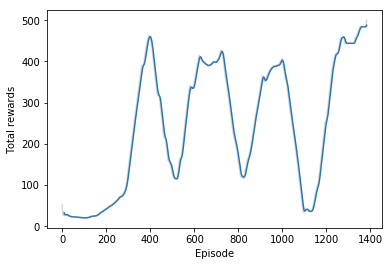

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

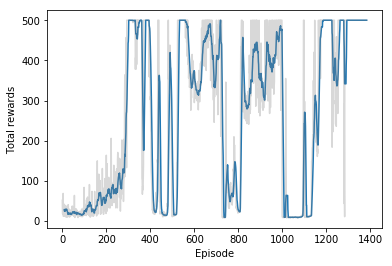

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

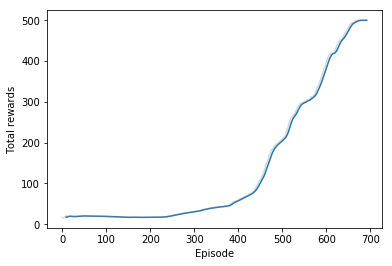

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

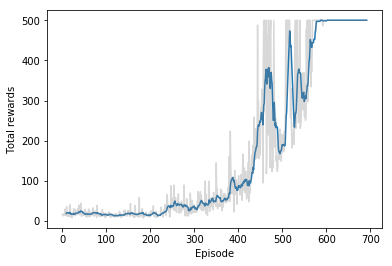

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

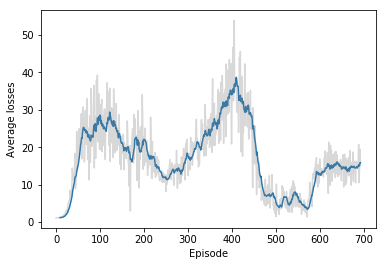

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

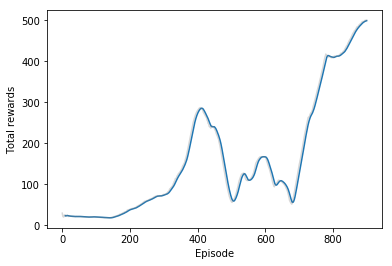

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

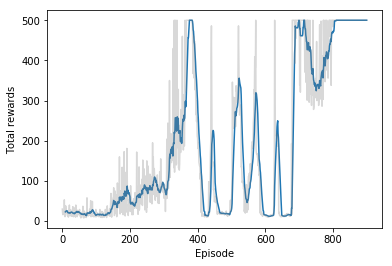

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

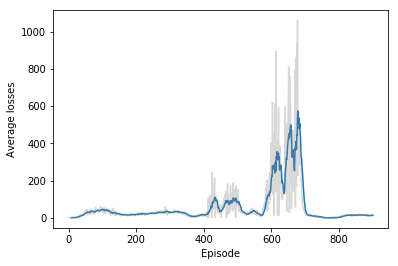

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.